<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/Preprocessing-and-evaluation/finalProject/Recommendation_System_Project_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6> Music Recommendation System - Final Project</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

</div>

# Background/Introduction

Finding the perfect song to listen to can feel like a challenging quest.<br> This is where recommendation systems come in, using data science to help us discover new music that aligns with our tastes and preferences.

A recommendation system is a tool, that utilizes Big Data to understand user preferences and behaviors. <br> By analyzing factors like listening history and genre preferences, these systems suggest songs and artists that match an individual's tastes. And enhances the music discovery process, saving users time and effort while introducing them to new music they're likely to enjoy.


# Main Objective<br>

The objective of our project is to build a recommendation system that can suggest the top 10 songs to a user, <br> based on the likelihood that the user will enjoy those songs, having the users' musical preferences, we will use and test a few models, <br> and finally after evaluating and comparing between the models, we aim to create a system that enriches their music listening experience.


# Data

The Taste Profile Subset, provided by the Echo Nest as a component of the Million Song Dataset, comprises two files. <br> The 1st file includes song details such as song ID, title, release information, artist name, and release year.  <br> The 2nd file contains user IDs, song IDs, and the corresponding play counts by users.

`song_data.rar` - <br>

**song_id** - A unique id given to every song

**title** - Title of the song

**Release** - Name of the released album

**Artist_name** - Name of the artist

**year** - Year of release

<br>

`triplets_file.rar` - <br>

**user_id** - A unique id given to the user

**song_id** - A unique id given to the song

**listen_count** - Number of times the song was played

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Background/Introduction](#scrollTo=2PTur39mv9rt)

>[Main Objective](#scrollTo=kaFLNJh5gnu7)

>[Data](#scrollTo=6KQAH9j-qoZw)

>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#scrollTo=kXwOL606ZfUN)

>[Handling the data](#scrollTo=10dFieGliGFn)

>>[Data cleaning](#scrollTo=i1NGznkkiL5J)

>>[Merging the data](#scrollTo=HGCZ7ah8iOMa)

>[Exploratory Data Analysis](#scrollTo=Wm5QD4lUigH8)

>[TODO](#scrollTo=bgN_BPiptmiE)

>[Preprocessing](#scrollTo=8iVqCeAMimBE)

>[Full function section](#scrollTo=y_4W_frl0COw)

>>[Splitting the data](#scrollTo=m5SPLS-Ujixp)

>[Recommendation system workflow](#scrollTo=ZkALY4u6kidY)

>[Algorithms and Models analysis](#scrollTo=zHwULddKlZkf)

>>[Rank-based (Popularity)](#scrollTo=T2_JBRavnciT)

>[Importing RecSys algos](#scrollTo=s7fshDnT5DId)

>>[Collaborative-filtering](#scrollTo=uZX1s5honcYg)

>>[Preparing the data](#scrollTo=TMGhhINR5oO9)

>>>[Similarity/Neighborhood-based](#scrollTo=C-AdyyD6ncFC)

>>>>[Tune the baseline user-user-similarity model, and try improving its performance](#scrollTo=vcsUSUBOAMHJ)

>>>[Build a baseline item-item-similarity model](#scrollTo=sQlfGaUoBDt8)

>>>>[Tune the baseline item-item-similarity model, and try improving its performance](#scrollTo=5tNUZHsABolW)

>>>[Model-Based Collaborative Filtering - Matrix Factorization](#scrollTo=hH_v8DqpB5r9)

>>>>[Tune the baseline SVD model, and try improving its performance](#scrollTo=aSgBRcL1xnVC)

>>[Cluster-based](#scrollTo=ABABIeyTn0F5)

>>>[Build a baseline Cluster-Based model](#scrollTo=fe-VMWmeCnOp)

>>>>[Tune the baseline Cluster-Based model, and try improving its performance](#scrollTo=c2fd66f5)

>>[Content-based](#scrollTo=VrodWBIBn197)

>>>>[Making recommendations based on the title of a song](#scrollTo=3Jjo3UHKhoEh)

>[Evaluation metrics](#scrollTo=5lX4C4NzlmOK)

>[Showing predictions](#scrollTo=taheIRbMoCLN)

>[Comparing the models](#scrollTo=HJLFpdHpoRGe)

>[Final thoughts](#scrollTo=rzu6n94-onDL)



#  Import Libraries

In [1]:
!pip install rarfile

In [2]:
# Basic libraries of python for numeric and dataframe computations
import pandas as pd
import numpy as np

# Import Matplotlib the Basic library for data visualization
import matplotlib.pyplot as plt

# Import seaborn - Slightly advanced library for data visualization
import seaborn as sns

# Import the required library to compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# Import defaultdict from collections A dictionary output that does not raise a key error
from collections import defaultdict

# Import mean_squared_error : a performance metrics in sklearn
from sklearn.metrics import mean_squared_error

import rarfile
from io import BytesIO
import requests

import matplotlib.colors as mcolors

import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Custom colors #TODO TO CHANGING THAT
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'

# Loading the data

In [4]:
song_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/song_data.rar'
count_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/triplets_file.rar'

In [5]:
# Download the RAR files
song_data_rar_response = requests.get(song_data_rar_url)
count_data_rar_response = requests.get(count_data_rar_url)

In [6]:
def extract_csv_from_rar(rar_content):
    # Create a RarFile object from the content
    with rarfile.RarFile(BytesIO(rar_content), 'r') as rar_file:
        # Get list of files in the RAR archive
        file_list = rar_file.namelist()

        # Initialize empty DataFrames
        df = pd.DataFrame()

        # Iterate through each file in the archive
        for file_name in file_list:
            # Check if the file is a CSV file
            if file_name.endswith('.csv'):
                print(file_name)
                # Extract the CSV file and read it into a DataFrame
                with rar_file.open(file_name) as csv_file:
                    df = pd.read_csv(csv_file)

    return df

In [7]:
if song_data_rar_response.ok and count_data_rar_response.ok:
    # Extract content from the responses
    song_data_rar_content = song_data_rar_response.content
    count_data_rar_content = count_data_rar_response.content

    # Extract CSV files from RAR archives and convert to DataFrames
    song_df = extract_csv_from_rar(song_data_rar_content)
    count_df = extract_csv_from_rar(count_data_rar_content)
else:
  print("Error accessing the rar files, Try Again!")

song_data.csv
triplets_file.csv


# Initial preprocessing

Before exploring the data in depth we will fix and merge some of the dataframes:

As described before, we have 2 datasets that we will be working with:
- song_df - songs and their metadata.
- count_df - User-Song interactions - each song a user has listened to is a seperate row in the dataframe.

In [8]:
song_df

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,SOTXAME12AB018F136,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,SOXQYIQ12A8C137FBB,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,SOHODZI12A8C137BB3,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,SOLXGOR12A81C21EB7,Faraday,The Trance Collection Vol. 2,Elude,0


In [9]:
count_df

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1


## Song_df dataframe

Song dataframe exploration:

In [10]:
# Song_df info
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [11]:
# Shape of song_df
song_df.shape

(1000000, 5)

In [12]:
# Checking for missing values in song_df
song_df.isna().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

In [13]:
#Number of unique values in each column of song_df
song_df.nunique()

song_id        999056
title          702428
release        149288
artist_name     72665
year               90
dtype: int64

Initial insights:
- The df has 1000000 songs but only 999056 unique ones - meaning there are almost 1000 duplicates.
- There are a small number of missing titles to songs.
- There are 5 album missing names.
- There are simillar song titles.
- The data contains songs from 90 different years.

## Count_df dataframe

Count_df dataset exploration :

In [14]:
# Count_df info
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [15]:
# Shape of count_df
count_df.shape

(2000000, 3)

In [16]:
# Checking for missing values in count_df
count_df.isna().sum()

user_id         0
song_id         0
listen_count    0
dtype: int64

In [17]:
#Number of unique values in each column of count_df
count_df.nunique()

user_id         76353
song_id         10000
listen_count      295
dtype: int64

Initial insights:
- The df has 2000000 user-song interactions.
- There are no missing values.
- There are 76353 unique users.
- There are 10000 songs played by the users - meaning that we have a lot of "unused" songs in the songs_df dataset.

## Merging the data

Now we will create a merged dataframe of the two dfs, and at the same time, to get rid of the repeating songs in the song table.<br>
From the resulting combination we will get rid of duplicates according to the identification key of a user with a song.

In [18]:
# Merge count_df and song_df by song_id
combined_df = count_df.merge(song_df.drop_duplicates('song_id'), how='left', on='song_id').drop_duplicates()

In [19]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


# Exploratory Data Analysis

## Basic Analysis

In [20]:
df = combined_df.copy()

In [21]:
# Shape of the data
df.shape

(2000000, 7)

Looking at the types of the df:

In [22]:
#Checking Data Types
df.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Based on our knowledge of the features and the data displayed above we can conclude that: <br>

Our dataset consists 7 features and 2000000 observations.
The features types :

`user_id`, `song_id` - are unique variables, thus we leave them as <u><b>String (Object)</b></u> data types.

`listen_count` is a <u><b>Numeric</b></u> data type.

`title`, `release` and `artist_name` - are <u><b>String (Object)</b></u> data types.

`year` is a <u><b>Numeric</b></u> data type.


In [23]:
def change_data_types(df):

  df['user_id'] = df['user_id'].astype('object')
  df['song_id'] = df['song_id'].astype('object')
  df['listen_count'] = df['listen_count'].astype('int64')
  df['title'] = df['title'].astype('object')
  df['release'] = df['release'].astype('object')
  df['artist_name'] = df['artist_name'].astype('object')
  df['year'] = df['year'].astype('int64')

  return df

In [24]:
df = change_data_types(df)

In [25]:
df.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Describe function will not discribe the "year" feature well. We dont want it to make an average of the years or its std and etc.. It has no meaning for us.

In [26]:
#Summary Statistics (of Numeric features)
# Excluding the 'year' column from df.describe()
describe_without_year = df.drop(columns=['year']).describe()

# Displaying the descriptive statistics
print(describe_without_year)


       listen_count
count  2.000000e+06
mean   3.045485e+00
std    6.579720e+00
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    3.000000e+00
max    2.213000e+03


In [27]:
#Missing Values
df.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

As we can see, in the meantime, we solved the problem of the missing values we have obsered before in the df.songs. <br>
All the songs that were played by the users are without missing values in their metadata.

In [28]:
#Unique Values
df.nunique()

user_id         76353
song_id         10000
listen_count      295
title            9567
release          5388
artist_name      3375
year               58
dtype: int64

Finally, we have a total of 76000 different users listening to 10000 different songs.

In [29]:
# Sum the values in the 'listen_count' column
df['listen_count'].sum()

6090969

We have a total of 6,090,969 listen counts in the data.

## Advanced Analysis and Visualizations

After dealing with the regular EDA of the features, now we would try and find some outliers or sparse data that is hidden in the dimensions of the data:

We can devide this section into sub-sections based on each feature in the following way:
- Song analysis
- Album analysis
- Artist analysis
- User anaysis

We will try to find key components that may lead to a deeper understanding of the data and maybe draw some important conclusions for the following sections of our project.

### Year analysis

We first want to explore the released year of the songs the users listened to:

In [30]:
# Bar Plot of Number of Unique Songs Released by Year
def plot_unique_songs_by_year(df):
    # Group the DataFrame by 'year' and count the number of unique 'song_id' for each year
    unique_songs_by_year = df.groupby('year')['song_id'].nunique().reset_index(name='num_unique_songs')

    # Print the number of unique songs released in each year
    print("Number of Unique Songs Released by Year:")
    print(unique_songs_by_year)

    # Plotting the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='num_unique_songs', data=unique_songs_by_year, color='gold')
    plt.xticks(rotation=45)
    plt.title('Number of Unique Songs Released by Year', weight="bold", size=14)
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Songs Released')
    plt.show()

    # Calculate the sum of num_unique_songs
    total_unique_songs = unique_songs_by_year['num_unique_songs'].sum()

    # Print the sum
    print("Count of unique songs:", total_unique_songs)

    # Check if the sum is 10000
    if total_unique_songs == 10000:
        print("The count is 10000 - Great!")

Number of Unique Songs Released by Year:
    year  num_unique_songs
0      0              1773
1   1954                 1
2   1955                 1
3   1956                 2
4   1957                 1
5   1958                 6
6   1959                 6
7   1960                 5
8   1961                 3
9   1962                 7
10  1963                 6
11  1964                14
12  1965                16
13  1966                15
14  1967                23
15  1968                29
16  1969                29
17  1970                47
18  1971                22
19  1972                36
20  1973                25
21  1974                31
22  1975                22
23  1976                25
24  1977                35
25  1978                46
26  1979                37
27  1980                35
28  1981                42
29  1982                57
30  1983                51
31  1984                65
32  1985                49
33  1986                67
34  1987      

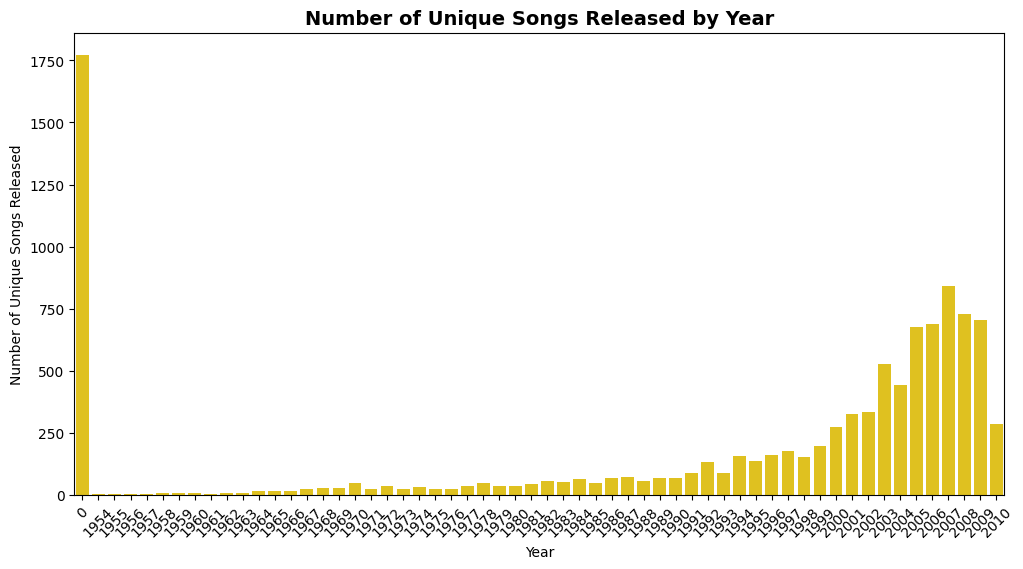

Count of unique songs: 10000
The count is 10000 - Great!


In [31]:
# Call the function to plot the number of unique songs released by year
plot_unique_songs_by_year(df)

Another check of the strange find:

In [32]:
# Filter the DataFrame for songs with a release year of 0 and count the occurrences
num_songs_year_0 = df[df['year'] == 0]['song_id'].nunique()

# Print the result
print("Number of songs with a release year of 0:", num_songs_year_0)


Number of songs with a release year of 0: 1773


We can see that there are a lot of year = 0 songs.<br>
It will be difficult to complete what year these songs released.<br> Normalizing it would probably bias our exploration - Therefore, we will probably leave them out. <br>



- Before implementing our find, we will do some final research:

In [33]:
shape_before_dropping = df.shape
print("Shape of our df before dropping year = 0:", shape_before_dropping)

# Sum the values in the 'listen_count' column
listen_count_before_dropping = df['listen_count'].sum()
print("Sum of all the listen count before dropping year = 0:", listen_count_before_dropping)

different_song_count_before_dropping = df['song_id'].nunique()
print("Number of different songs before dropping year = 0:", different_song_count_before_dropping)

different_user_count_before_dropping = df['user_id'].nunique()
print("Number of different users before dropping year = 0:", different_user_count_before_dropping)

Shape of our df before dropping year = 0: (2000000, 7)
Sum of all the listen count before dropping year = 0: 6090969
Number of different songs before dropping year = 0: 10000
Number of different users before dropping year = 0: 76353


In [34]:
# Dropping all the songs their released year is 0.
df = df[df['year'] > 0]

- By dropping year = 0, we lost some songs their released year was 0.<br> Moreover, we lost some users who listened only to songs its released year was 0. <br>
Of course, the total number of listens became smaller.<br>
Here are the findings:

In [35]:
shape_after_dropping = df.shape
print("Shape of our df after dropping year = 0:", shape_after_dropping)

# Sum the values in the 'listen_count' column
listen_count_after_dropping = df['listen_count'].sum()
print("Sum of all the listen count after dropping year = 0:", listen_count_after_dropping)

different_song_count_after_dropping = df['song_id'].nunique()
print("Number of different songs after dropping year = 0:", different_song_count_after_dropping)

different_user_count_after_dropping = df['user_id'].nunique()
print("Number of different users after dropping year = 0:", different_user_count_after_dropping)

Shape of our df after dropping year = 0: (1627878, 7)
Sum of all the listen count after dropping year = 0: 4849531
Number of different songs after dropping year = 0: 8227
Number of different users after dropping year = 0: 76057


In [36]:
print("By dropping year = 0, we reduced the amount of samples by:", shape_before_dropping[0] - shape_after_dropping[0])
print("By dropping year = 0, we reduced the amount of listening by:", listen_count_before_dropping - listen_count_after_dropping)
print("By dropping year = 0, we reduced the number of songs by:", different_song_count_before_dropping - different_song_count_after_dropping)
print("By dropping year = 0, we reduced the number of users by:", different_user_count_before_dropping - different_user_count_after_dropping)

By dropping year = 0, we reduced the amount of samples by: 372122
By dropping year = 0, we reduced the amount of listening by: 1241438
By dropping year = 0, we reduced the number of songs by: 1773
By dropping year = 0, we reduced the number of users by: 296


In [37]:
combined_df = df.copy()

Number of Unique Songs Released by Year:
    year  num_unique_songs
0   1954                 1
1   1955                 1
2   1956                 2
3   1957                 1
4   1958                 6
5   1959                 6
6   1960                 5
7   1961                 3
8   1962                 7
9   1963                 6
10  1964                14
11  1965                16
12  1966                15
13  1967                23
14  1968                29
15  1969                29
16  1970                47
17  1971                22
18  1972                36
19  1973                25
20  1974                31
21  1975                22
22  1976                25
23  1977                35
24  1978                46
25  1979                37
26  1980                35
27  1981                42
28  1982                57
29  1983                51
30  1984                65
31  1985                49
32  1986                67
33  1987                71
34  1988      

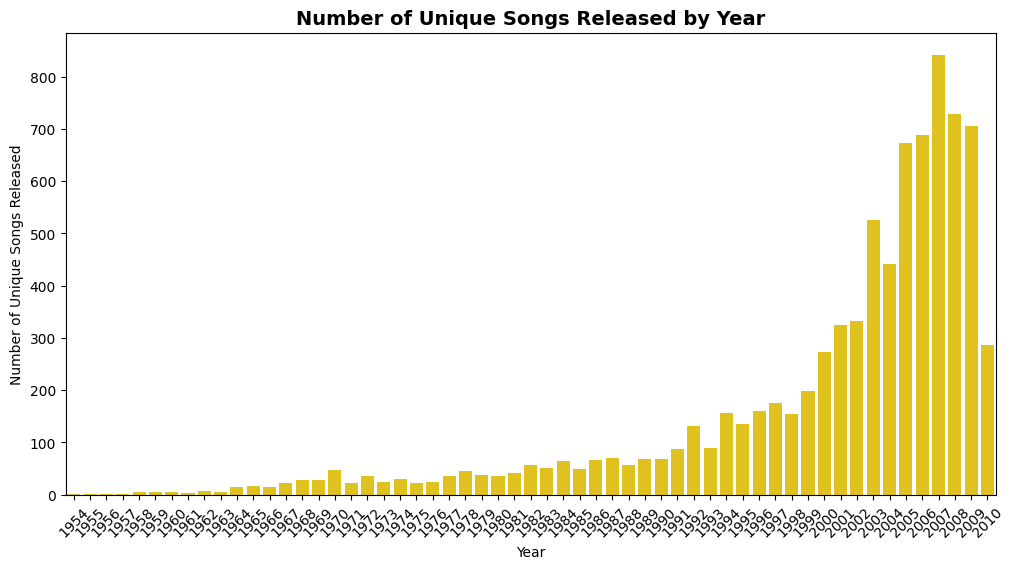

Count of unique songs: 8227


In [38]:
# Call the function to plot the number of unique songs released by year
plot_unique_songs_by_year(df) #8227

In [39]:
unique_song_count = len(df['song_id'].unique())
print("Number of Unique Songs After:", unique_song_count)

print("The system omitted {} songs whose released year was 0.".format(different_song_count_before_dropping - unique_song_count))


Number of Unique Songs After: 8227
The system omitted 1773 songs whose released year was 0.


TODO To check which timeframe the data is from?

It can be concluded from the plot that the users we have in the data listen to more contemporary songs, or alternatively, it can be concluded that as the years passed, more songs were released in each year. <br>
There is a little indent about songs released in 2004. We can think that either few songs were released this year, or, our users less liked songs released this year.

In order to answer this question, let's run a correlation matrix: <br>
Because only "listen_count" and "year" features are numerical features, we will only look at those.

In order for the correlation matrix to work correctly and examine a correlation between these two features, we would like to group our data by the year the song was released. In this way, we will counte the number of listens count grouped by each year of release.<br>
We will examine whether there is a correlation between the year the songs were released in and the number of times these songs were listened.<br>

In [40]:
# Define the custom colormap
colors = ['gold', 'brown']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

def plot_correlation_matrix(df):
    # Filter out rows where year is not 0
    df_filtered = df[df['year'] != 0]

    # Group the DataFrame by 'year' and sum the 'listen_count' for each year
    yearly_listen_counts = df_filtered.groupby('year')['listen_count'].sum().reset_index()

    # Create the correlation matrix
    correlation_matrix = yearly_listen_counts.corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()


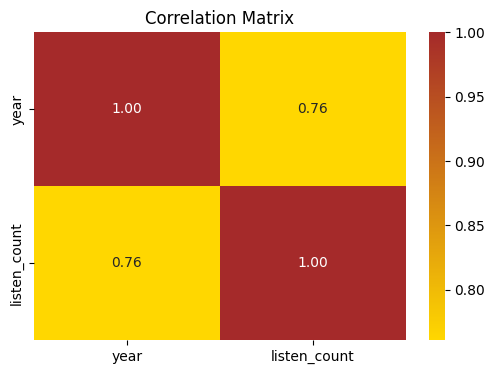

In [41]:
# Call the function to plot the correlation matrix
plot_correlation_matrix(df)

Seems pretty coordinated.<br>
We can conclude that our users like to listen to more recent songs.

### Song analysis

Let's take a look at the most listened songs:

In [42]:
def calculate_top_songs(df, n=10):
    """
    Calculate the top n songs based on the total listen counts.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.
        n (int): The number of top songs to calculate.

    Returns:
        Series: A Series containing the top n songs based on total listen counts.
    """
    # Calculate the total listen counts for each song
    listen_counts = df.groupby('title')['listen_count'].sum()

    # Sort the songs by listen counts in descending order
    listen_counts = listen_counts.sort_values(ascending=False)

    # Select the top n songs
    top_songs = listen_counts.head(n)

    return top_songs


def plot_top_songs(top_songs):
    """
    Plot the top songs based on their total listen counts.

    Parameters:
        top_songs (Series): A Series containing the top songs based on total listen counts.
    """
    # Plotting the top songs
    plt.figure(figsize=(12, 10))
    top_songs.plot(kind='bar', color='skyblue')
    plt.title('Top {} Most Played Songs'.format(len(top_songs)))
    plt.xlabel('Song Title')
    plt.ylabel('Listen Count')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Annotate each bar with its corresponding value on the y-axis
    for i, v in enumerate(top_songs):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

Top 10 Songs:
title
You're The One    54915
Undo              49253
Revelry           41418
Secrets           22100
Invalid           19645
Représente        18054
Fireflies         14617
The Gift          14438
Tive Sim          14423
Marry Me          13116
Name: listen_count, dtype: int64


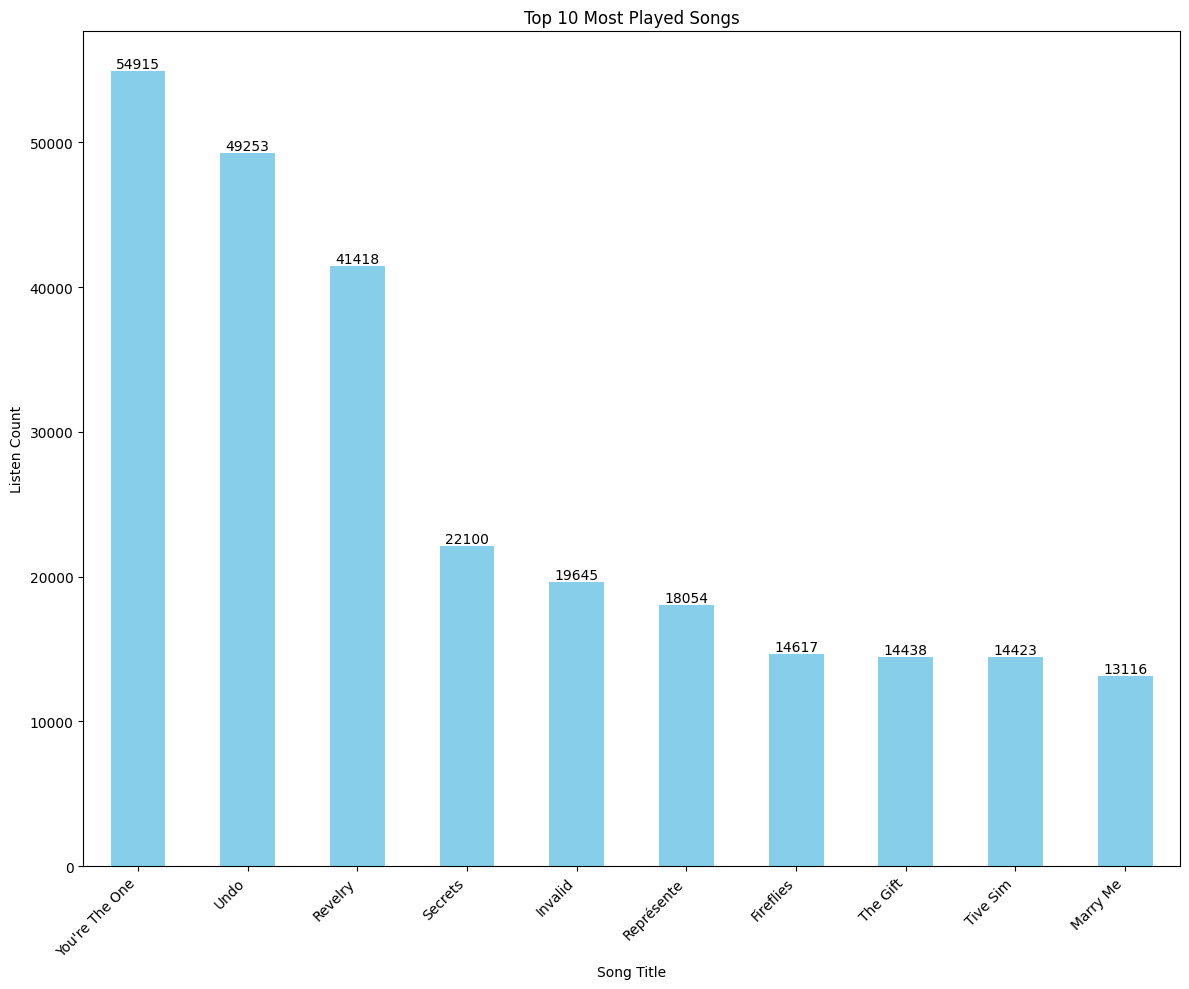

In [43]:
# Call the function to calculate the top songs
top_songs = calculate_top_songs(df)

# Print the top songs
print("Top {} Songs:".format(len(top_songs)))
print(top_songs)

# Call the function to plot the top songs
plot_top_songs(top_songs)

The song "You're The One" was played the most times, played 54915 times.

Now let's look at the songs played by the most different users:

In [44]:
def count_users_per_song(df):
    """
    Count the number of different users who listened to each song and sort the result by the number of users.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.

    Returns:
        DataFrame: A DataFrame containing the song_id, title, and the number of different users who listened to each song,
                   sorted by the number of users in descending order.
    """
    # Group the DataFrame by 'song_id' and count the number of unique 'user_id' for each song
    users_per_song = df.groupby('song_id')['user_id'].nunique().reset_index(name='num_users')

    # Merge with the original DataFrame to get song titles
    users_per_song = pd.merge(users_per_song, df[['song_id', 'title']], on='song_id', how='left')

    # Drop duplicates to ensure each song appears only once
    users_per_song.drop_duplicates(inplace=True)

    # Sort the DataFrame by 'num_users' in descending order
    users_per_song_sorted = users_per_song.sort_values(by='num_users', ascending=False)

    return users_per_song_sorted

In [45]:
def plot_top_users_per_song(users_per_song_df, n=10):
    """
    Plot the number of different users who listened to each song for the top n songs.

    Parameters:
        users_per_song_df (DataFrame): DataFrame containing song IDs, titles, and the number of users.
        n (int): Number of top songs to plot.
    """
    top_songs = users_per_song_df.head(n)

    plt.figure(figsize=(12, 8))
    plt.barh(top_songs['title'], top_songs['num_users'], color='skyblue')
    plt.xlabel('Number of Different Users')
    plt.ylabel('Song Title')
    plt.title(f'Top {n} Songs by Number of Different Users')
    plt.gca().invert_yaxis()  # Invert y-axis to display songs with highest users at the top
    plt.show()

                    song_id  num_users                             title
52567    SOAUWYT12A81C206F1       7032                              Undo
104234   SOBONKR12A58A7A7E0       6412                    You're The One
1196793  SOSXLTC12AF72A7F54       6145                           Revelry
879508   SONYKOW12AB01849C9       5841                           Secrets
700314   SOLFXKT12AB017E3E0       4795                         Fireflies
...                     ...        ...                               ...
1238517  SOTLOKX12A8C1390C2         52               Big Girls Don't Cry
859197   SONOYTE12A6D4F8697         52  (I Can't Get Me No) Satisfaction
1439262  SOWNLZF12A58A79811         51                            Scared
111420   SOBPGWB12A6D4F7EF3         50                Don´t Leave Me Now
432083   SOGSPGJ12A8C134FAA         48        Ghosts (Toxic Avenger Mix)

[8227 rows x 3 columns]


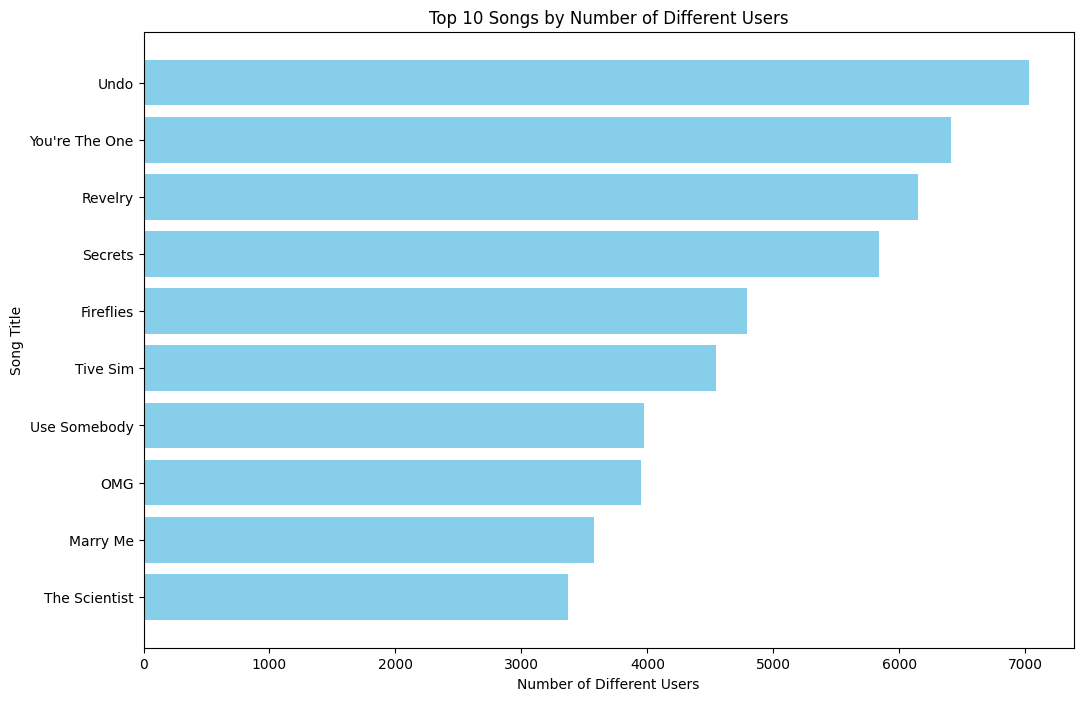

In [46]:
# Get the DataFrame containing the number of users per song
users_per_song_df = count_users_per_song(df)

# Print the DataFrame with song IDs, titles, and the number of users
print(users_per_song_df)

# Call the function to plot the top 10 songs by number of users
plot_top_users_per_song(users_per_song_df)

In [47]:
# Filter the DataFrame for the song "Undo"
undo_data = df[df['title'] == "Undo"]

# Count the number of unique users who listened to "Undo"
num_users_undo = undo_data['user_id'].nunique()

print("Number of users who listened to 'Undo':", num_users_undo)


Number of users who listened to 'Undo': 7032


We can learn that 7032 different users is the highest number of different users listened to a specific song - this song is called: "Undo".<br>
Moreover, 48 different users is the lowest number of different users listened to a specific song - this song is called: "Ghosts (Toxic Avenger Mix)" was listened to by only 48 different users.

Additionally, we would like to understand which songs have been played by enough different users.<br>
In our system we would like to give a higher value to songs played by more users.

In [48]:
def filter_songs_by_user_count(df, max_users_list):
    """
    Filter the DataFrame to include only songs listened to by less than a specified number of users.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.
        max_users_list (list): A list of maximum number of users allowed for a song.

    Returns:
        dict: A dictionary containing filtered DataFrames for each specified maximum number of users.
    """
    filtered_results = {}

    for max_users in max_users_list:
        # Group the DataFrame by 'song_id' and count the number of unique users for each song
        song_listen_counts = df.groupby('song_id')['user_id'].nunique()

        # Filter out the songs with a user count greater than or equal to the specified maximum
        filtered_songs = song_listen_counts[song_listen_counts < max_users]

        # Filter the original DataFrame to include only the songs with less than the specified maximum users
        filtered_df = df[df['song_id'].isin(filtered_songs.index)]

        # Count songs with less and more than the specified maximum users
        num_less_users = len(filtered_songs)
        num_more_users = len(song_listen_counts) - num_less_users
        print(f"There are {num_less_users} songs listened to by less than {max_users} users.")
        print(f"There are {num_more_users} songs listened to by more than {max_users} users.")
        print()

        # Store the filtered DataFrame and results in the dictionary
        filtered_results[max_users] = {'filtered_df': filtered_df, 'num_less_users': num_less_users, 'num_more_users': num_more_users}

    return filtered_results


In [49]:
def plot_song_counts_by_max_users(filtered_results):
    """
    Plot the number of songs listened to by less and more than the specified maximum users.

    Parameters:
        filtered_results (dict): Dictionary containing filtered DataFrames and counts.
    """
    # Extract max_users_list, num_less_users_list, and num_more_users_list from filtered_results
    max_users_list = list(filtered_results.keys())
    num_less_users_list = [result['num_less_users'] for result in filtered_results.values()]
    num_more_users_list = [result['num_more_users'] for result in filtered_results.values()]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar([str(max_users) for max_users in max_users_list], num_less_users_list, label='Less than', color="lightblue")
    plt.bar([str(max_users) for max_users in max_users_list], num_more_users_list, bottom=num_less_users_list, label='More than')

    # Adding labels and title
    plt.xlabel('Number of Users')
    plt.ylabel('Number of Songs')
    plt.title('Number of Songs Listened to by Less and More than the Specified Maximum Users')
    plt.legend()

    # Display the plot
    plt.show()

There are 0 songs listened to by less than 30 users.
There are 8227 songs listened to by more than 30 users.

There are 71 songs listened to by less than 60 users.
There are 8156 songs listened to by more than 60 users.

There are 2060 songs listened to by less than 90 users.
There are 6167 songs listened to by more than 90 users.

There are 3882 songs listened to by less than 120 users.
There are 4345 songs listened to by more than 120 users.

There are 4987 songs listened to by less than 150 users.
There are 3240 songs listened to by more than 150 users.

There are 6097 songs listened to by less than 200 users.
There are 2130 songs listened to by more than 200 users.



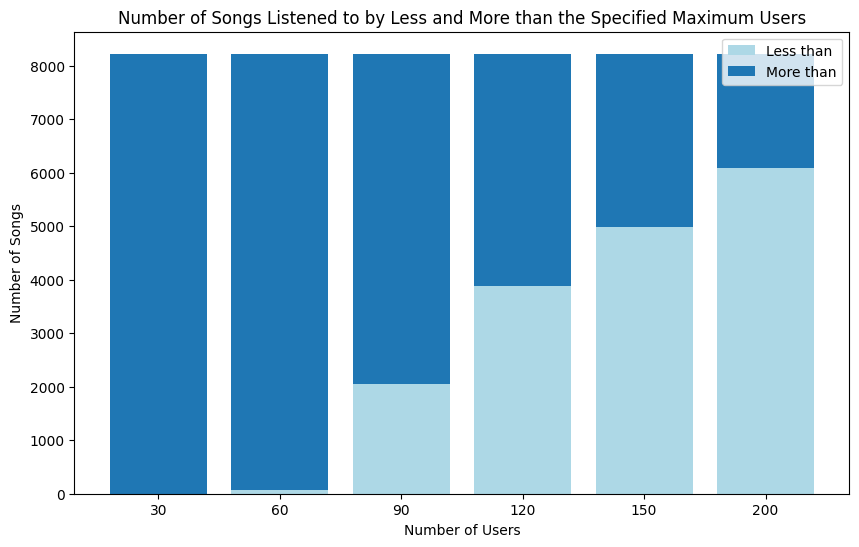

In [50]:
max_users_list = [30, 60, 90, 120, 150, 200]
filtered_results = filter_songs_by_user_count(df, max_users_list)

# Call the plot function directly with filtered results
plot_song_counts_by_max_users(filtered_results)

That's logical that as the number of users increases, there are fewer songs played by this increasing amount of users.<br>
As we can see, all the users listened to more than 30 different songs. It makes sense because we saw before that every song was listened to by at least 48 different users.<br>
We can see that there are a lot of songs that have been listened to by too few users, so it can be concluded that they are less popular.<br>
It will be more difficult to recommend those songs in our recommendation system.

According to the conclusions we drew from the printouts and from the diagram:<br>
There are 2060 songs listened to by less than 90 users.
There are 6167 songs listened to by more than 90 users.<br>
This will leave us with about 75% relevant songs -  seems like a reasonable restriction that doesn't leave out too many songs. <br>
It appears that 90 would be a great restrictor. <br>
We will deal with it later...



### Artist analysis

Some observations about the artists of the songs:

In [51]:
def plot_top_artists(df, n=10):
    # Calculate the total listen counts for each artist
    listen_counts = df.groupby('artist_name')['listen_count'].sum()

    # Sort the artists by listen counts in descending order
    listen_counts = listen_counts.sort_values(ascending=False)

    # Select the top n artists
    top_artists = listen_counts.head(n)

    # Printing the top artists
    print("Top", n, "Most Listened Artists:")
    print(top_artists)

    # Plotting the top artists with a horizontal bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_artists.values, y=top_artists.index, palette=sns.color_palette("Oranges_r", 10))
    plt.title('Top {} Most Listened Artists'.format(n))
    plt.xlabel('Total Listen Count')
    plt.ylabel('Artist')
    plt.tight_layout()  # Adjust layout to prevent clipping of labels

     # Adding count values next to each bar
    for i, count in enumerate(top_artists.values):
      plt.text(count, i, str(count), va='center', fontsize=10, color='black', ha='left')

    plt.show()


Top 10 Most Listened Artists:
artist_name
Coldplay          69528
Kings Of Leon     68570
Dwight Yoakam     54136
Björk             53814
The Black Keys    52220
Jack Johnson      43364
Justin Bieber     41645
OneRepublic       40981
Radiohead         34807
Linkin Park       34692
Name: listen_count, dtype: int64


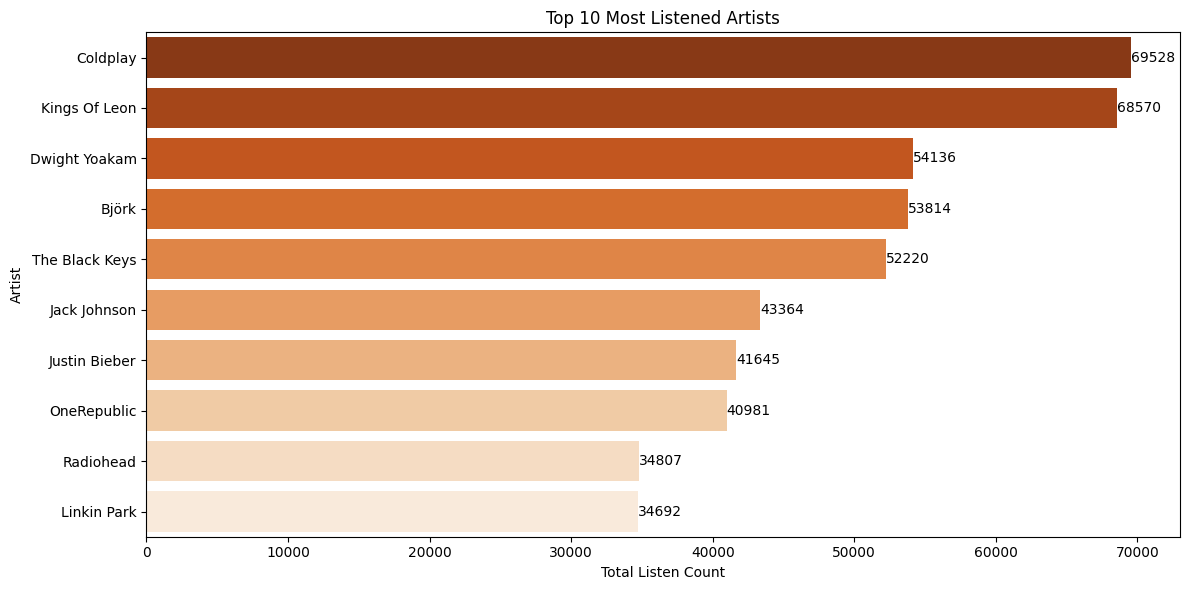

In [52]:
# Display the top 10 artists using a horizontal bar plot
plot_top_artists(df)

The artist whose songs have been played the most is "Coldplay". His songs played 69528 times.

### Album analysis

Some observations about the albums of the songs:

In [53]:
def release_insights(df):
    # Calculate total listen counts per release
    total_listen_counts = df.groupby('release')['listen_count'].sum()
    # Sort releases by total listen counts in descending order
    total_listen_counts = total_listen_counts.sort_values(ascending=False)

    # Print top releases with total listen counts
    print("Top Releases by Total Listen Counts:")
    print(total_listen_counts.head(10))

    # Plotting total listen counts
    plt.figure(figsize=(12, 6))
    sns.barplot(x=total_listen_counts.head(10).index, y=total_listen_counts.head(10).values, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Release')
    plt.ylabel('Total Listen Counts')
    plt.title('Top Releases by Total Listen Counts')

    # Annotate each bar with its corresponding value on the y-axis
    for i, v in enumerate(total_listen_counts.head(10).values):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Top Releases by Total Listen Counts:
release
If There Was A Way    54136
Vespertine Live       49652
Only By The Night     46811
Greatest Hits         39456
My Worlds             38094
Waking Up             33902
Lungs                 24570
Fat Come Back         22069
Fermi Paradox         19645
The Fame Monster      19155
Name: listen_count, dtype: int64


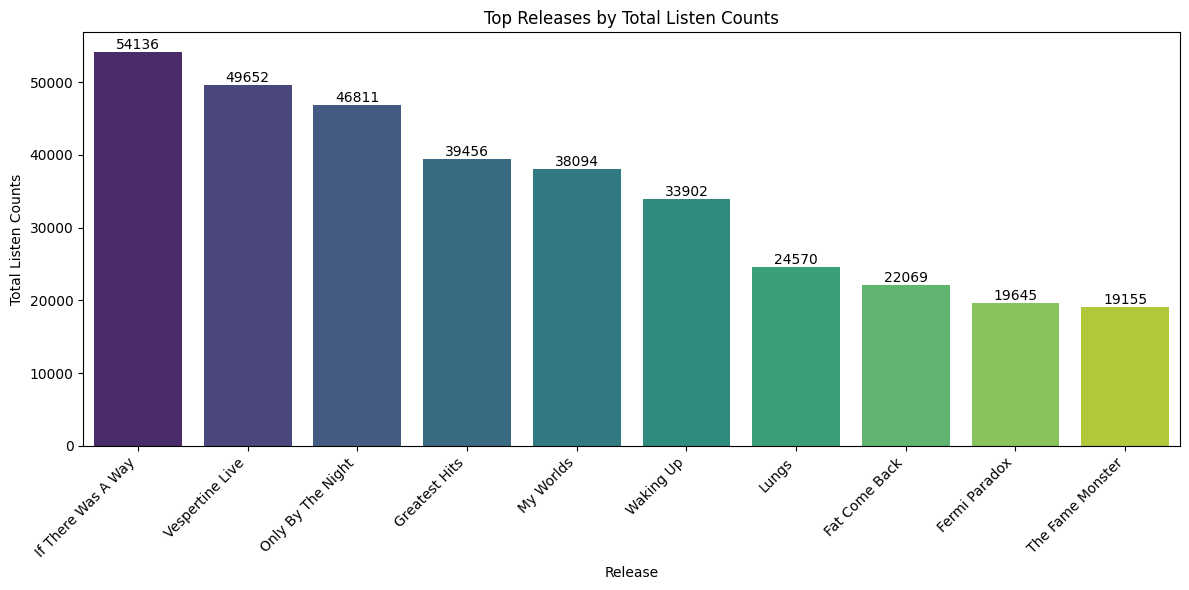

In [54]:
release_insights(df)

The most played album "If There Was A Way" was played 54136 times.

### Listen Count analysis

Let's look at the number of listens for a deeper understanding:

In [55]:
listen_count_df = df.groupby('listen_count')['listen_count'].count()

sorted_listen_count_df = listen_count_df.sort_values(ascending=False)

sorted_listen_count_df.head(20)

listen_count
1     935948
2     254896
3     116008
5      73317
4      66905
6      36187
7      24482
8      17938
10     14797
9      13298
11      9864
12      7754
13      6299
15      5445
14      5104
16      4145
17      3481
18      2937
20      2562
19      2526
Name: listen_count, dtype: int64

We can see that there are 935,948 out of 1,627,878  plays of songs that the user has listened only once.<br>
Can we conclude that he didn't like the song and therefore never listened to it again?

In [56]:
def plot_listen_count_distribution(listen_count_df, max_listen_count):
    listen_count_range = range(1, max_listen_count + 1)
    listen_count_counts = [listen_count_df.get(count, 0) for count in listen_count_range]

    plt.figure(figsize=(10, 6))
    plt.bar(listen_count_range, listen_count_counts, color='lightgreen')
    plt.title('Listen Count Distribution')
    plt.xlabel('Listen Count')
    plt.ylabel('Number of Plays')
    plt.xticks(listen_count_range, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate each bar with its corresponding value on the y-axis
    for i, count in enumerate(listen_count_counts):
        plt.text(i + 1, count, str(count), ha='center', va='bottom')

    plt.show()


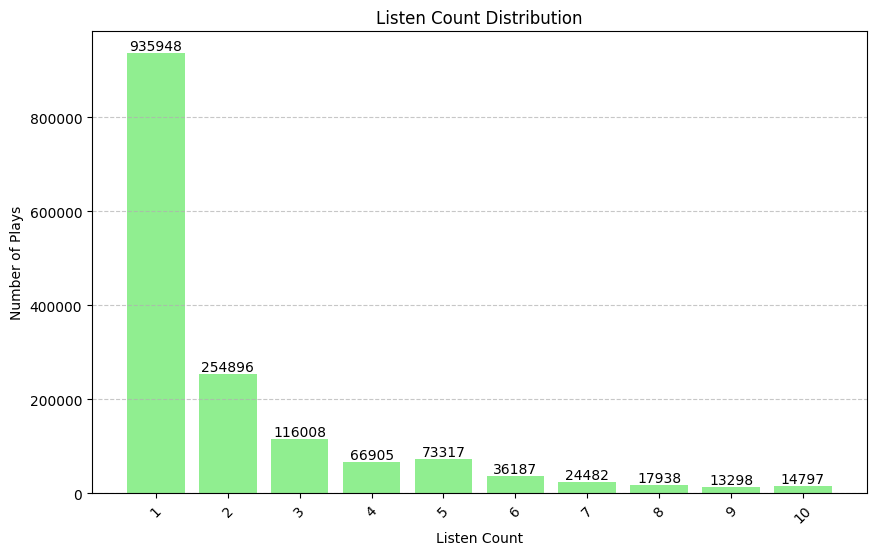

In [57]:
# Call the function to plot the distribution of listen counts within the range of 1 to max_listen_count
max_listen_count = 10  # Specify the maximum listen count
plot_listen_count_distribution(sorted_listen_count_df, max_listen_count)

In [58]:
sorted_listen_count_df.tail(100)

listen_count
152     2
207     2
292     2
215     2
224     2
       ..
250     1
246     1
243     1
236     1
2213    1
Name: listen_count, Length: 100, dtype: int64

What we saw now is how many samples there are for each 'listen_count' number.

Now, we would like to see the number of different users for each 'listen_count' group:

In [59]:
def calculate_users_per_listen_count(df):
    """
    Calculate the number of different users for each listen count group.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame containing the number of users for each listen count group.
    """
    # Group by listen count and count the number of unique users
    users_per_listen_count = df.groupby('listen_count')['user_id'].nunique().reset_index(name='num_users')
    return users_per_listen_count

def plot_users_per_listen_count(users_per_listen_count, n=20):
    """
    Plot the number of different users for each listen count group up to n listen counts.

    Parameters:
        users_per_listen_count (DataFrame): DataFrame containing the number of users for each listen count group.
        n (int): Maximum number of listen counts to plot.
    """
    plt.figure(figsize=(15, 6))
    plt.bar(users_per_listen_count['listen_count'][:n], users_per_listen_count['num_users'][:n], color='skyblue')
    plt.title('Number of Users per Listen Count (Up to ' + str(n) + ' listen counts)')
    plt.xlabel('Listen Count')
    plt.ylabel('Number of Users')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add numbers on top of each column
    for i, num_users in enumerate(users_per_listen_count['num_users'][:n]):
        plt.text(users_per_listen_count['listen_count'][i], num_users + 50, str(num_users), ha='center', va='bottom')

    plt.show()

In [60]:
# Call the function to calculate the number of users per listen count
users_per_listen_count_df = calculate_users_per_listen_count(df)

# Print the DataFrame
users_per_listen_count_df

,listen_count,num_users
0,1,72894
1,2,55976
2,3,39329
3,4,28704
4,5,31325
...,...,...
274,676,1
275,683,1
276,879,1
277,920,1


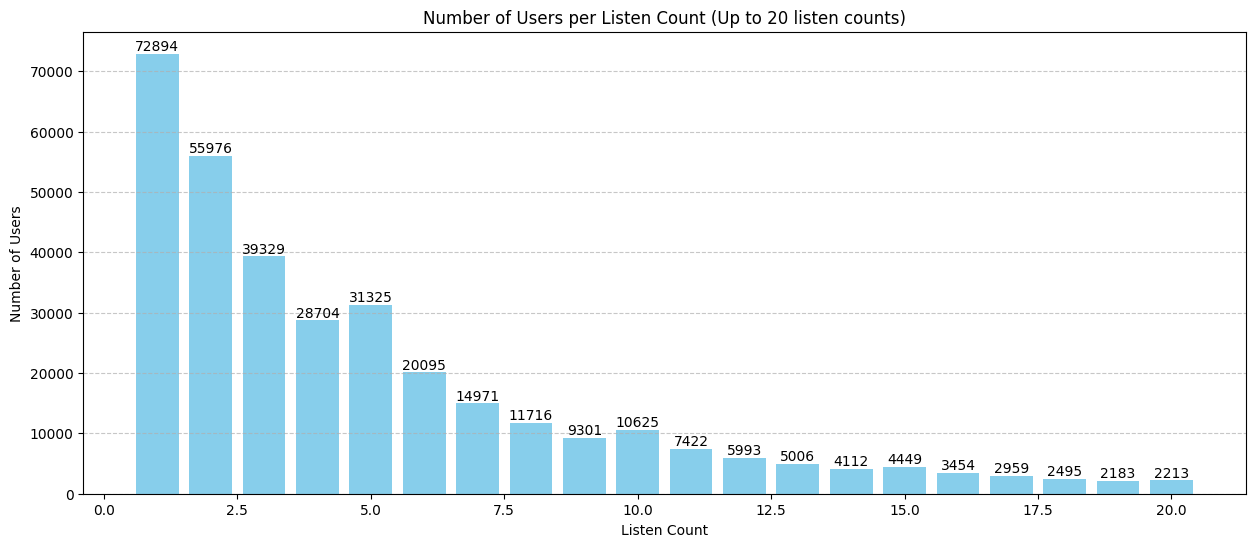

In [61]:
# Call the function to plot the number of users per listen count for up to n listen counts
plot_users_per_listen_count(users_per_listen_count_df, n=20)

It can be concluded that almost every user has a song he listened to only 1 time.<br>
Moreover, there is one special user who listened the same song 2213 times.<br>
Of course, this greatly favors this particular song in our system.

Some data on this observation:

In [62]:
# Get the index label corresponding to the maximum listen_count
max_listen_count_index = df['listen_count'].idxmax()

# Retrieve the entire row from df using the index label
row_with_max_listen_count = df.loc[max_listen_count_index]

print("Row with the largest listen count:")
print(row_with_max_listen_count)


Row with the largest listen count:
user_id         d13609d62db6df876d3cc388225478618bb7b912
song_id                               SOFCGSE12AF72A674F
listen_count                                        2213
title                                          Starshine
release                                         Gorillaz
artist_name                                     Gorillaz
year                                                2000
Name: 1228366, dtype: object


### User analysis

Now, the top 10 users by the number of their listens count:

In [63]:
def get_top_active_users(df, n=10):
    return df.groupby('user_id')['listen_count'].sum().sort_values(ascending=False).head(n)

In [64]:
get_top_active_users(df)

user_id
6d625c6557df84b60d90426c0116138b617b9449    2898
d13609d62db6df876d3cc388225478618bb7b912    2597
4be305e02f4e72dad1b8ac78e630403543bab994    2539
70caceccaa745b6f7bc2898a154538eb1ada4d5a    1936
0b19fe0fad7ca85693846f7dad047c449784647e    1903
283882c3d18ff2ad0e17124002ec02b847d06e9a    1888
5ea608df0357ec4fda191cb9316fe8e6e65e3777    1770
6a944bfe30ae8d6b873139e8305ae131f1607d5f    1757
9c859962257112ad523f1d3c121d35191daa6d2b    1717
6ccd111af9b4baa497aacd6d1863cbf5a141acc6    1697
Name: listen_count, dtype: int64

In [65]:
active_users = get_top_active_users(df, df['user_id'].nunique())

In [66]:
print(active_users.tail(1000))

user_id
9681407fe977fbe8a4a56356f3d93201c503509c    2
4ce0dc0a701133546070e33c4fad5f21d57e52c1    2
3909ac53dd5e5456c0e1de3af170e846ae08cf86    2
b25f3c62649a8b836dc0920d8f9b8f03ed20fa5d    2
b258dfa87711800879b8e26c9b52ed2a8401db95    2
                                           ..
13dd2785ef3c8f415678c3dd8a4afe6626ebfeb8    1
f0d02e65d587f7422cd14ad60eec4fa083c240ce    1
13ce58369594724ac9b49ef6db673a430ad2141a    1
a7a4e02ea22ad83e3c78cb0bfee9b5c92c39abe7    1
b923c4fc244d671f96ede79a60b10da1583ddab2    1
Name: listen_count, Length: 1000, dtype: int64


Let's see some distribution about the users and their listens count:

In [67]:
def plot_user_listen_count_distribution(active_users):
    plt.figure(figsize=(10, 6))
    plt.hist(active_users, bins=20, color='Crimson', edgecolor='black')
    plt.title('Distribution of Listen Count for Active Users')
    plt.xlabel('Total Listen Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

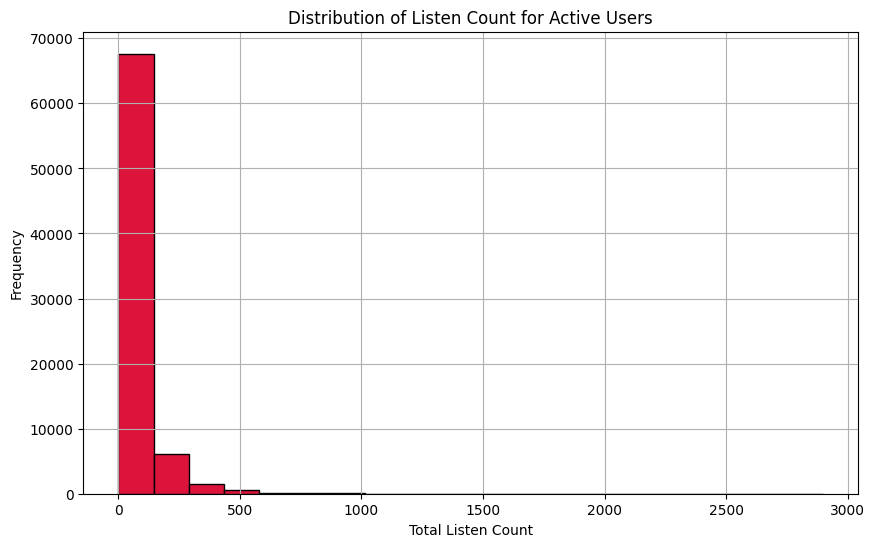

In [68]:
plot_user_listen_count_distribution(active_users)

We can see that there are a lot of users that have listened to only few songs.

It is easy to see that the first column in the output contains the most observations. We would like to refer only to users who have listened to enough songs to be part of our recommendation system.

Let's ignore users who have listened to songs less or equal to 200 times.

In [69]:
filtered_users = active_users[active_users > 200]
filtered_users

user_id
6d625c6557df84b60d90426c0116138b617b9449    2898
d13609d62db6df876d3cc388225478618bb7b912    2597
4be305e02f4e72dad1b8ac78e630403543bab994    2539
70caceccaa745b6f7bc2898a154538eb1ada4d5a    1936
0b19fe0fad7ca85693846f7dad047c449784647e    1903
                                            ... 
ea5ce8359bb00078674794f13c20ae1cdc62c923     201
0a1a3dd772aa44796c5edb468f5d55c25330a754     201
848553482edda04366bc378d69b9ea145db3b757     201
b89435cbcb3970925816131ff4f981c3b0be5fe0     201
50fa0db6886e966968a029269e57fe8fca3f1ce2     201
Name: listen_count, Length: 4847, dtype: int64

In [70]:
# Count the number of users who their listen count is more than 200 songs
num_users_above_200 = len(active_users[active_users > 200])
print("Number of users who their listen count is more than 200:", num_users_above_200)
num_users_below_or_equal_200 = df['user_id'].nunique() - num_users_above_200
print("Number of users who their listen count is less than or equal to 200 songs:", num_users_below_or_equal_200)

Number of users who their listen count is more than 200: 4847
Number of users who their listen count is less than or equal to 200 songs: 71210


There are only 7209 users with more than 200 listens to songs.<br>

Another look, but now after filtering the data to only users who listened to songs at least 200 times.

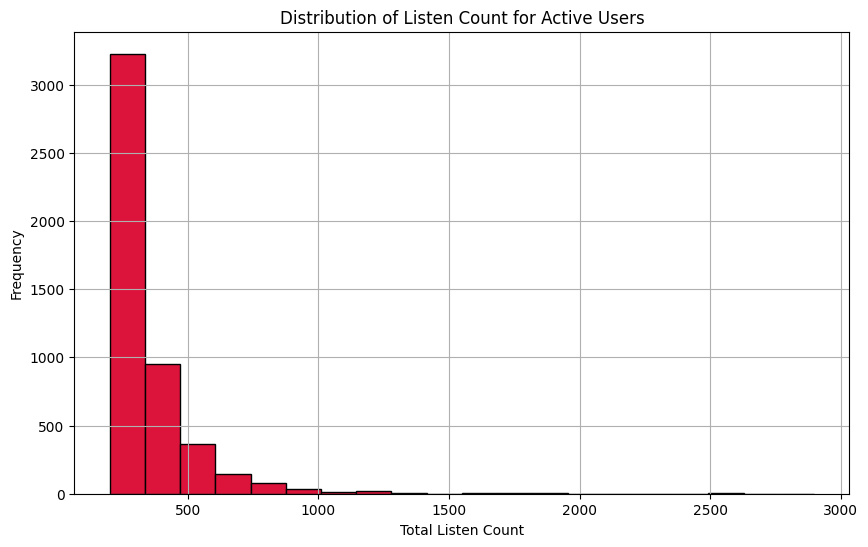

In [71]:
plot_user_listen_count_distribution(filtered_users)

In [72]:
# Count the number of users who their listen count is more than 1000 songs
num_users_above_1000 = len(active_users[active_users > 1000])
print("Number of users who their listen count is more than 1000:", num_users_above_1000)
num_users_below_or_equal_1000 = df['user_id'].nunique() - num_users_above_1000
print("Number of users who their listen count is less than or equal to 1000 songs:", num_users_below_or_equal_1000)

Number of users who their listen count is more than 1000: 53
Number of users who their listen count is less than or equal to 1000 songs: 76004


Only 53 different users has more than 1000 music listens count.

The results we see here are not good enough. <br>
Maybe all the listen counts of a user are from only one song? Or to a very small number of songs?? Do we want to include such users in our recommendation model?

We would like to refer to users according to the number of different songs they heard and not according to the number of listens they have to the music.
Users who are not active enough, do not represent the preferences of the population as they should. <br>

For our recommendation system to work well enough, it would be desirable to let it learn songs and recommend songs learned from users who have heard enough different songs.

Another look on the user's:

In [73]:
def count_songs_per_user(df):
    """
    Count the number of different songs each user listened to and sort the result in descending order.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.

    Returns:
        Series: A Series containing the user_id as the index and the number of different songs listened to by each user as the values,
                sorted in descending order.
    """
    # Group the DataFrame by 'user_id' and count the number of songs each user listened to
    user_listen_counts = df.groupby('user_id').size()

    # Sort the user listen counts in descending order
    sorted_user_listen_counts = user_listen_counts.sort_values(ascending=False)

    return sorted_user_listen_counts

In [74]:
# Call the function to count the number of songs listened to by each user
sorted_user_listen_counts = count_songs_per_user(df)

# Print the sorted number of songs each user listened to
print("Number of different songs each user listened to (sorted):")
print(sorted_user_listen_counts)

Number of different songs each user listened to (sorted):
user_id
6d625c6557df84b60d90426c0116138b617b9449    602
fbee1c8ce1a346fa07d2ef648cec81117438b91f    577
4e11f45d732f4861772b2906f81a7d384552ad12    473
1aa4fd215aadb160965110ed8a829745cde319eb    468
6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d    449
                                           ... 
3c205663c5f9ea57f79cf63ee7d51d15395913c9      1
adab5babca2278e4db4c0ffa45812e30c5dddb15      1
3c57ce98d816f5b332120f2ed7093a3c7830c9d4      1
f879c1c706100c314157a372668c48f23e2d54fb      1
8024a1ce24a9364ba195f98f6ee872d018da7d17      1
Length: 76057, dtype: int64


We can learn that the user who listened to the most different songs listened to 602 songs.

Before we dilute our data -<br>
We would like to understand how many users meet the criteria: how many users have listened to more than 'n' different songs?

In [75]:
def filter_users(df, min_listen_counts=[30, 60, 90, 120, 150]):
    results = {}
    for min_listen_count in min_listen_counts:
        # Group by 'user_id' and count the number of rows for each user
        user_listen_counts = df.groupby('user_id').size()

        # Filter users based on the minimum listen count
        filtered_users = user_listen_counts[user_listen_counts >= min_listen_count]

        # Get the DataFrame containing only the observations for the filtered users
        filtered_df = df[df['user_id'].isin(filtered_users.index)]

        # Get the user IDs of the filtered users
        filtered_user_ids = filtered_users.index

        # Count the number of users who meet the criterion
        num_filtered_users = len(filtered_user_ids)

        # Count the number of users who did not meet the criterion
        num_non_filtered_users = len(user_listen_counts) - num_filtered_users

        # Store the results
        results[min_listen_count] = {'filtered_df': filtered_df, 'num_filtered_users': num_filtered_users, 'num_non_filtered_users': num_non_filtered_users}

    return results

In [76]:
# Filter out users who have listened to more than 30, 60, 90, 120, and 150 songs respectively and get the counts
filtered_results = filter_users(df, min_listen_counts=[30, 60, 90, 120, 150])

# Print the results for each minimum listen count
for min_listen_count, result in filtered_results.items():
    print(f"\nResults for minimum song count of {min_listen_count}:")
    print("Filtered DataFrame:")
    result['filtered_df']
    print("Number of users who have listened to more than", min_listen_count, " different songs:", result['num_filtered_users'])
    print("Number of users who have listened to less than or equal to", min_listen_count, " different songs:", result['num_non_filtered_users'])



Results for minimum song count of 30:
Filtered DataFrame:
Number of users who have listened to more than 30  different songs: 15762
Number of users who have listened to less than or equal to 30  different songs: 60295

Results for minimum song count of 60:
Filtered DataFrame:
Number of users who have listened to more than 60  different songs: 5069
Number of users who have listened to less than or equal to 60  different songs: 70988

Results for minimum song count of 90:
Filtered DataFrame:
Number of users who have listened to more than 90  different songs: 2056
Number of users who have listened to less than or equal to 90  different songs: 74001

Results for minimum song count of 120:
Filtered DataFrame:
Number of users who have listened to more than 120  different songs: 969
Number of users who have listened to less than or equal to 120  different songs: 75088

Results for minimum song count of 150:
Filtered DataFrame:
Number of users who have listened to more than 150  different son

In [77]:
def plot_filtered_results(filtered_results):
    min_listen_counts = sorted(filtered_results.keys())
    num_filtered_users_list = []
    num_non_filtered_users_list = []

    for min_listen_count in min_listen_counts:
        result = filtered_results[min_listen_count]
        num_filtered_users_list.append(result['num_filtered_users'])
        num_non_filtered_users_list.append(result['num_non_filtered_users'])

    # Plotting the results
    bar_width = 0.35
    index = range(len(min_listen_counts))

    plt.figure(figsize=(12, 6))
    plt.bar([i + bar_width for i in index], num_filtered_users_list, bar_width, label='More than', color="Crimson")
    plt.bar(index, num_non_filtered_users_list, bar_width, label='Less than or equal to', color="lightgrey")

    plt.xlabel('Minimum Different Songs Count Per User')
    plt.ylabel('Number of Users')
    plt.title('Number of Users by Minimum Different Songs Count')
    plt.xticks([i + bar_width / 2 for i in index], min_listen_counts)
    plt.legend()

    # Annotate each bar with its corresponding value on the y-axis
    for i, v in enumerate(num_filtered_users_list):
        plt.text(i + bar_width, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(num_non_filtered_users_list):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

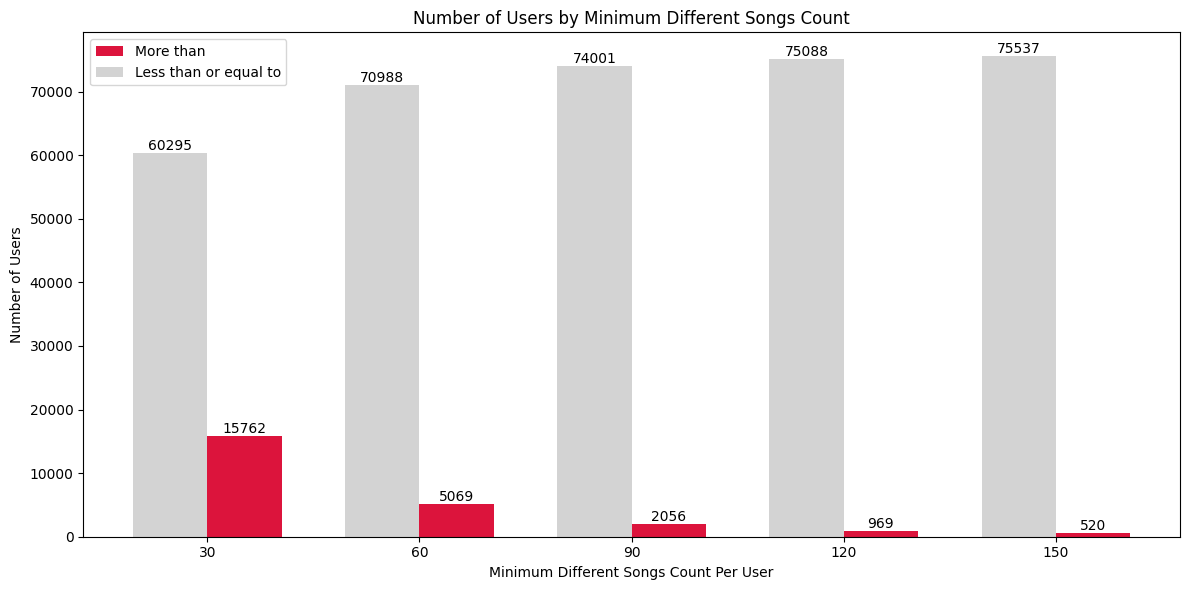

In [78]:
# Plot the filtered results
plot_filtered_results(filtered_results)

Seems like 90 is a great restriction. There are enough users who have heard more than 90 different songs.<br>
As indicated in the output, the number of users who have listened to more than 90 different songs is 2056.

### Rating analysis

Generate a rating scale:

In order to create a rating system, we will want our data to be restricted to users that have listened to every song at most 'n' times. In this way, listen_count can be used as a rating system, with values between 1 and n. <br>
(there is no 0 rating, our data is users listening to songs, there is no song played less than one time).

Let's take a look on the relevant data:

First, to make sure we have enough data left, we would like to check how many users are left after the restriction:

In [79]:
def filter_users_by_max_listen_count(df, start_count=3, end_count=15):
    max_listen_counts = range(start_count, end_count + 1)
    ratings = {}

    for max_listen_count in max_listen_counts:
        # Group the data by 'user_id' and calculate the maximum listen count for each user
        max_listen_counts = df.groupby('user_id')['listen_count'].max()

        # Filter out the users whose maximum listen count is greater than the specified maximum listen count
        relevant_users = max_listen_counts[max_listen_counts <= max_listen_count]

        # Filter the original DataFrame to include only the relevant users
        filtered_df = df[df['user_id'].isin(relevant_users.index)]

        # Count the number of users left after filtering
        num_users_left = len(relevant_users)

        ratings[max_listen_count] = num_users_left
        print(f"Number of users left for max listen count of {max_listen_count}: {num_users_left}")

    return filtered_df, ratings

def plot_users_left(ratings):
    # Define a list of colors
    colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red', 'brown', 'pink']

    plt.figure(figsize=(10, 6))
    # Iterate over each key-value pair in the ratings dictionary and plot a bar with a different color
    for i, (max_listen_count, num_users_left) in enumerate(ratings.items()):
        plt.bar(max_listen_count, num_users_left, color=colors[i % len(colors)])

        # Annotate each bar with its corresponding value on the y-axis
        plt.text(max_listen_count, num_users_left, str(num_users_left), ha='center', va='bottom')

    plt.title('Number of Users Left vs Maximum Listen Count')
    plt.xlabel('Maximum Listen Count')
    plt.ylabel('Number of Users Left')
    plt.xticks(list(ratings.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Number of users left for max listen count of 3: 22774
Number of users left for max listen count of 4: 27405
Number of users left for max listen count of 5: 34784
Number of users left for max listen count of 6: 39274
Number of users left for max listen count of 7: 42591
Number of users left for max listen count of 8: 45292
Number of users left for max listen count of 9: 47450
Number of users left for max listen count of 10: 50841
Number of users left for max listen count of 11: 53030
Number of users left for max listen count of 12: 54903
Number of users left for max listen count of 13: 56439
Number of users left for max listen count of 14: 57741
Number of users left for max listen count of 15: 59415


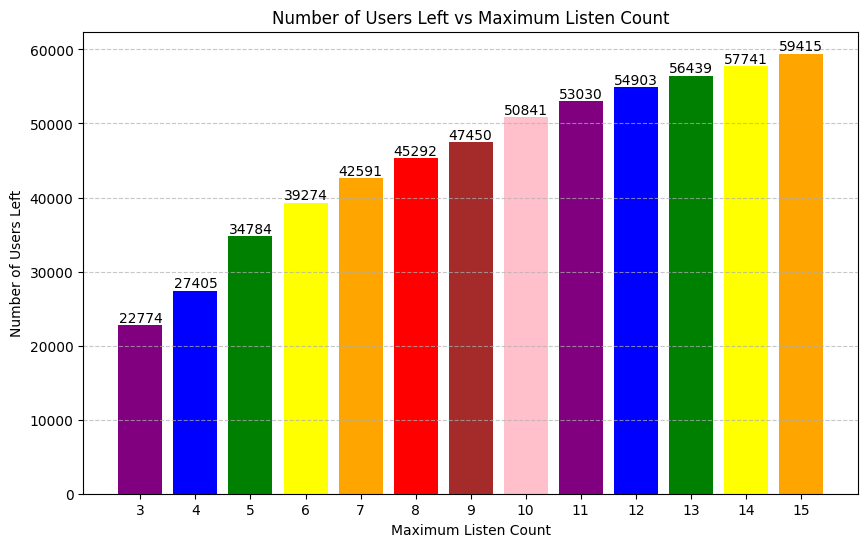

In [80]:
# Call the function to check max listen counts from 3 to 10
filtered_df, ratings = filter_users_by_max_listen_count(df, start_count=3, end_count=15)

# Plot the results
plot_users_left(ratings)

Seems like when the rating scale is from 1-10, we left with 50841 relevant users - enough data to work with.<br>


Next, we would like to see how the 'listen_count' dispersing between the data after restrictions.

We would like to keep only the users who meet the criteria: those who have not heard a song more than 'n' times.<br>
The minimum is 3.
We would like to divide our data into at least 3 different ratings. (If there are less than 3 different ratings, our rating system will not be diversified enough).

In [81]:
def plot_listen_counts_range(df, start_count=3, end_count=15):
    # Define a list of colors
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink', 'cyan']

    for max_listen_counts in range(start_count, end_count + 1):
        # Group the DataFrame by 'user_id' and calculate the maximum listen count for each user
        max_listen_counts_users = df.groupby('user_id')['listen_count'].max()

        # Filter out users who have listened to a song more than the specified maximum listen count
        relevant_users = max_listen_counts_users[max_listen_counts_users <= max_listen_counts].index

        # Filter the original DataFrame to include only the relevant users
        filtered_df = df[df['user_id'].isin(relevant_users)]

        # Count the occurrences of each listen count
        listen_count_counts = filtered_df['listen_count'].value_counts().sort_index()

        # Plot the results with different color for each column
        plt.figure(figsize=(10, 6))
        for i, (listen_count, frequency) in enumerate(zip(listen_count_counts.index, listen_count_counts.values)):
            plt.bar(listen_count, frequency, color=colors[i % len(colors)])
            # Annotate each bar with its frequency
            plt.text(listen_count, frequency, str(frequency), ha='center', va='bottom')

        plt.title(f'Number of Listen Counts (1-{max_listen_counts})')
        plt.xlabel('Listen Count')
        plt.ylabel('Frequency')
        plt.xticks(listen_count_counts.index)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

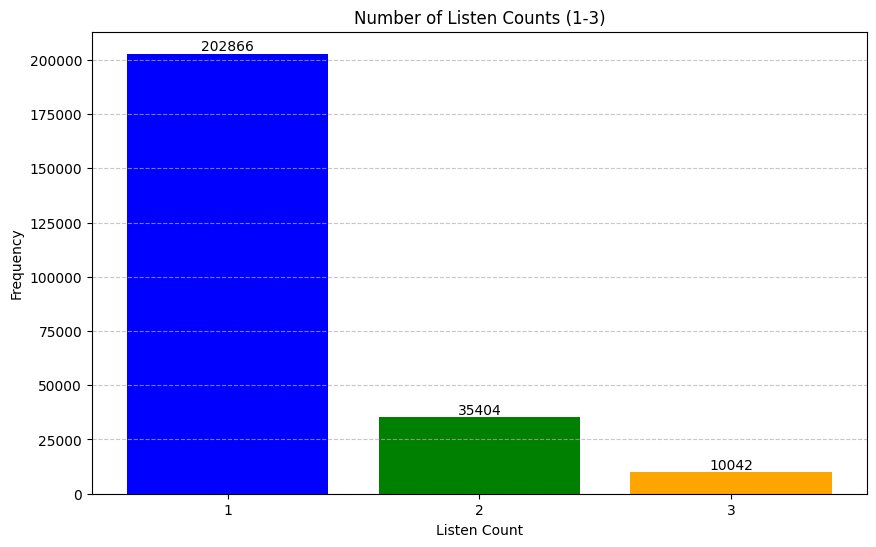

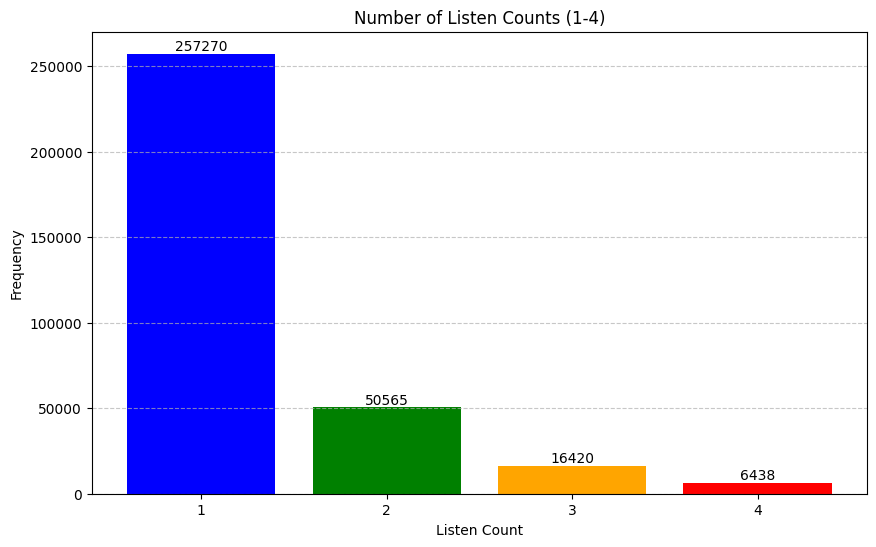

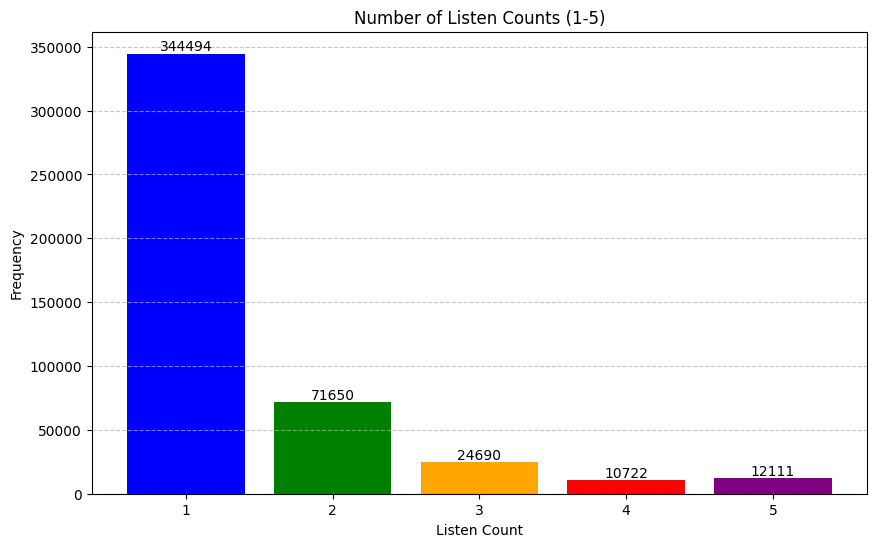

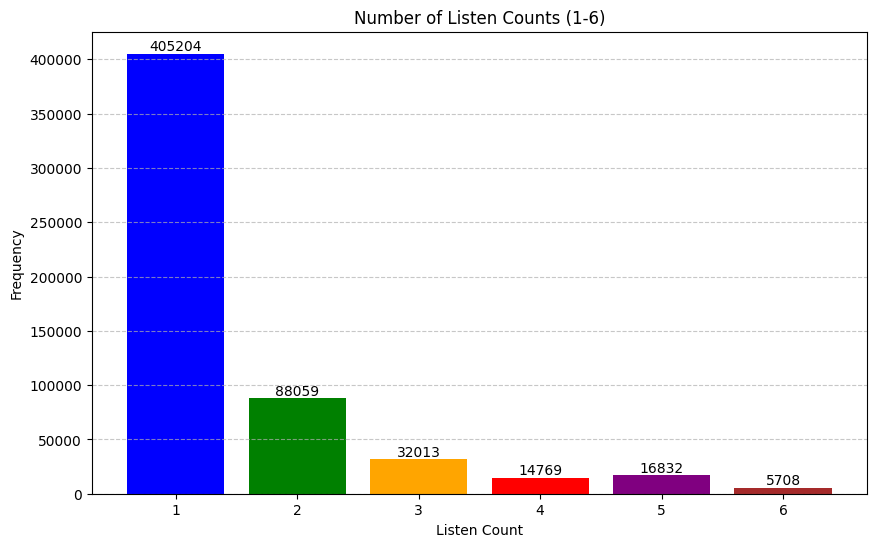

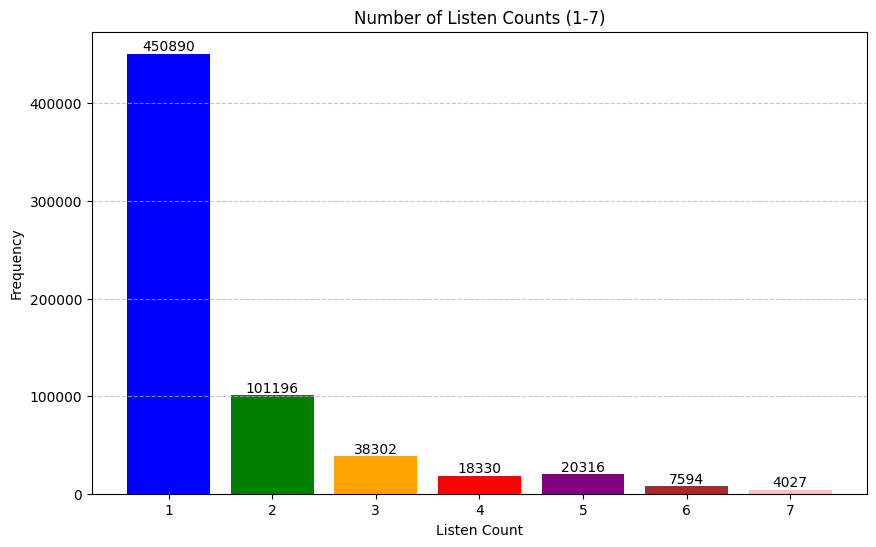

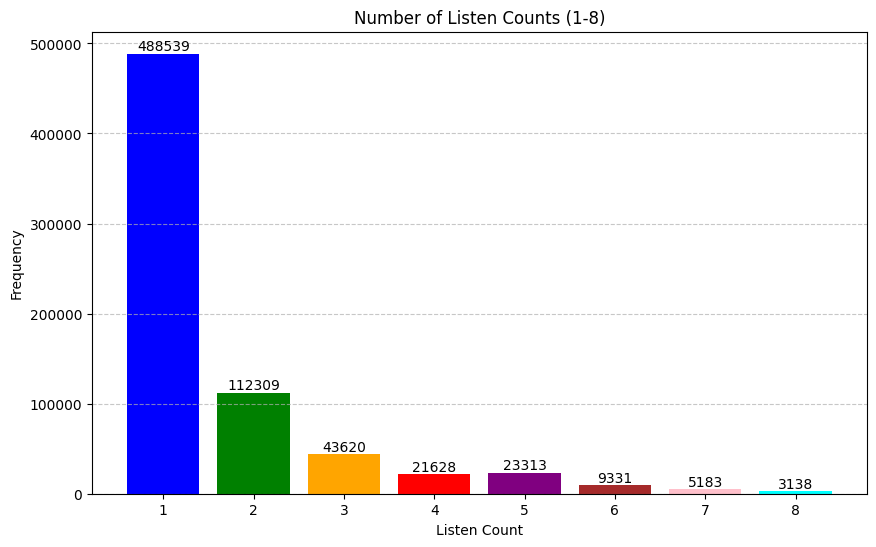

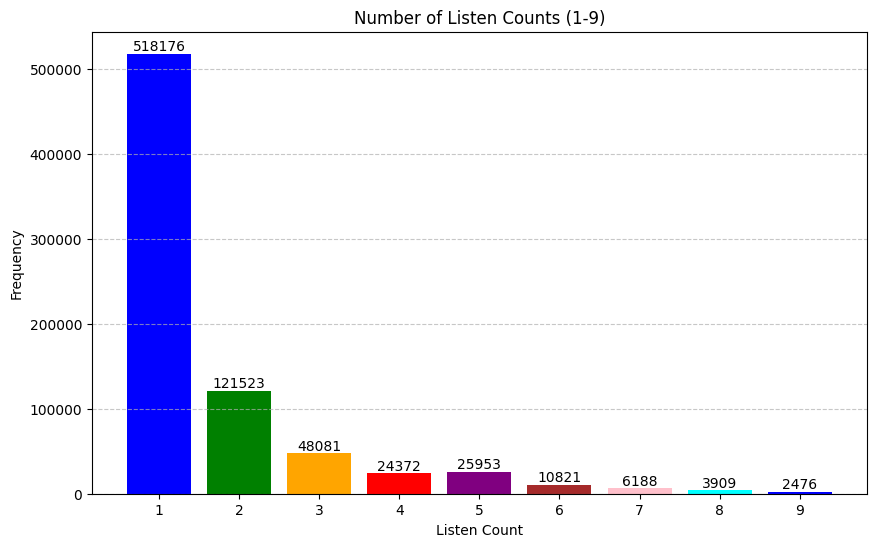

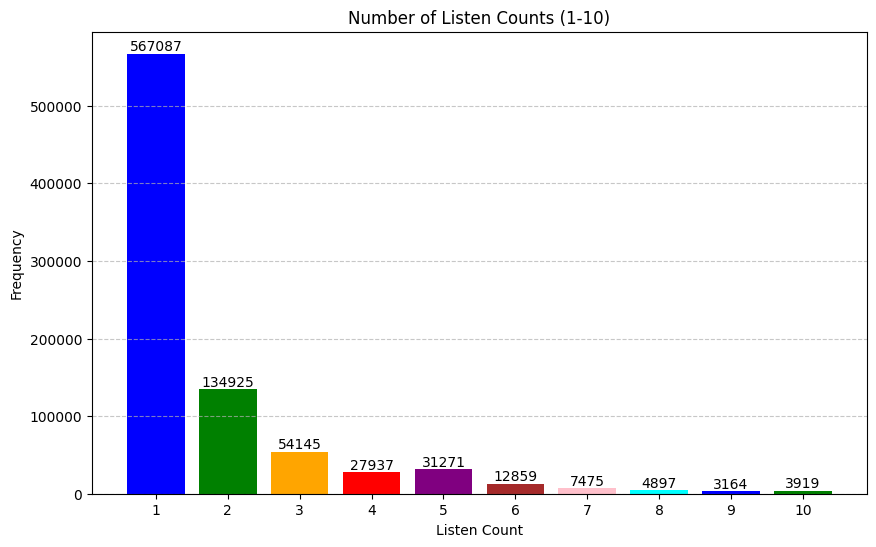

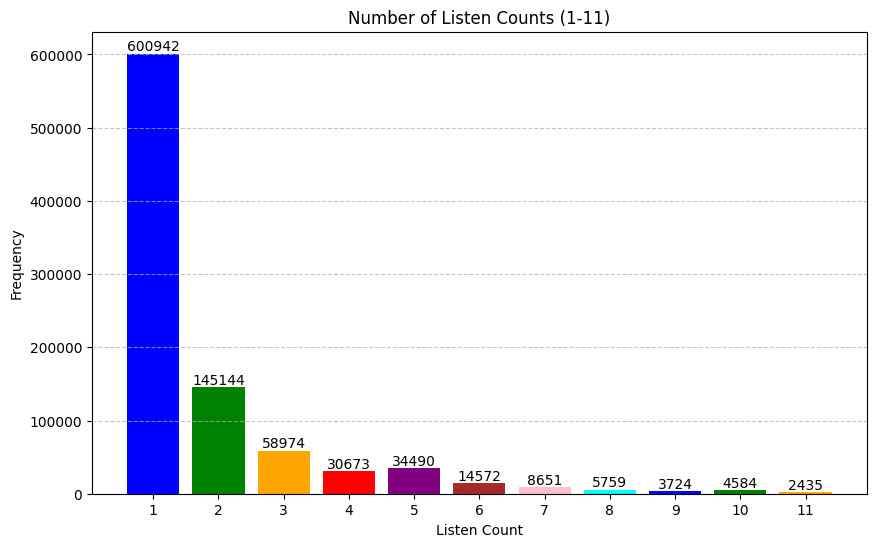

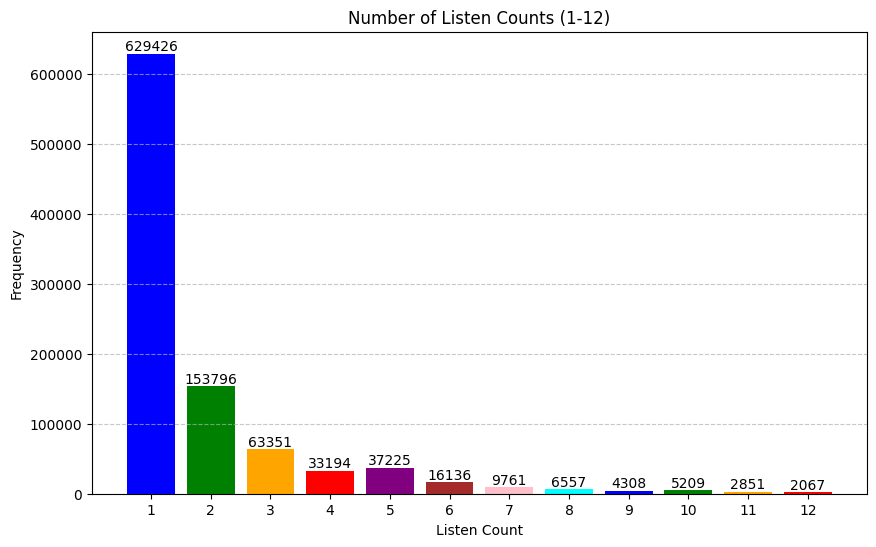

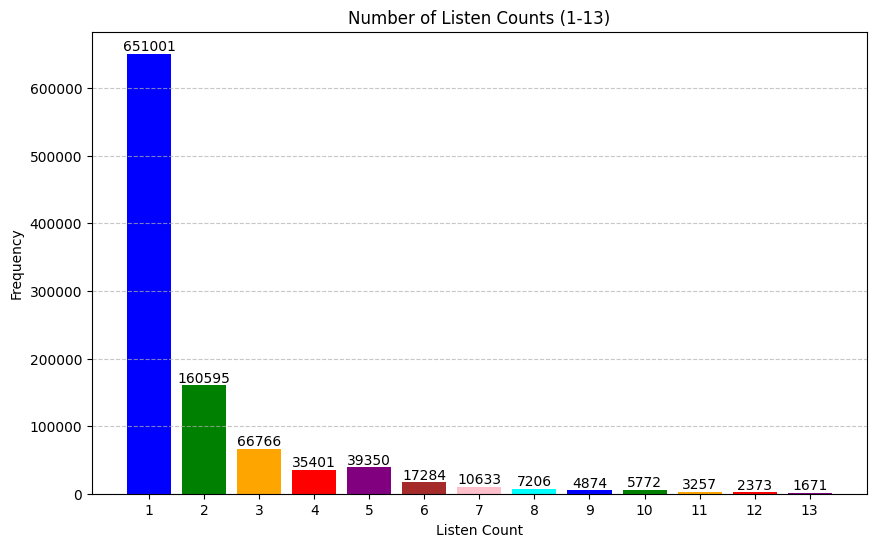

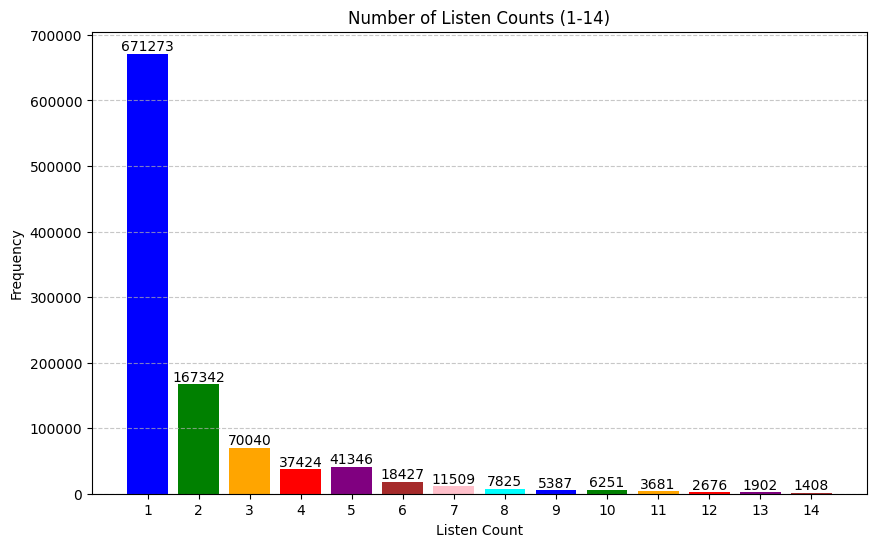

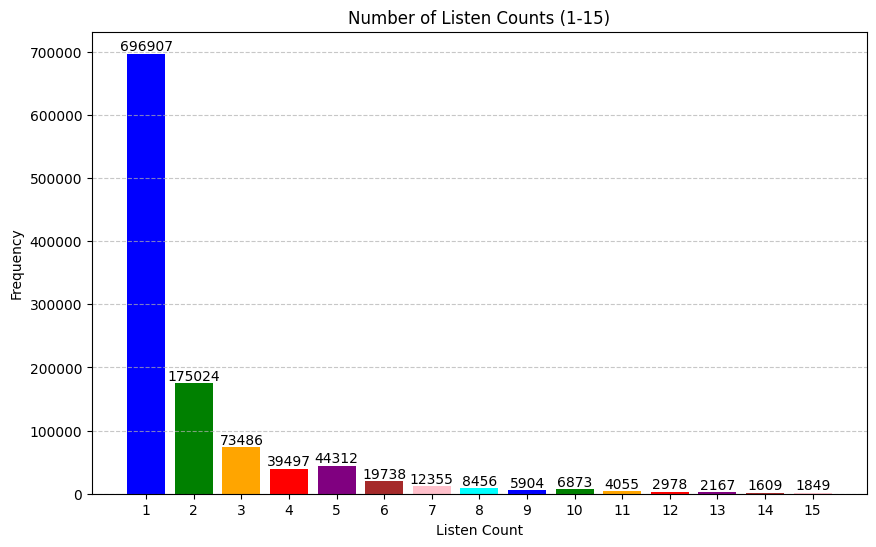

In [82]:
# Call the function with start_count=3 and end_count=15
plot_listen_counts_range(df, start_count=3, end_count=15)

<!-- We can see that starting with a number of listenings of 6 or more, the amount of listenings is less than 10000 and increases a little each time - almost 2.5 times smaller than the column of 5.<br> -->

It seems that it will be enough to limit our data to users who their most played song have listened to up to 10 times in total.<br>

We will deal with all of that later..


# Preprocessing

TODO להבין כמו שצריך האם צריך לאזן את כל הנתונים כך שתהיה כמות זהה של דירוגים 1-5. איזון כזה עלול לפגוע במסקנות שלנו מהנתונים שקיבלנו, לא נרצה להתעלם מהעבודה שיש כמות משמעותית גדולה יותר של שירים שהושמעו פעם אחת בלבד. לחקור איזון ולהבין איך עובדים איתו והאם צריך.


שאלה נוספת, האם צריך לבצע חקר נוסף אחרי הורדת חלק מהמשתמשים או השירים ורק אז לבדוק דירוג 1-5 וכמה עונים עליו. לחקור מה לפני מה והאם המסקנות הסופיות נשארות זהות.

In [83]:
# Apply a label-encoding for user_id and song_id attributes.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
combined_df['user_id'] = label_encoder.fit_transform(combined_df['user_id'])
combined_df['song_id'] = label_encoder.fit_transform(combined_df['song_id'])

In [84]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
1,54752,338,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54752,605,1,Stronger,Graduation,Kanye West,2007
3,54752,618,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54752,972,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
5,54752,1010,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007
...,...,...,...,...,...,...,...
1999994,64343,2767,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
1999996,64343,3051,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64343,3059,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,64343,3182,1,Up,My Worlds,Justin Bieber,2010


We decided after deep research to filter the data we have according to 2 main criteria: We would not like to include in the data:
1. Users who have listened to less than 30 different songs
2. Songs that have been listened to by less than 120 different users

The question arises is how to do it:<br>
a. First get rid of the users who do not meet the criteria we defined and then to get rid from the songs.<br>
b. or alternatively, first get rid of the songs that do not meet the criteria, and then the users.

We first thought of getting rid of the songs that weren't played by enough users and only then getting rid of the users who didn't listen to enough songs,
so the songs we omitted will be omitted from the users who listened them.

We have identified a problem, we would like to judge each user by all the songs he heard and not just by some of them. Diluting the songs first will hurt users who met the criteria but are now disqualified because songs they heard were already omitted from the data. For the reliability and correctness of our recommendation system, we would like to include users in the system even if the songs they hear are special songs.

It would be more correct to first dilute the users who have not listened to enough songs, to ensure that the recommendation system only learns from sufficiently active users. After that, we'll thin out the songs that haven't been played by enough different users.

<b>In conclusion, we chose option a. 1 and then 2. To get rid of the users before getting rid of the songs.<b>


---

<b>

Final conclusions before implementing:
Filter the dataset, by removing, in this order (a-d):

a. The songs that their released year is 0 - Done at the EDA.

b. Users who have listened to less than 30 songs.

c. Songs that have been listened to by less than 120 users.

d. Rating system - we will limit the users to only those who have listened to   each song no more than 10 times.


<b>

---




---

<b>

Final conclusions before implementing:
Filter the dataset, by removing, in this order (a-d):

a. The songs that their released year is 0 - Done at the EDA.

b. Users who listened to too few different songs.

c. Songs that too few different users have listened to.

d. Rating system - we will limit the users to only those who have listened to   each song no more than n times.


Let's do a final research to decide the limit for each of this states.
<b>

---



In [85]:
df_final = combined_df.copy()

In order from b-d, we will start researching and applying the final changes to our original df :

In [86]:
df_final_before_users = combined_df.copy()

### Dropping users < 30 different songs

<b>

b. Dropping users who have listened to less than 30 songs.

</b>

In [87]:
b = 30

- Before implementing our find, we will do some final research:

In [88]:
shape_before_dropping_b = df_final.shape
print("Shape of our df before dropping users <",b ,": ", shape_before_dropping_b)

# Sum the values in the 'listen_count' column
listen_count_before_dropping_b = df_final['listen_count'].sum()
print("Sum of all the listen count before dropping users <",b ,": ", listen_count_before_dropping_b)

different_song_count_before_dropping_b = df_final['song_id'].nunique()
print("Number of different songs before dropping dropping users <",b ,": ", different_song_count_before_dropping_b)

different_user_count_before_dropping_b = df_final['user_id'].nunique()
print("Number of different users before dropping dropping users <",b ,": ", different_user_count_before_dropping_b)

Shape of our df before dropping users < 30 :  (1627878, 7)
Sum of all the listen count before dropping users < 30 :  4849531
Number of different songs before dropping dropping users < 30 :  8227
Number of different users before dropping dropping users < 30 :  76057


In [89]:
# # Group data on user_id, and count how many different songs each user has listened to.
# group_users = df_final.groupby('user_id').count().reset_index(names=['user_id'])
# # Drop the users that have listened to less than 90 songs.
# df_final = df_final.loc[~df_final['user_id'].isin(group_users[group_users['listen_count'] < b]['user_id'])]

In [90]:
def drop_users_with_less_songs(df, min_songs):
    """
    Drop users who listened to less than a specified number of different songs.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.
        min_songs (int): Minimum number of different songs required for a user.

    Returns:
        DataFrame: Filtered DataFrame containing users who listened to at least min_songs different songs.
    """
    # Count the number of unique songs each user listened to
    user_song_counts = df.groupby('user_id')['song_id'].nunique()

    # Find users who listened to less than min_songs different songs
    users_to_drop = user_song_counts[user_song_counts < min_songs].index

    # Drop rows corresponding to the users found above
    filtered_df = df[~df['user_id'].isin(users_to_drop)]

    return filtered_df

# Example usage:
df_final = drop_users_with_less_songs(df_final, b)

- By dropping users who listened to less than 90 different songs, we lose some songs that was listened to only by the users we dropped. <br>
Of course, the total number of listens become smaller. <br>
Here are the findings:

In [91]:
shape_after_dropping_b = df_final.shape
print("Shape of our df after dropping users <",b ,": ", shape_after_dropping_b)

# Sum the values in the 'listen_count' column
listen_count_after_dropping_b = df_final['listen_count'].sum()
print("Sum of all the listen count after dropping users <",b ,": ", listen_count_after_dropping_b)

different_song_count_after_dropping_b = df_final['song_id'].nunique()
print("Number of different songs after dropping dropping users <",b ,": ", different_song_count_after_dropping_b)

different_user_count_after_dropping_b = df_final['user_id'].nunique()
print("Number of different users after dropping dropping users <",b ,": ", different_user_count_after_dropping_b)

Shape of our df after dropping users < 30 :  (933001, 7)
Sum of all the listen count after dropping users < 30 :  2572156
Number of different songs after dropping dropping users < 30 :  8227
Number of different users after dropping dropping users < 30 :  15762


In [92]:
print("By dropping users <" ,b,", we reduced the amount of samples by:", shape_before_dropping_b[0] - shape_after_dropping_b[0])
print("By dropping users <" ,b,", we reduced the amount of listening by:", listen_count_before_dropping_b - listen_count_after_dropping_b)
print("By dropping users <" ,b,", we reduced the number of songs by:", different_song_count_before_dropping_b - different_song_count_after_dropping_b)
print("By dropping users <" ,b,", we reduced the number of users by:", different_user_count_before_dropping_b - different_user_count_after_dropping_b)

By dropping users < 30 , we reduced the amount of samples by: 694877
By dropping users < 30 , we reduced the amount of listening by: 2277375
By dropping users < 30 , we reduced the number of songs by: 0
By dropping users < 30 , we reduced the number of users by: 60295


In [93]:
print("BEFORE")
get_top_active_users(df_final_before_users)

BEFORE


user_id
32419    2898
62069    2597
22498    2539
33407    1936
3224     1903
11836    1888
28133    1770
31571    1757
46647    1717
32241    1697
Name: listen_count, dtype: int64

In [94]:
print("AFTER")
get_top_active_users(df_final)

AFTER


user_id
32419    2898
62069    2597
22498    2539
3224     1903
11836    1888
28133    1770
31571    1757
46647    1717
32241    1697
65269    1677
Name: listen_count, dtype: int64

In [95]:
# Print the sorted number of songs each user listened to
print("BEFORE - Number of different songs each user listened to (sorted):")
print(count_songs_per_user(df_final_before_users))
print()
# Print the sorted number of songs each user listened to
print("FINAL - Number of different songs each user listened to (sorted):")
print(count_songs_per_user(df_final))

BEFORE - Number of different songs each user listened to (sorted):
user_id
32419    602
74853    577
23205    473
7806     468
31583    449
        ... 
17861      1
51708      1
17937      1
73802      1
38028      1
Length: 76057, dtype: int64

FINAL - Number of different songs each user listened to (sorted):
user_id
32419    602
74853    577
23205    473
7806     468
31583    449
        ... 
69945     30
47873     30
48298     30
69890     30
38027     30
Length: 15762, dtype: int64


In [96]:
# Filter out users who have listened to more than 30, 60, 90, 120, and 150 songs respectively and get the counts
filtered_results_before = filter_users(df_final_before_users, min_listen_counts=[30, 60, 90, 120, 150])

print("BEFORE")
# Print the results for each minimum listen count
for min_listen_count, result in filtered_results_before.items():
    print(f"\nResults for minimum song count of {min_listen_count}:")
    print("Filtered DataFrame:")
    result['filtered_df']
    print("Number of users who have listened to more than", min_listen_count, " different songs:", result['num_filtered_users'])
    print("Number of users who have listened to less than or equal to", min_listen_count, " different songs:", result['num_non_filtered_users'])

print()

# Filter out users who have listened to more than 30, 60, 90, 120, and 150 songs respectively and get the counts
filtered_results_final = filter_users(df_final, min_listen_counts=[30, 60, 90, 120, 150])

print("FINAL")
# Print the results for each minimum listen count
for min_listen_count, result in filtered_results_final.items():
    print(f"\nResults for minimum song count of {min_listen_count}:")
    print("Filtered DataFrame:")
    result['filtered_df']
    print("Number of users who have listened to more than", min_listen_count, " different songs:", result['num_filtered_users'])
    print("Number of users who have listened to less than or equal to", min_listen_count, " different songs:", result['num_non_filtered_users'])



BEFORE

Results for minimum song count of 30:
Filtered DataFrame:
Number of users who have listened to more than 30  different songs: 15762
Number of users who have listened to less than or equal to 30  different songs: 60295

Results for minimum song count of 60:
Filtered DataFrame:
Number of users who have listened to more than 60  different songs: 5069
Number of users who have listened to less than or equal to 60  different songs: 70988

Results for minimum song count of 90:
Filtered DataFrame:
Number of users who have listened to more than 90  different songs: 2056
Number of users who have listened to less than or equal to 90  different songs: 74001

Results for minimum song count of 120:
Filtered DataFrame:
Number of users who have listened to more than 120  different songs: 969
Number of users who have listened to less than or equal to 120  different songs: 75088

Results for minimum song count of 150:
Filtered DataFrame:
Number of users who have listened to more than 150  differ

BEFORE


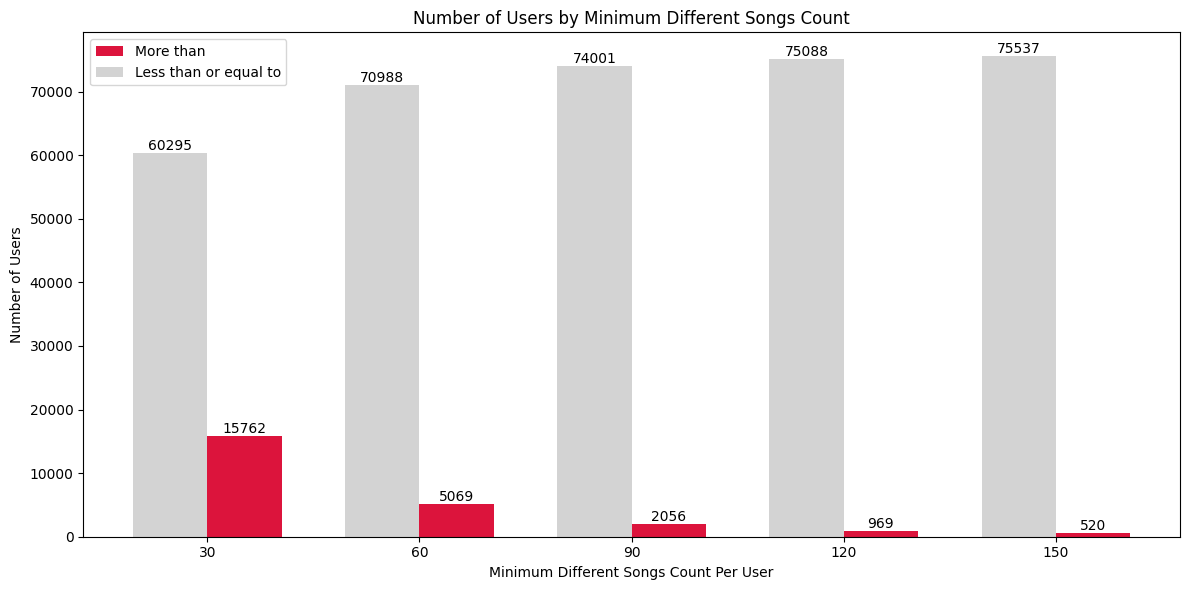


AFTER


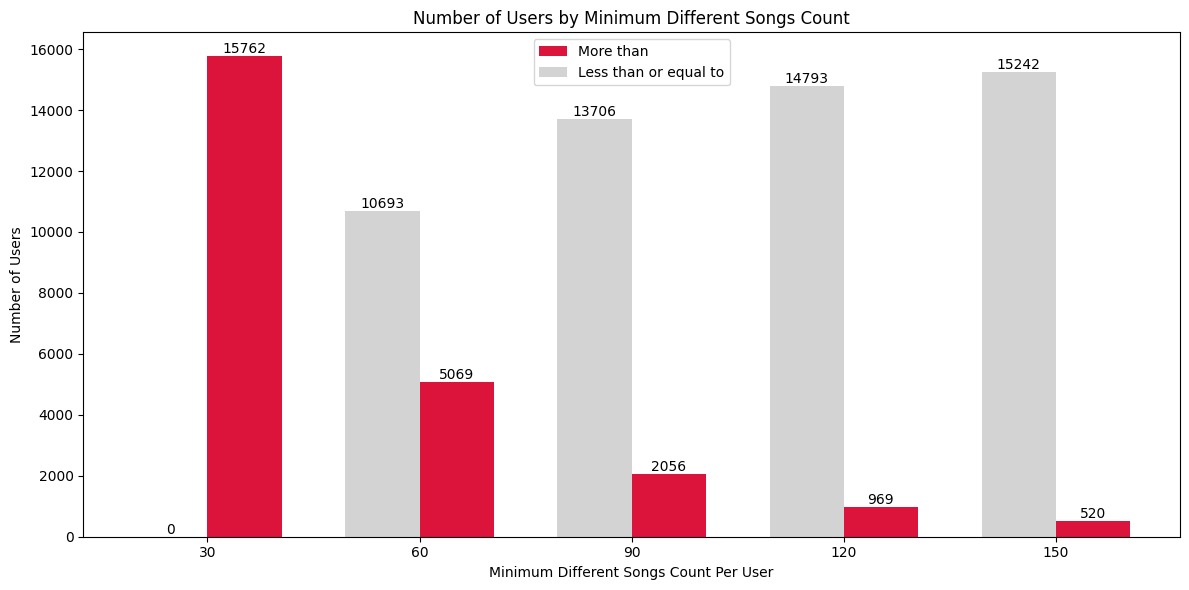

In [97]:
print("BEFORE")
# Plot the filtered results
plot_filtered_results(filtered_results_before)

print()

print("AFTER")
# Plot the filtered results
plot_filtered_results(filtered_results_final)



---



### Dropping songs < 120 different users

<b>

c. Dropping songs that have been listened to by less than 120 users:

</b>

In [98]:
c = 120

In [99]:
df_final_before_songs = df_final.copy()

- Before implementing our find, we will do some final research:

In [100]:
shape_before_dropping_c = df_final.shape
print("Shape of our df before dropping songs <", c, ":", shape_before_dropping_c)

# Sum the values in the 'listen_count' column
listen_count_before_dropping_c = df_final['listen_count'].sum()
print("Sum of all the listen count before dropping songs <", c, ":", listen_count_before_dropping_c)

different_song_count_before_dropping_c = df_final['song_id'].nunique()
print("Number of different songs before dropping dropping songs <", c, ":", different_song_count_before_dropping_c)

different_user_count_before_dropping_c = df_final['user_id'].nunique()
print("Number of different users before dropping dropping songs <", c, ":", different_user_count_before_dropping_c)

Shape of our df before dropping songs < 120 : (933001, 7)
Sum of all the listen count before dropping songs < 120 : 2572156
Number of different songs before dropping dropping songs < 120 : 8227
Number of different users before dropping dropping songs < 120 : 15762


In [101]:
# # Group data on song_id, and count how many different users listened to each song.
# group_songs = df_final.groupby('song_id').count().reset_index(names=['song_id'])
# # Drop the songs that have been listened to by less than 120 users.
# df_final = df_final.loc[~df_final['song_id'].isin(group_songs[group_songs['listen_count'] < c]['song_id'])]

In [102]:
def drop_songs_by_user_count(df, n):
    # Step 1: Group by 'song_id' and count the number of unique 'user_id' for each song
    song_listen_counts = df.groupby('song_id')['user_id'].nunique()

    # Step 2: Filter out songs with a user count less than n
    filtered_songs = song_listen_counts[song_listen_counts >= n]

    # Step 3: Filter the original DataFrame to include only songs with at least n different users
    filtered_df = df[df['song_id'].isin(filtered_songs.index)]

    return filtered_df

df_final = drop_songs_by_user_count(df_final, c)

- By dropping songs which were listened to by less than 120 different users, we lose some users who listened to only songs that we dropped. <br>
Of course, the total number of listens become smaller. <br>
Here are the findings:

In [103]:
shape_after_dropping_c = df_final.shape
print("Shape of our df after dropping songs <", c, ":", shape_after_dropping_c)

# Sum the values in the 'listen_count' column
listen_count_after_dropping_c = df_final['listen_count'].sum()
print("Sum of all the listen count after dropping songs <", c, ":", listen_count_after_dropping_c)

different_song_count_after_dropping_c = df_final['song_id'].nunique()
print("Number of different songs after dropping dropping songs <", c, ":", different_song_count_after_dropping_c)

different_user_count_after_dropping_c = df_final['user_id'].nunique()
print("Number of different users after dropping dropping songs <", c, ":", different_user_count_after_dropping_c)

Shape of our df after dropping songs < 120 : (544534, 7)
Sum of all the listen count after dropping songs < 120 : 1515343
Number of different songs after dropping dropping songs < 120 : 2122
Number of different users after dropping dropping songs < 120 : 15762


In [104]:
print("By dropping songs <", c, ", we reduced the amount of samples by:", shape_before_dropping_c[0] - shape_after_dropping_c[0])
print("By dropping songs <", c, ", we reduced the amount of listening by:", listen_count_before_dropping_c - listen_count_after_dropping_c)
print("By dropping songs <", c, ", we reduced the number of songs by:", different_song_count_before_dropping_c - different_song_count_after_dropping_c)
print("By dropping songs <", c, ", we reduced the number of users by:", different_user_count_before_dropping_c - different_user_count_after_dropping_c)

By dropping songs < 120 , we reduced the amount of samples by: 388467
By dropping songs < 120 , we reduced the amount of listening by: 1056813
By dropping songs < 120 , we reduced the number of songs by: 6105
By dropping songs < 120 , we reduced the number of users by: 0


In [105]:
# Call the function to calculate the top songs
top_songs_before = calculate_top_songs(df_final_before_songs)

# Print the top songs - BEFORE
print("BEFORE - Top {} Songs:".format(len(top_songs_before)))
print(top_songs_before)

print()

# Call the function to calculate the top songs
top_songs_final = calculate_top_songs(df_final)

# Print the top songs - FINAL
print("FINAL - Top {} Songs:".format(len(top_songs_final)))
print(top_songs_final)

BEFORE - Top 10 Songs:
title
You're The One    18964
Undo              18026
Revelry           15025
Secrets           10467
Représente         7635
Invalid            7437
The Gift           6997
Fireflies          6647
Use Somebody       6325
Marry Me           6033
Name: listen_count, dtype: int64

FINAL - Top 10 Songs:
title
You're The One    18964
Undo              18026
Revelry           15025
Secrets           10467
Représente         7635
Invalid            7437
The Gift           6997
Fireflies          6647
Use Somebody       6325
Marry Me           6033
Name: listen_count, dtype: int64


BEFORE


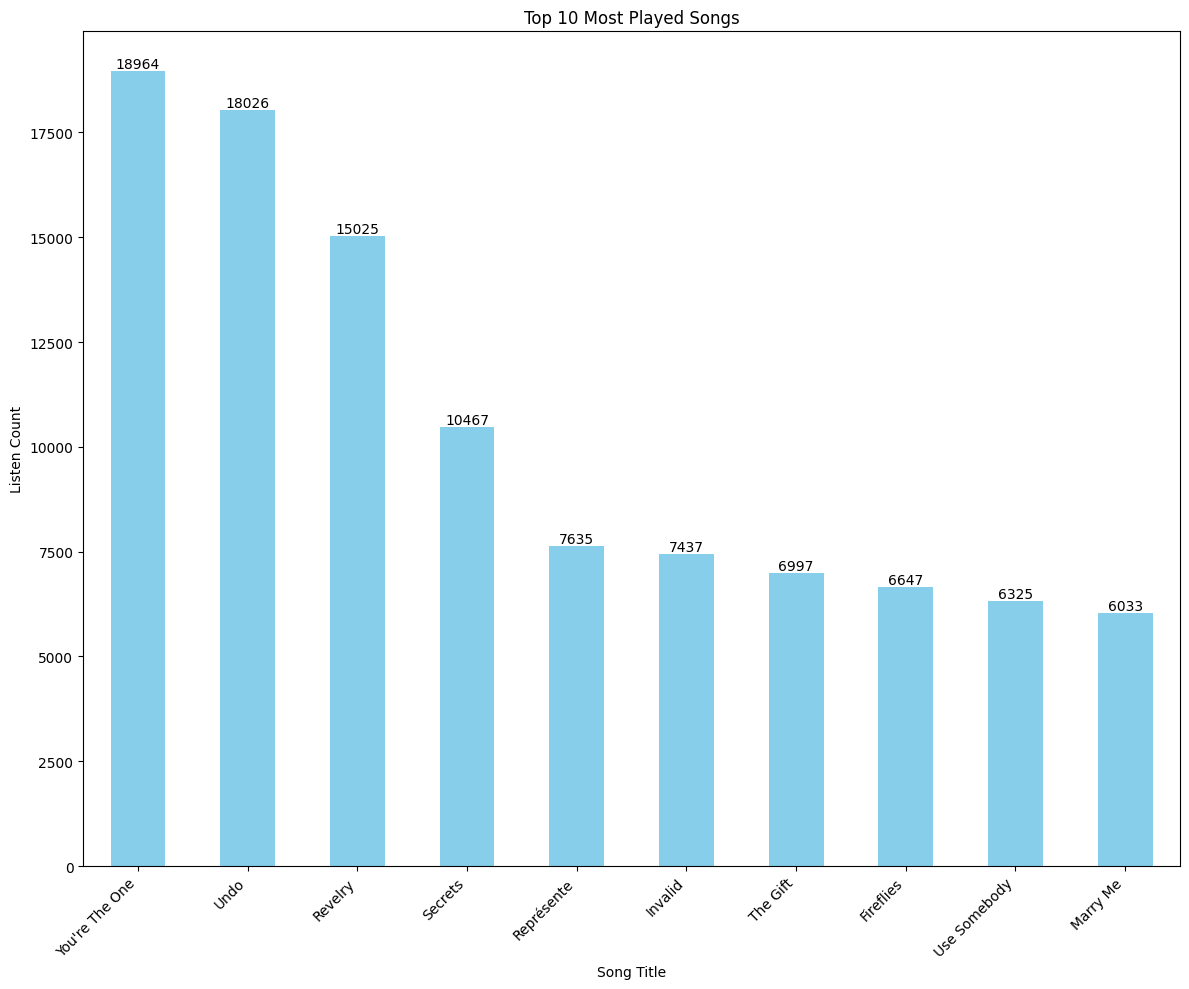


FINAL


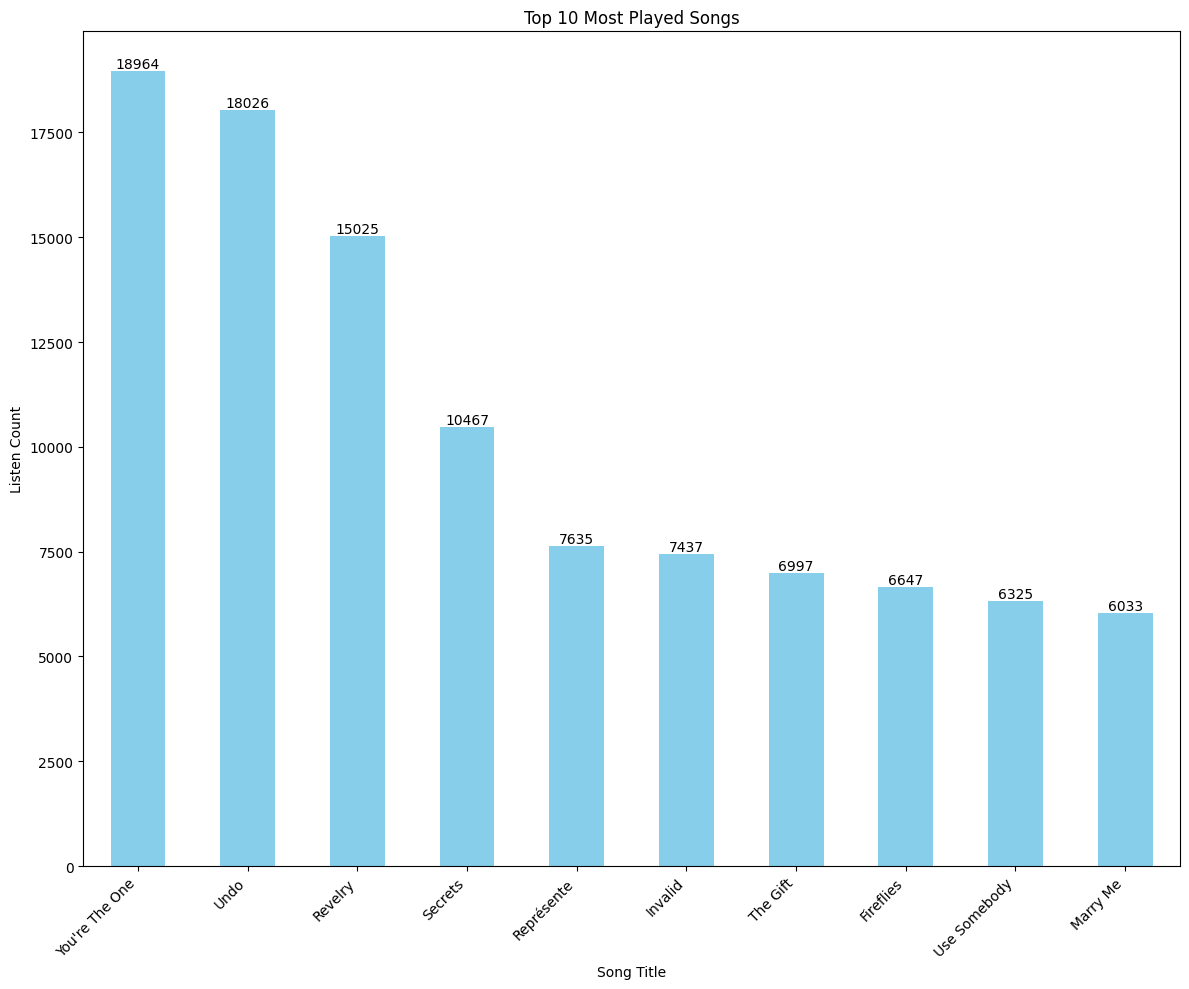

In [106]:
print("BEFORE")
# Call the function to plot the top songs
plot_top_songs(top_songs_before)

print()

print("FINAL")
# Call the function to plot the top songs
plot_top_songs(top_songs_final)

In [107]:
print("BEFORE")
# Get the DataFrame containing the number of users per song
users_per_song_df_before = count_users_per_song(df_final_before_songs)

# Print the DataFrame with song IDs, titles, and the number of users
print(users_per_song_df_before)

print()

print("AFTER")
# Get the DataFrame containing the number of users per song
users_per_song_df_final = count_users_per_song(df_final)

# Print the DataFrame with song IDs, titles, and the number of users
print(users_per_song_df_final)


BEFORE
        song_id  num_users                   title
506081     4516       2590                 Secrets
30243       253       2365                    Undo
687004     6099       2337                 Revelry
803482     7079       2194            Use Somebody
402871     3625       2162               Fireflies
...         ...        ...                     ...
888627     7773         15     Now Behold The Lamb
629399     5587         15                 Beloved
76749       646         14           My Generation
654461     5842         12             Untitled #5
617999     5485         10  Party Like A Rock Star

[8227 rows x 3 columns]

AFTER
        song_id  num_users                            title
292936     4516       2590                          Secrets
18670       253       2365                             Undo
399496     6099       2337                          Revelry
470507     7079       2194                     Use Somebody
230428     3625       2162                       

BEFORE


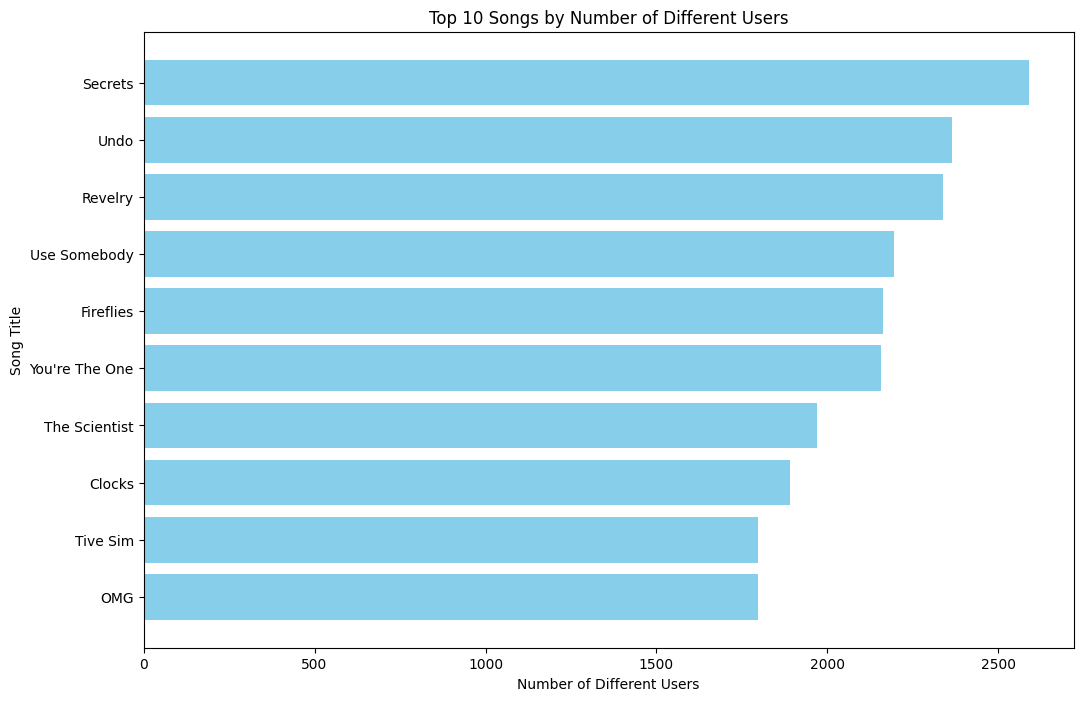


FINAL


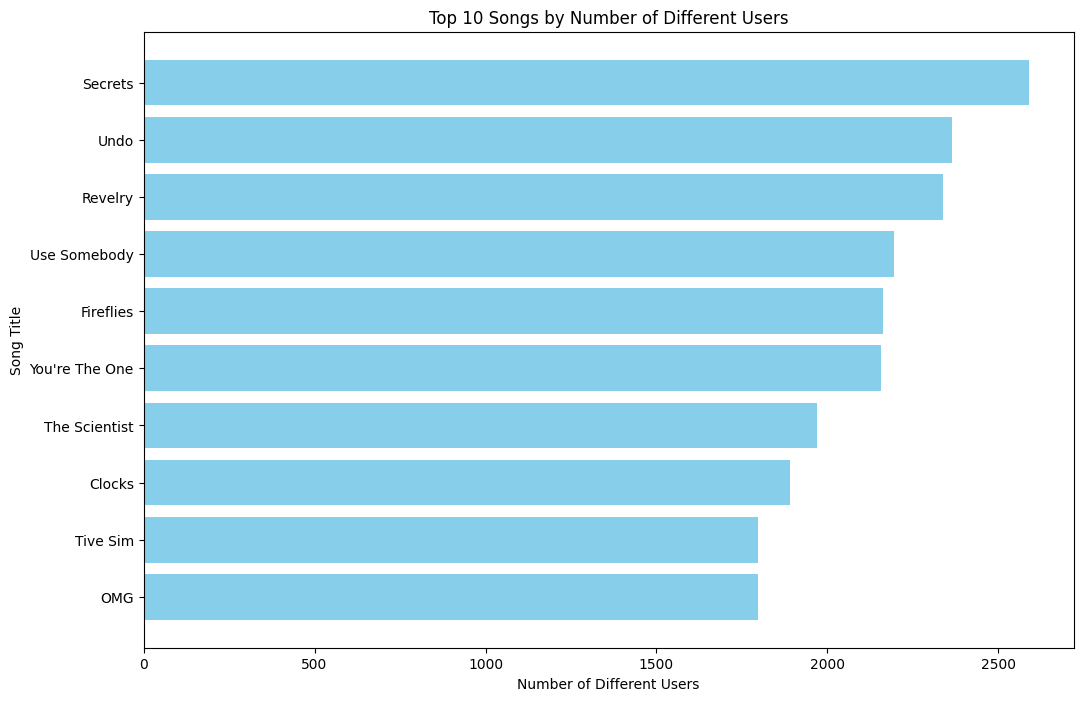

In [108]:
print("BEFORE")
# Call the function to plot the top 10 songs by number of users
plot_top_users_per_song(users_per_song_df_before)

print()

print("FINAL")
# Call the function to plot the top 10 songs by number of users
plot_top_users_per_song(users_per_song_df_final)

In [109]:
print("BEFORE")
max_users_list_before = [30, 60, 90, 120, 150, 200]
filtered_results_before = filter_songs_by_user_count(df_final_before_songs, max_users_list_before)

print()

print("FINAL")
max_users_list_final = [30, 60, 90, 120, 150, 200]
filtered_results_final = filter_songs_by_user_count(df_final, max_users_list_final)

BEFORE
There are 222 songs listened to by less than 30 users.
There are 8005 songs listened to by more than 30 users.

There are 3072 songs listened to by less than 60 users.
There are 5155 songs listened to by more than 60 users.

There are 5044 songs listened to by less than 90 users.
There are 3183 songs listened to by more than 90 users.

There are 6105 songs listened to by less than 120 users.
There are 2122 songs listened to by more than 120 users.

There are 6727 songs listened to by less than 150 users.
There are 1500 songs listened to by more than 150 users.

There are 7318 songs listened to by less than 200 users.
There are 909 songs listened to by more than 200 users.


FINAL
There are 0 songs listened to by less than 30 users.
There are 2122 songs listened to by more than 30 users.

There are 0 songs listened to by less than 60 users.
There are 2122 songs listened to by more than 60 users.

There are 0 songs listened to by less than 90 users.
There are 2122 songs listened t

BEFORE


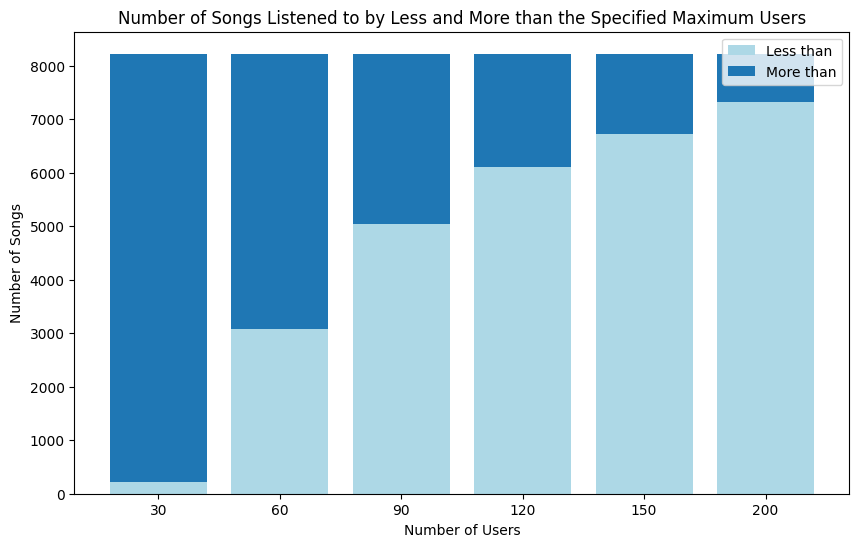


AFTER


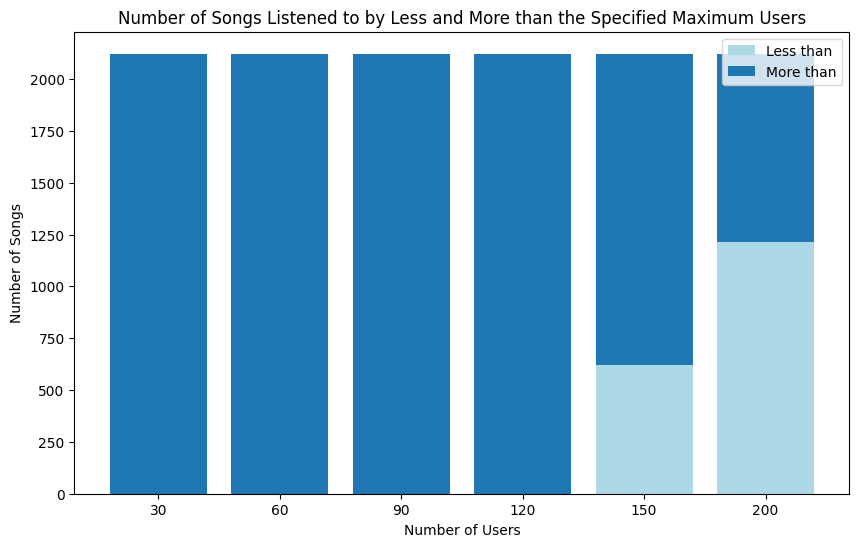

In [110]:
print("BEFORE")
# Call the plot function directly with filtered results
plot_song_counts_by_max_users(filtered_results_before)

print()

print("AFTER")
# Call the plot function directly with filtered results
plot_song_counts_by_max_users(filtered_results_final)



---



In [111]:
df_final_before_rating = df_final.copy()

### Dropping rating > 10

<b>

d. Rating system - we will limit the users to only those who have listened to each song no more than 10 times.

</b>

In [112]:
d = 10

- Before implementing our find, we will do some final research:

In [113]:
shape_before_dropping_d = df_final.shape
print("Shape of our df before dropping rating >", d, ":", shape_before_dropping_d)

# Sum the values in the 'listen_count' column
listen_count_before_dropping_d = df_final['listen_count'].sum()
print("Sum of all the listen count before dropping rating >", d, ":", listen_count_before_dropping_d)

different_song_count_before_dropping_d = df_final['song_id'].nunique()
print("Number of different songs before dropping dropping rating >", d, ":", different_song_count_before_dropping_d)

different_user_count_before_dropping_d = df_final['user_id'].nunique()
print("Number of different users before dropping dropping rating >", d, ":", different_user_count_before_dropping_d)

Shape of our df before dropping rating > 10 : (544534, 7)
Sum of all the listen count before dropping rating > 10 : 1515343
Number of different songs before dropping dropping rating > 10 : 2122
Number of different users before dropping dropping rating > 10 : 15762


In [114]:
# # Drop records with play_count more than(>) 5
# df_final = df_final[df_final.listen_count <= d]

In [115]:
def filter_users_by_listen_count(df, n):
    """
    Filter out users who have at least one row with 'listen_count' > n.

    Parameters:
        df (DataFrame): The DataFrame containing the song data.
        n (int): Maximum number of listens allowed for a song.

    Returns:
        DataFrame: Filtered DataFrame containing users who listened within the specified limit.
    """
    # Find users with at least one row where 'listen_count' exceeds n
    users_to_remove = df[df['listen_count'] > n]['user_id'].unique()

    # Filter the original DataFrame to exclude users found above
    filtered_df = df[~df['user_id'].isin(users_to_remove)]

    return filtered_df

In [116]:
df_final = filter_users_by_listen_count(df_final, d)

- By dropping rating > 5 we lose users who listened to a song more than 5 times. Moreover, we lose some songs that was listened to only by the users we dropped. <br>
Of course, the total number of listens became smaller. <br>
Here are the findings:

In [117]:
shape_after_dropping_d = df_final.shape
print("Shape of our df after dropping rating >", d, ":", shape_after_dropping_d)

# Sum the values in the 'listen_count' column
listen_count_after_dropping_d = df_final['listen_count'].sum()
print("Sum of all the listen count after dropping rating >", d, ":", listen_count_after_dropping_d)

different_song_count_after_dropping_d = df_final['song_id'].nunique()
print("Number of different songs after dropping dropping rating >", d, ":", different_song_count_after_dropping_d)

different_user_count_after_dropping_d = df_final['user_id'].nunique()
print("Number of different users after dropping dropping rating >", d, ":", different_user_count_after_dropping_d)

Shape of our df after dropping rating > 10 : (279989, 7)
Sum of all the listen count after dropping rating > 10 : 485558
Number of different songs after dropping dropping rating > 10 : 2122
Number of different users after dropping dropping rating > 10 : 8845


In [118]:
print("By dropping rating >", d, ", we reduced the amount of samples by:", shape_before_dropping_d[0] - shape_after_dropping_d[0])
print("By dropping rating >", d, ", we reduced the amount of listening by:", listen_count_before_dropping_d - listen_count_after_dropping_d)
print("By dropping rating >", d, ", we reduced the number of songs by:", different_song_count_before_dropping_d - different_song_count_after_dropping_d)
print("By dropping rating >", d, ", we reduced the number of users by:", different_user_count_before_dropping_d - different_user_count_after_dropping_d)

By dropping rating > 10 , we reduced the amount of samples by: 264545
By dropping rating > 10 , we reduced the amount of listening by: 1029785
By dropping rating > 10 , we reduced the number of songs by: 0
By dropping rating > 10 , we reduced the number of users by: 6917


In [119]:
print("BEFORE")
# Call the function to calculate the number of users per listen count
users_per_listen_count_df_before = calculate_users_per_listen_count(df_final_before_rating)

# Print the DataFrame
users_per_listen_count_df_before

BEFORE


,listen_count,num_users
0,1,15636
1,2,14714
2,3,11783
3,4,9021
4,5,8963
...,...,...
181,338,1
182,353,1
183,405,1
184,436,1


In [120]:
print("FINAL")
# Call the function to calculate the number of users per listen count
users_per_listen_count_df_final = calculate_users_per_listen_count(df_final)

# Print the DataFrame
users_per_listen_count_df_final

FINAL


,listen_count,num_users
0,1,8824
1,2,8194
2,3,6078
3,4,4199
4,5,4095
5,6,2533
6,7,1627
7,8,1090
8,9,776
9,10,820


BEFORE


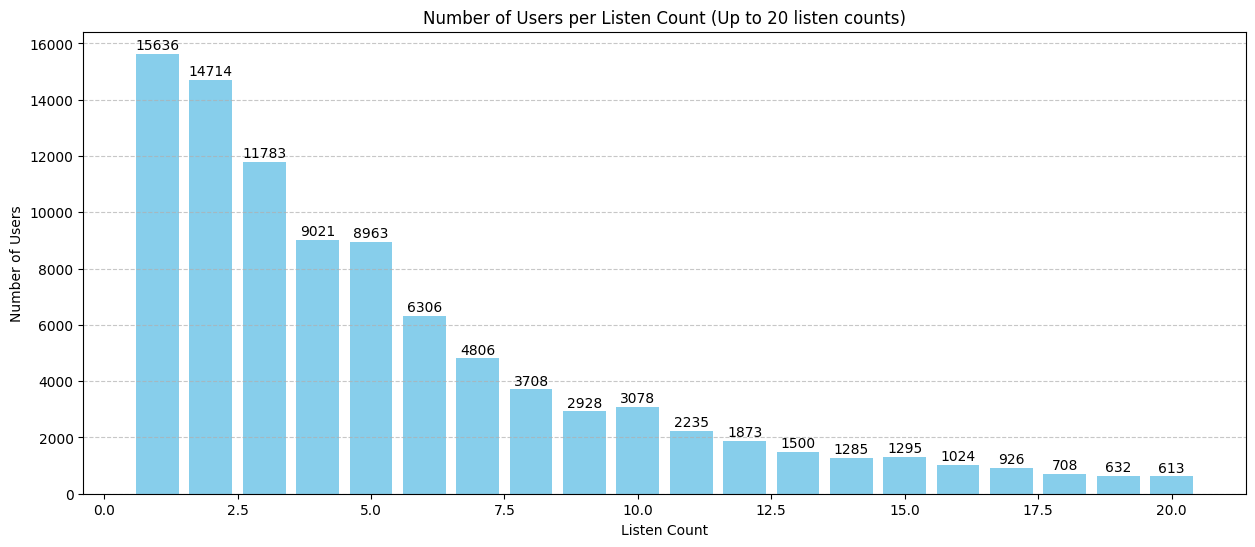


FINAL


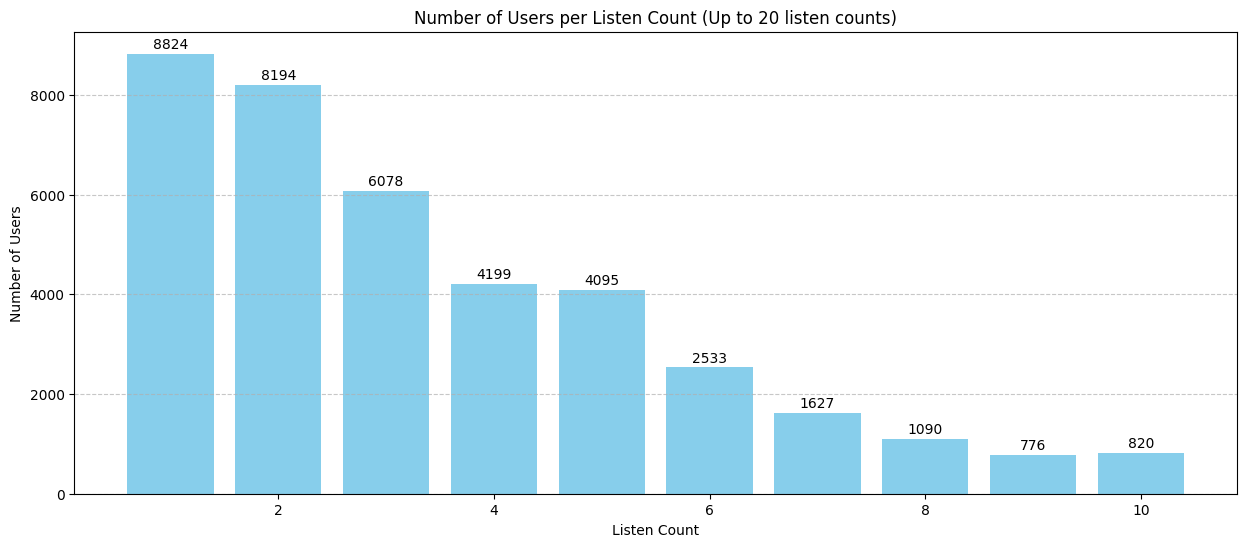

In [121]:
print("BEFORE")
# Call the function to plot the number of users per listen count for up to n listen counts
plot_users_per_listen_count(users_per_listen_count_df_before, n=20)

print()

print("FINAL")
# Call the function to plot the number of users per listen count for up to n listen counts
plot_users_per_listen_count(users_per_listen_count_df_final, n=20)

BEFORE
Number of users left for max listen count of 3: 2272
Number of users left for max listen count of 4: 3204
Number of users left for max listen count of 5: 4693
Number of users left for max listen count of 6: 5812
Number of users left for max listen count of 7: 6694
Number of users left for max listen count of 8: 7410
Number of users left for max listen count of 9: 8025
Number of users left for max listen count of 10: 8845
Number of users left for max listen count of 11: 9451
Number of users left for max listen count of 12: 9983
Number of users left for max listen count of 13: 10416
Number of users left for max listen count of 14: 10819
Number of users left for max listen count of 15: 11267


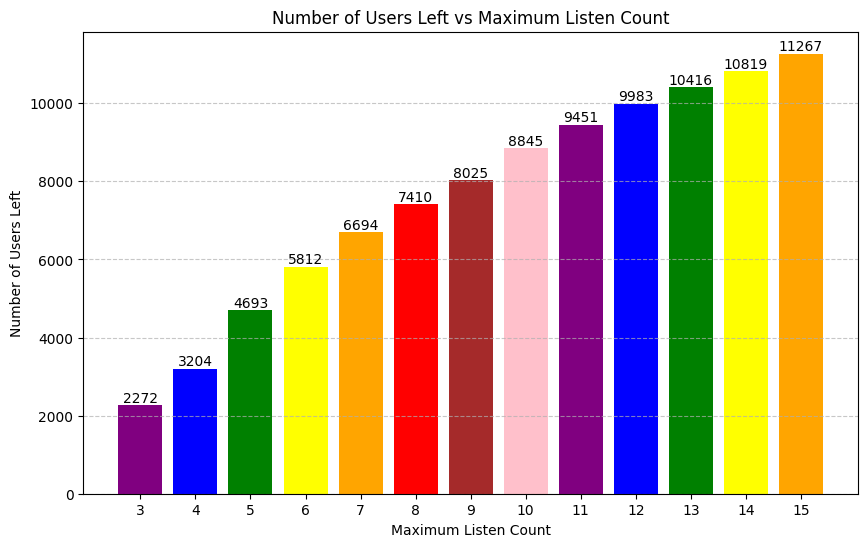


FINAL
Number of users left for max listen count of 3: 2272
Number of users left for max listen count of 4: 3204
Number of users left for max listen count of 5: 4693
Number of users left for max listen count of 6: 5812
Number of users left for max listen count of 7: 6694
Number of users left for max listen count of 8: 7410
Number of users left for max listen count of 9: 8025
Number of users left for max listen count of 10: 8845
Number of users left for max listen count of 11: 8845
Number of users left for max listen count of 12: 8845
Number of users left for max listen count of 13: 8845
Number of users left for max listen count of 14: 8845
Number of users left for max listen count of 15: 8845


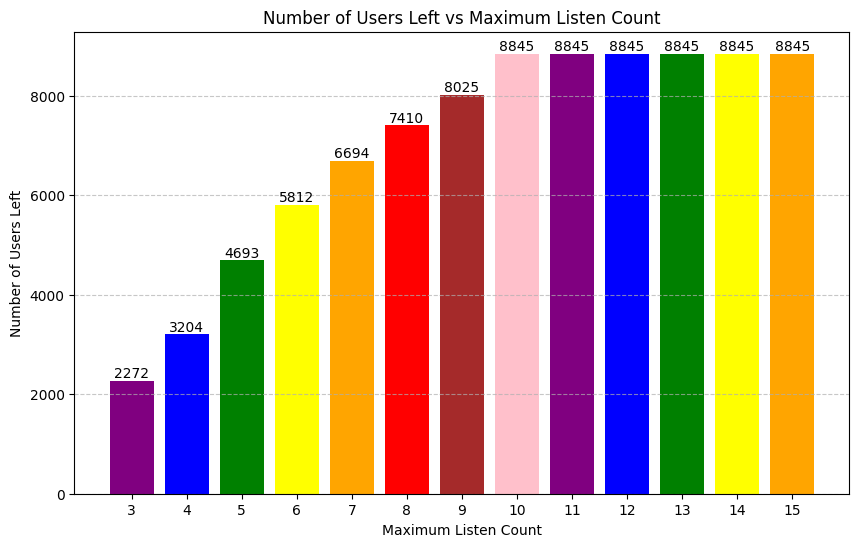

In [122]:
print("BEFORE")
# Call the function to check max listen counts from 3 to 15
filtered_df_before, ratings_before = filter_users_by_max_listen_count(df_final_before_rating, start_count=3, end_count=15)

# Plot the results
plot_users_left(ratings_before)

print()

print("FINAL")
# Call the function to check max listen counts from 3 to 15
filtered_df_final, ratings_final = filter_users_by_max_listen_count(df_final, start_count=3, end_count=15)

# Plot the results
plot_users_left(ratings_final)

BEFORE


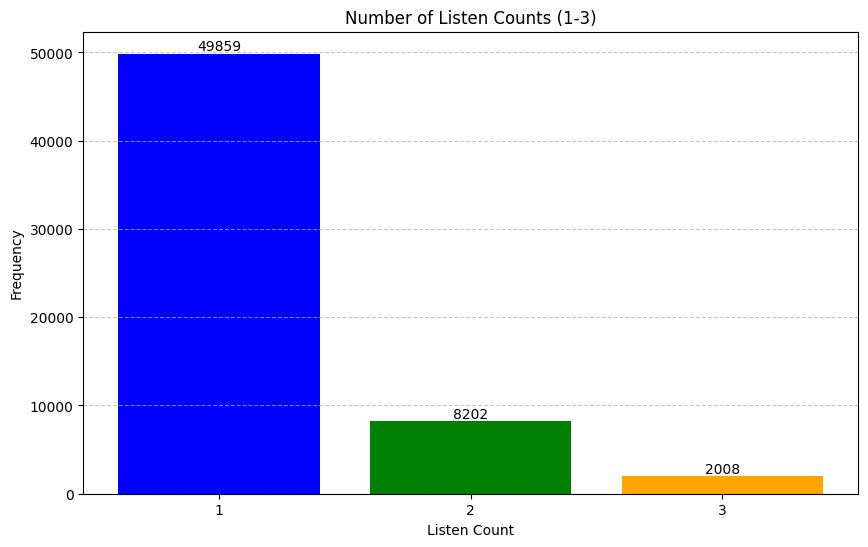

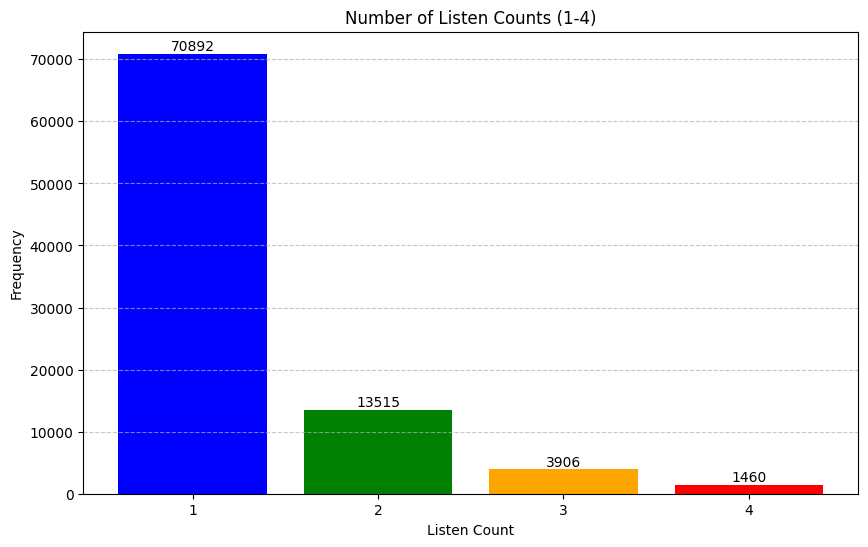

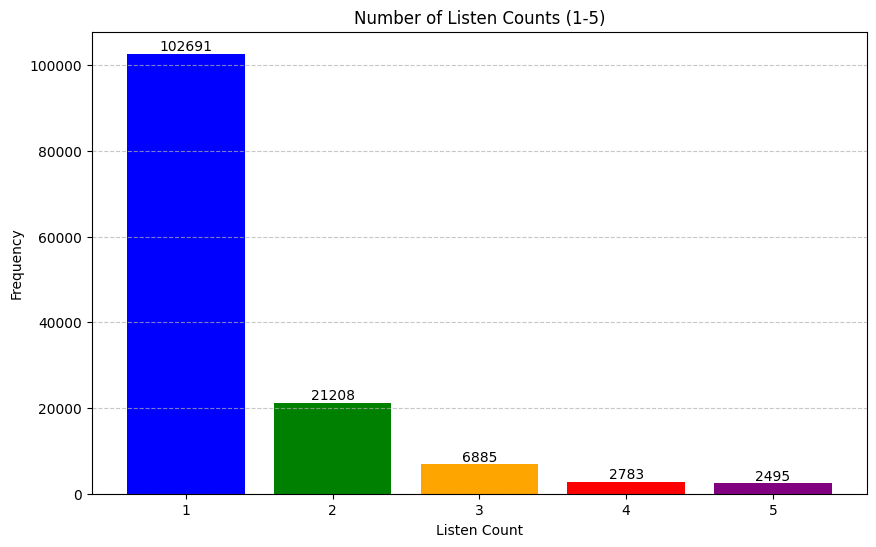

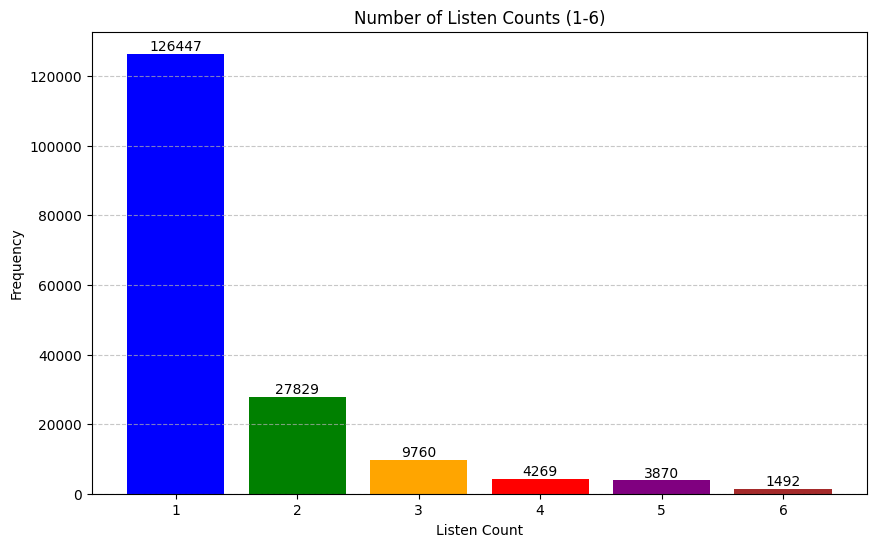

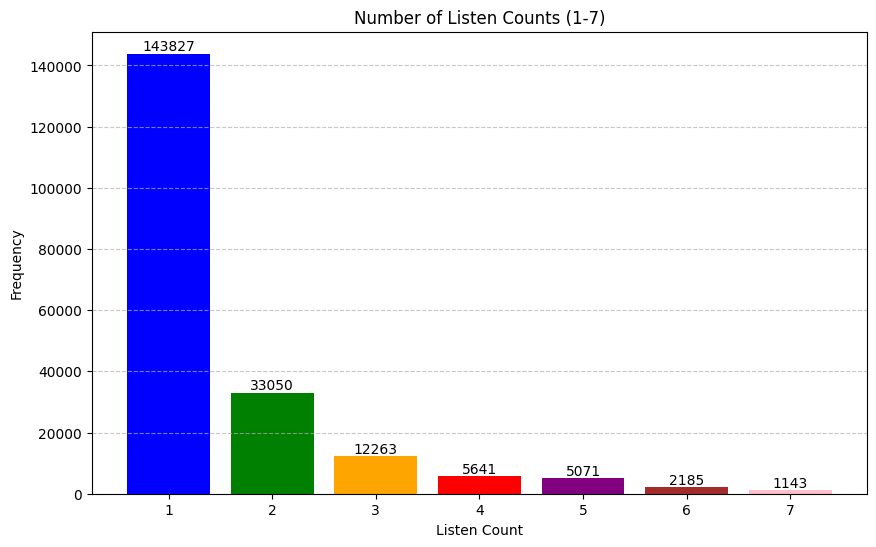

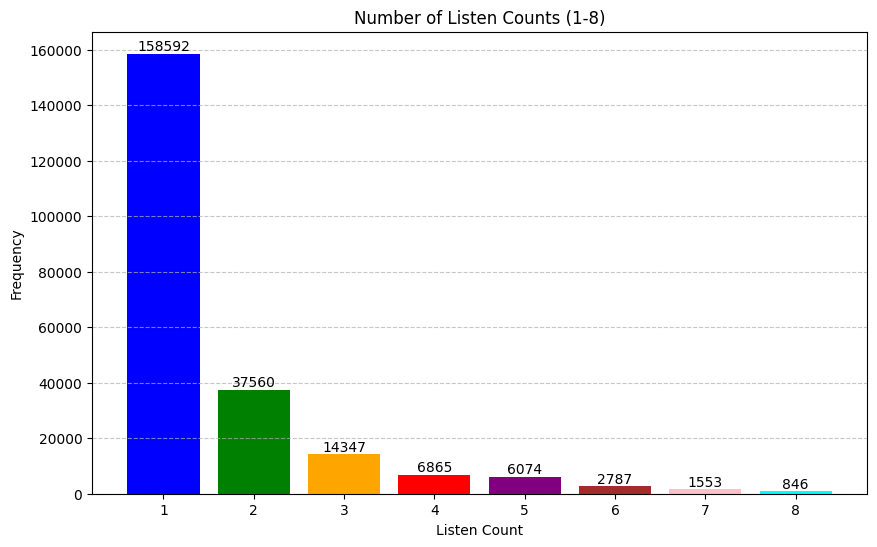

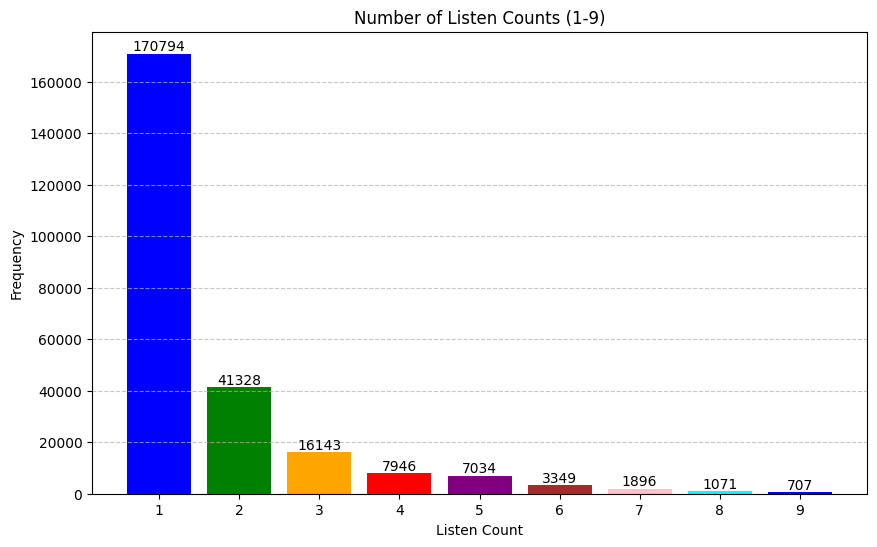

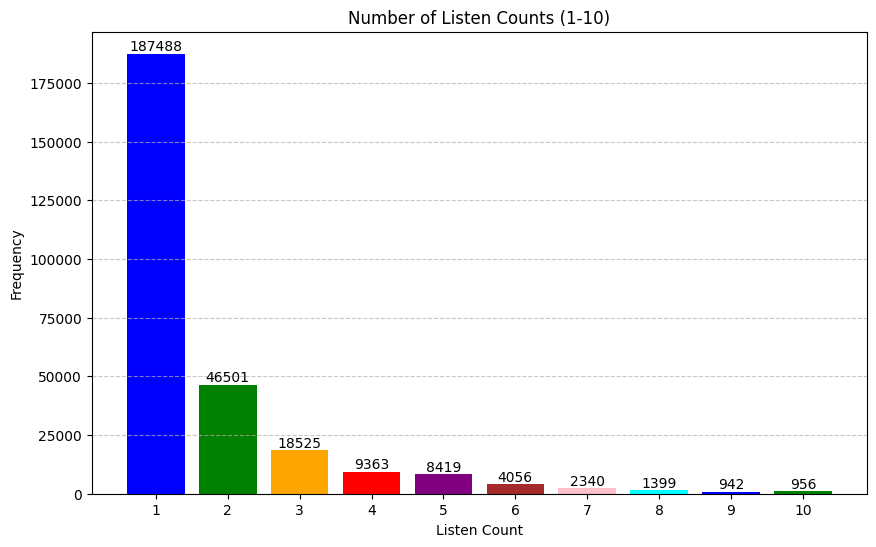

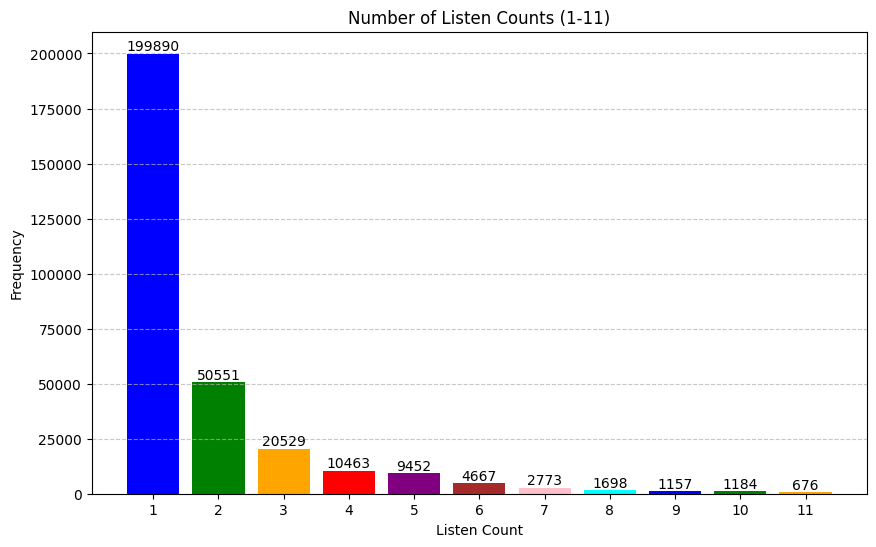

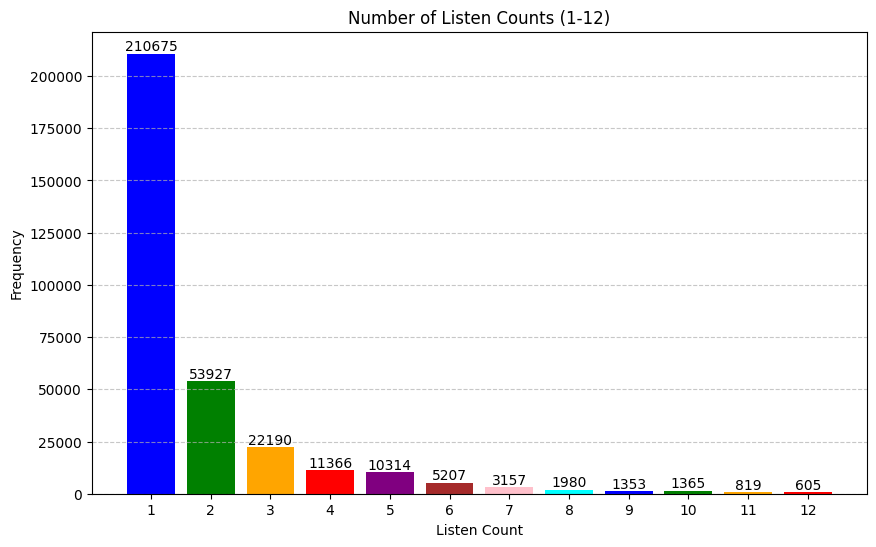

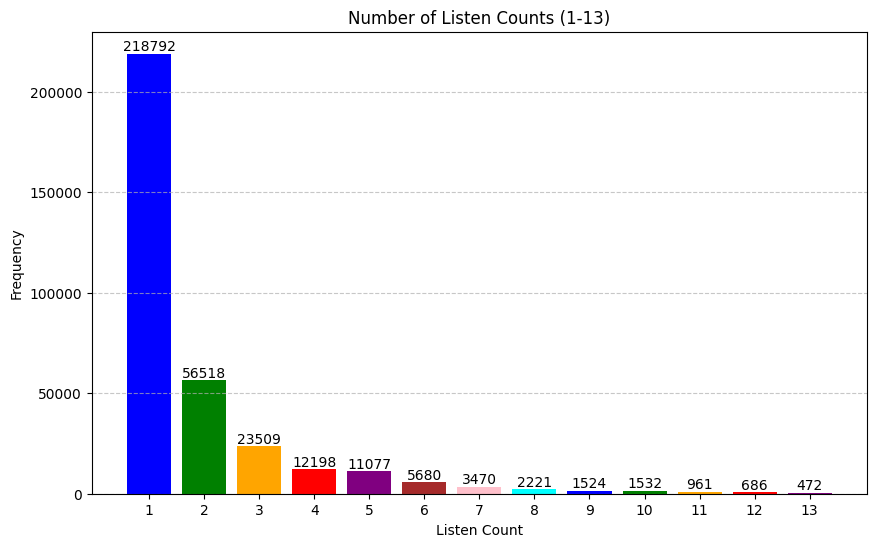

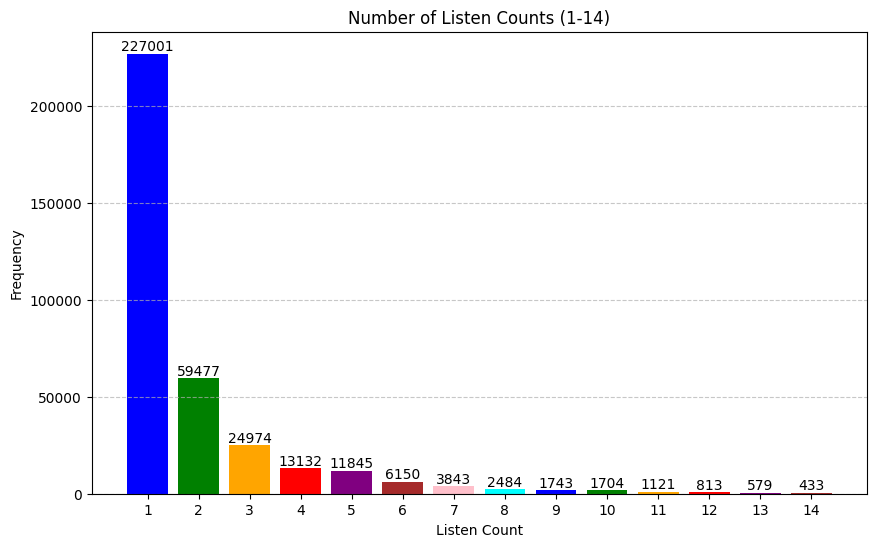

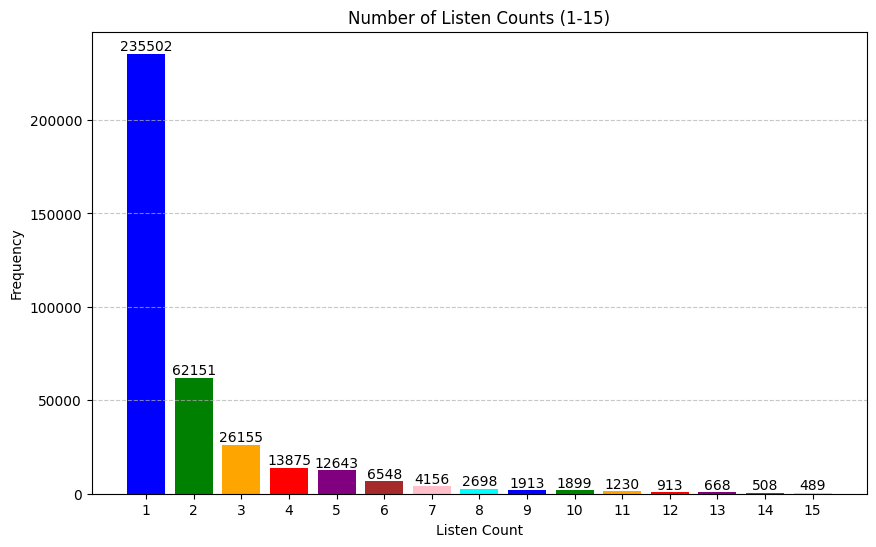


AFTER


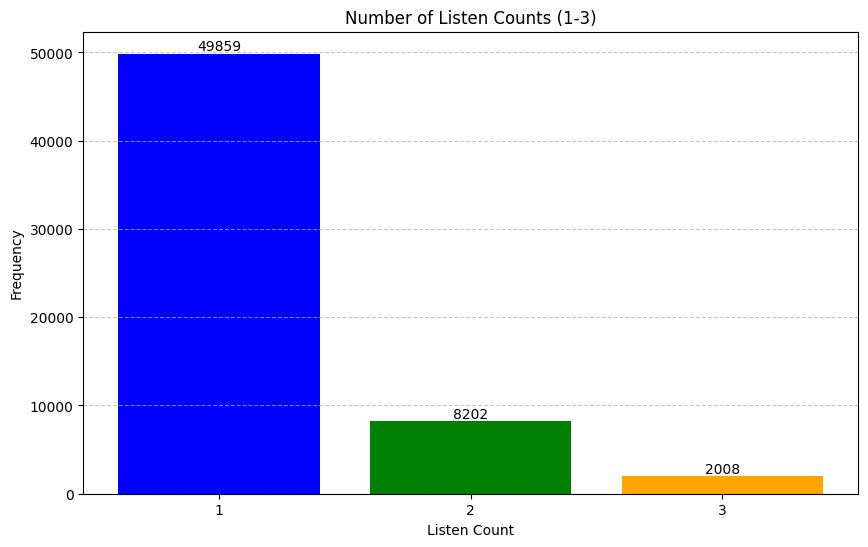

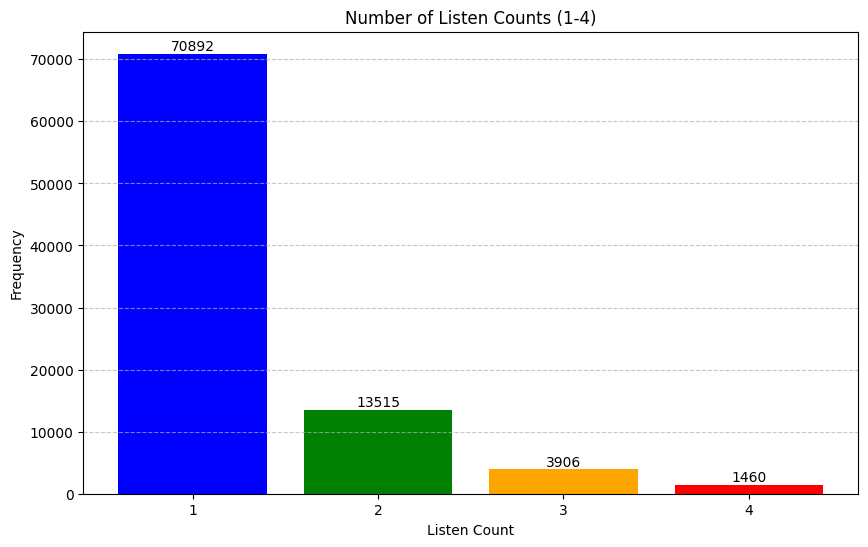

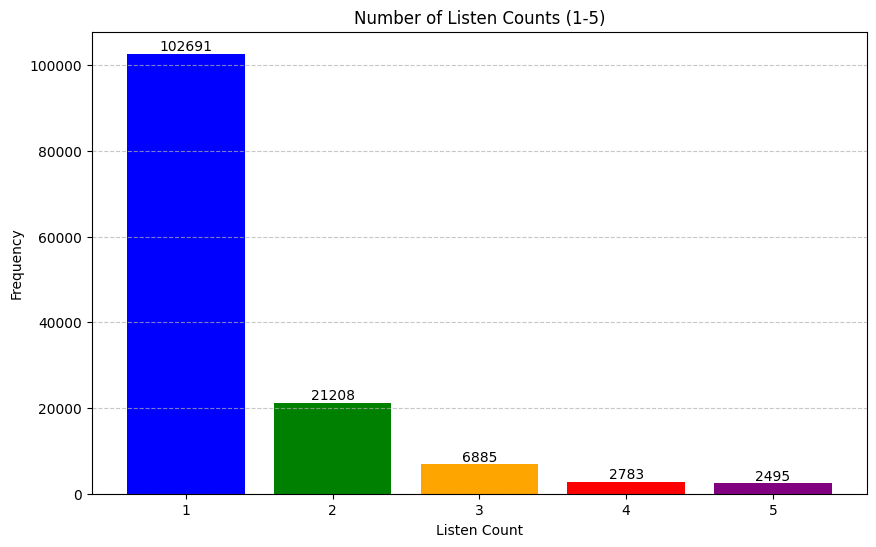

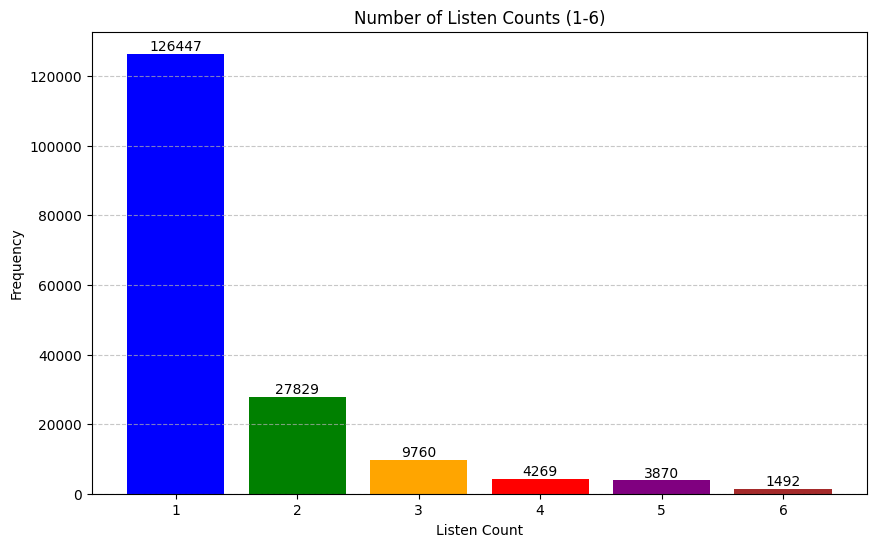

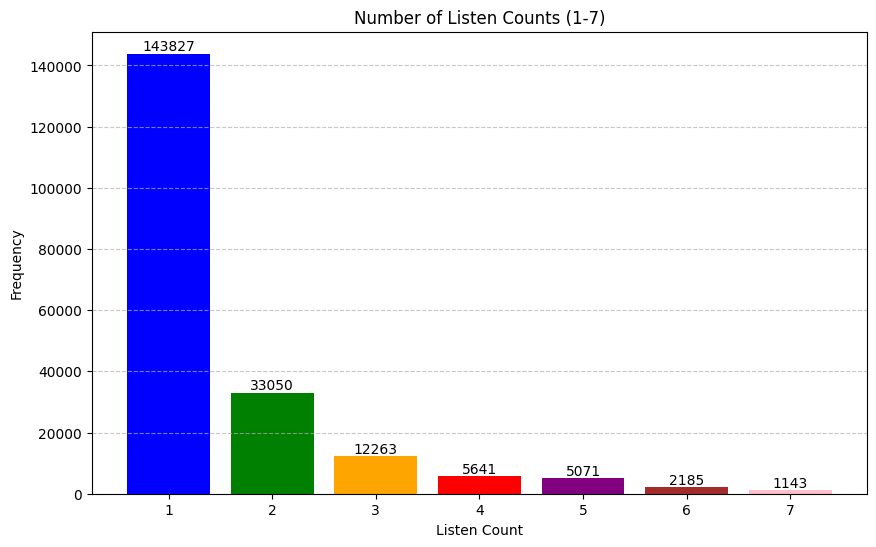

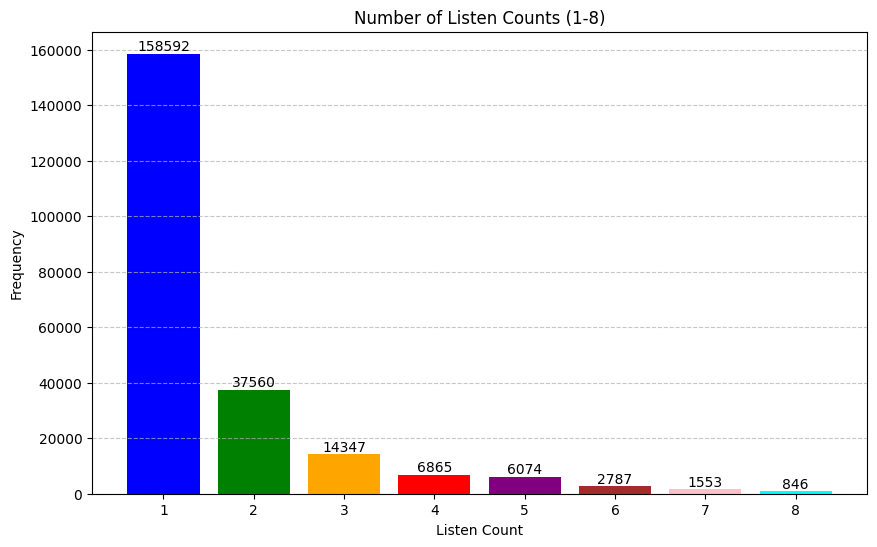

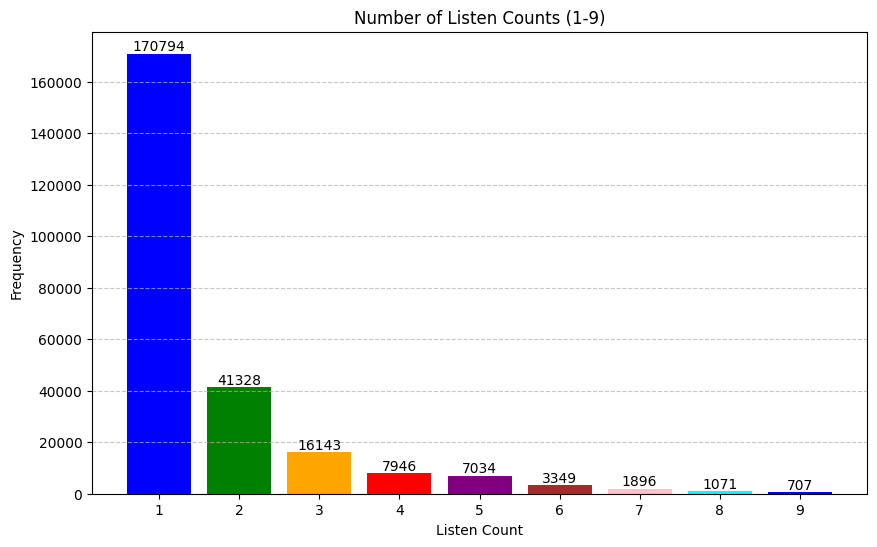

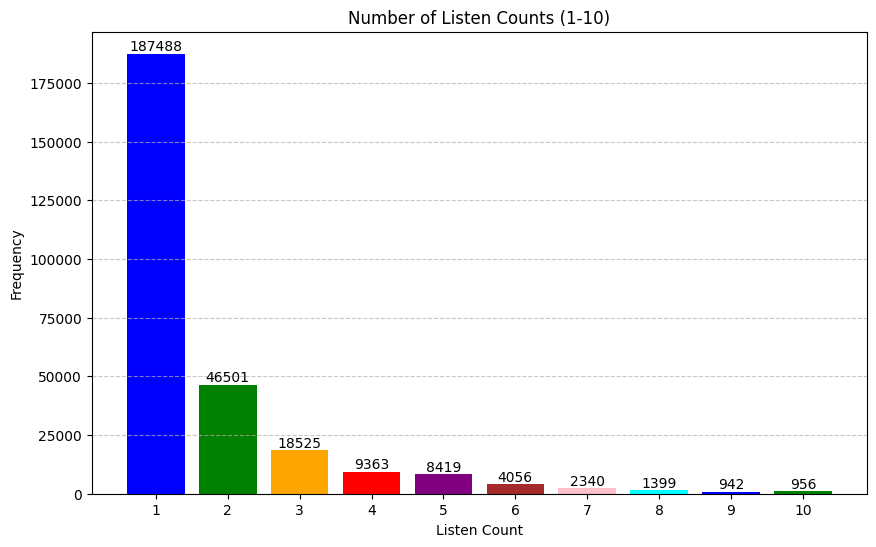

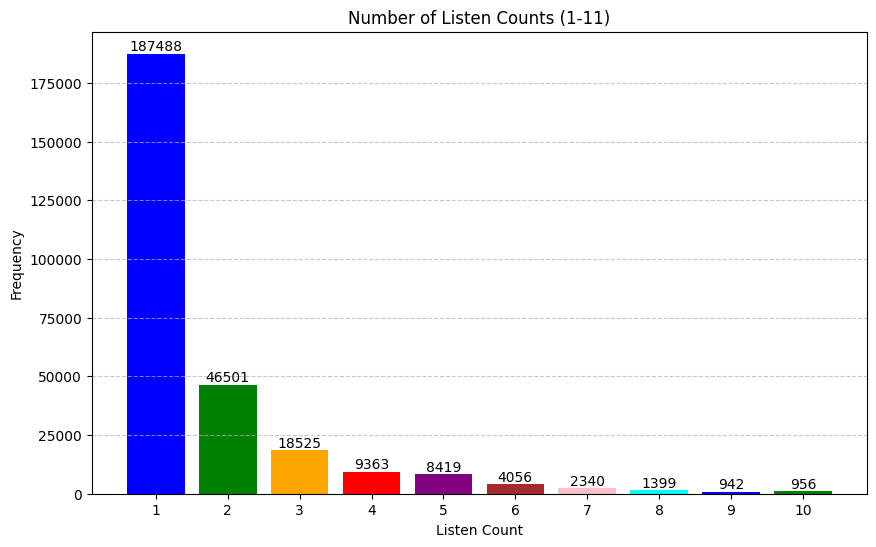

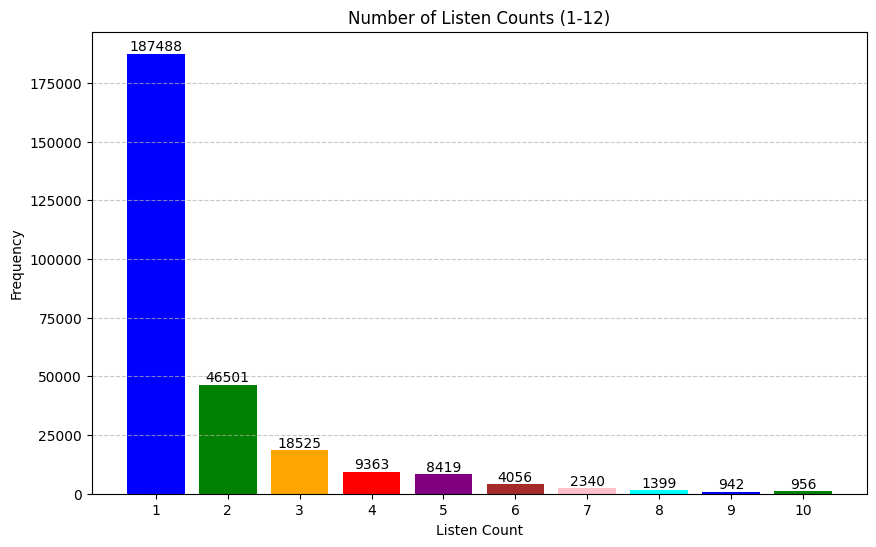

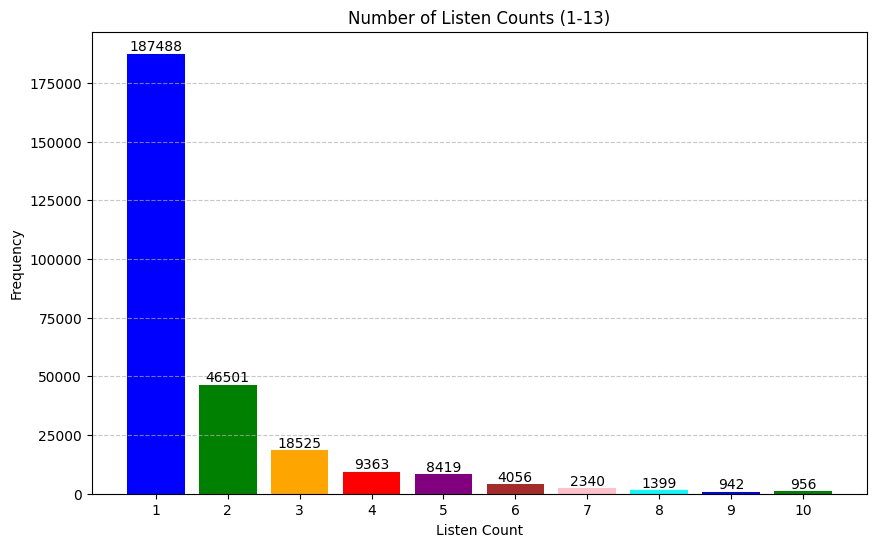

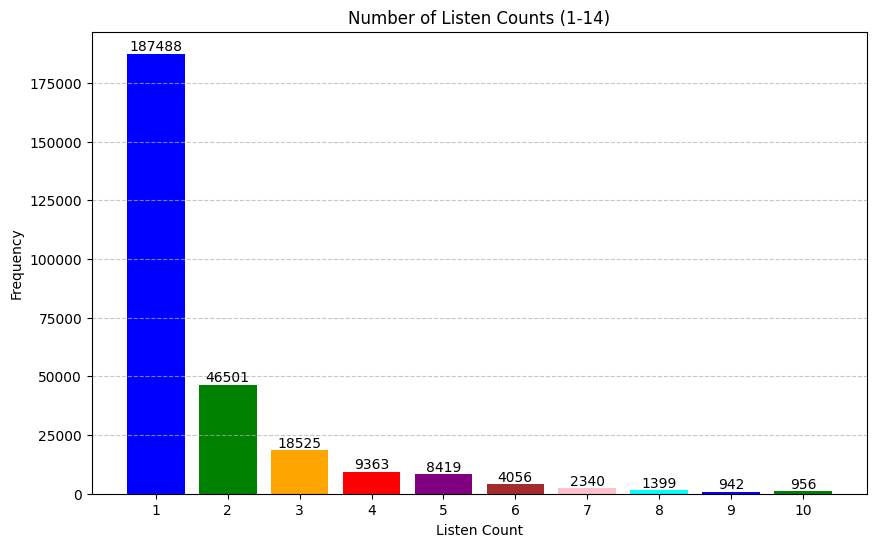

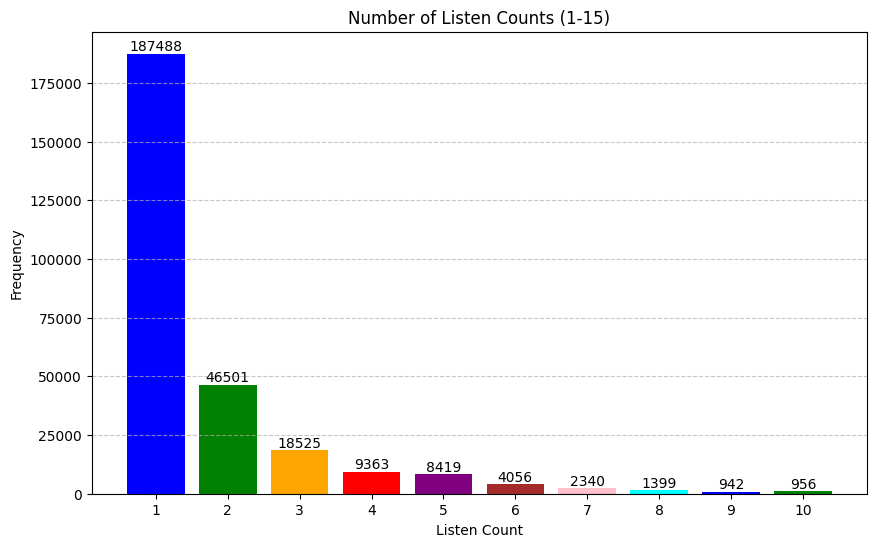

In [123]:
print("BEFORE")
# Call the function with start_count=3 and end_count=15
plot_listen_counts_range(df_final_before_rating, start_count=3, end_count=15)

print()

print("AFTER")
# Call the function with start_count=3 and end_count=15
plot_listen_counts_range(df_final, start_count=3, end_count=15)

TODO Fix df

In [124]:
df_final.reset_index(inplace=True)

TODO check whether index col is need and if the reset_index is needned (maybe this is what creates the index col)

In [125]:
df_final

,index,user_id,song_id,listen_count,title,release,artist_name,year
0,2,54752,605,1,Stronger,Graduation,Kanye West,2007
1,3,54752,618,1,Constellations,In Between Dreams,Jack Johnson,2005
2,4,54752,972,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
3,6,54752,1252,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
4,12,54752,3091,1,Love Shack,Original Hits - Rock,The B-52's,1989
...,...,...,...,...,...,...,...,...
279984,1999992,64343,2648,1,That Should Be Me,My Worlds,Justin Bieber,2010
279985,1999994,64343,2767,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
279986,1999996,64343,3051,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
279987,1999997,64343,3059,3,What I've Done (Album Version),What I've Done,Linkin Park,2007


# TODO - ToDel - Full function section


TODO - this section we be redone (We will probably remove it and put it somewhere else with changes in functions. Some are not relevant)!!!!!

TODO - this section we be redone!!!!!

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

In [126]:
# # ========== Function precision_recall_at_k ==========
# def precision_recall_at_k(model, k=10, threshold=1, verbose=True):
#     """
#     A function to calculate rmse, precision, recall, and F1_score, at k.
#     This function is adapted from the one in the Surprise library.
#     Params:
#       model: the model to be used for predictions
#       k: the number of relevant items to be considered (top k)
#       threshold: the minimum value that a rating should satisfy to be relevant
#       verbose: Bool, determines the way to display the results
#     Returns:
#       [rmse, recall, precision, f1_score]
#         verbose=True: displays the list containing the 4 metrics
#         verbose=False: returns a list with the 4 metrics.
#           This is useful when experimenting with various values for (k, threshold).

#     """

#     # First map the predictions to each user.
#     user_est_true = defaultdict(list)

#     # Making predictions on the test data.
#     predictions = model.test(testset)

#     for uid, _, true_r, est, _ in predictions:
#         user_est_true[uid].append((est, true_r))

#     precisions = dict()
#     recalls = dict()
#     for uid, user_ratings in user_est_true.items():

#         # Sort user play counts by estimated value.
#         user_ratings.sort(key=lambda x : x[0], reverse=True)

#         # Number of relevant items
#         n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

#         # Number of recommended items in top k
#         n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

#         # Number of relevant and recommended items in top k
#         n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
#                               for (est, true_r) in user_ratings[ : k])

#         # Precision@K: Proportion of recommended items that are relevant
#         # When n_rec_k is 0, Precision is undefined. Here, we set Precision to 0 when n_rec_k is 0

#         precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

#         # Recall@K: Proportion of relevant items that are recommended
#         # When n_rel is 0, Recall is undefined. Here, we set Recall to 0 when n_rel is 0

#         recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

#     # Mean of all the predicted precisions are calculated
#     precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

#     # Mean of all the predicted recalls are calculated
#     recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

#     rmse = round(accuracy.rmse(predictions, verbose=False), 3)

#     f1_score = round((2 * precision * recall) / (precision + recall), 3)

#     if verbose:
#         return print(clr.S+'rmse: {}, recall: {}, precision: {}, f1_score: {}'.format(rmse, recall, precision, f1_score)+clr.E)
#     else:
#         return [rmse, recall, precision, f1_score]

# # ========== Function get_songs_played_by_user ==========
# def get_songs_played_by_user(user, data):
#     """
#     Returns all the songs played by a user.
#     Params:
#         user: user_id
#         data: the dataframe with the data
#     Returns:
#         An array with all the song_ids of the songs user_id listened to.
#     TODO: it can be easily updated to generalize the interaction between a user and items.
#     Add an additional param item='song_id', and change the return condition.
#     """
#     return data[data['user_id'] == user]['song_id'].unique()

# # ========== Function get_songs_not_played_by_user ==========
# def get_songs_not_played_by_user(user, data):
#     """
#     Returns all the songs not played by a user.
#     Params:
#         user: user_id
#         data: the dataframe with the data
#     Returns:
#         An array with all the song_ids of the songs user_id had not listened to.
#     TODO: it can be easily updated to generalize the interaction between a user and items.
#     Add an additional param item='song_id', and change the return condition.
#     """
#     return data[~data['song_id'].isin(get_songs_played_by_user(user))]['song_id'].unique()

# # ========== Function played_count_predict ==========
# def play_count_predict(algo, user, song, r_ui=None):
#     """
#     A function that uses algo, to predict the rating for a song, by user.
#     Args:
#         algo: the algorithm used for prediction
#         user: the user_id
#         song: the song_id
#         r_ui: play_count, if it exists
#     Returns:
#         A formatted display of the results of the prediction method.
#     """

#     r_ui = algo.predict(user, song, r_ui=r_ui).r_ui
#     est = round(algo.predict(user, song).est, 2)
#     return print(clr.S+'Displaying the predictions for user {} and song {}.\n\n- Real prediction: {},\n- Estimated prediction: {}.'
#                  .format(user, song, r_ui, est)+clr.E)

# # ========== Function display_best_params ==========
# def display_best_params(model):
#     """
#     Function to display the best RMSE and values of the hyper-parameters, following a Grid/Randomized search.
#     Args:
#         model: the model used
#     Returns:
#     """
#     print(clr.S+'RMSE of the best option: {}'.format(round(model.best_score['rmse'], 3))+clr.E)
#     print(clr.S+'The hyperparameters of the best option: {}'.format(model.best_params['rmse'])+clr.E)

# # ========== Function get_recommendations ==========
# def get_recommendations(data, user, n, algo):
#     """
#     Function to get the top_n recommendations for a user.
#     Params:
#         data: the DataFrame with user-item information
#         user: the ID of the user for which we generate recommendations
#         n: the upper limit of the recommendations we are making
#         algo: the algorithm used for recommendations
#     Returns:
#         A list of the top_n items recommended to the user.
#     """
#     # Creating an empty list to store the recommended song IDs.
#     recommendations = []

#     # Creating an user-item interactions matrix.
#     user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='play_count')

#     # Extracting those song IDs that the user_id has not listened to yet.
#     non_listened_songs = user_item_interactions_matrix.loc[user][user_item_interactions_matrix.loc[user].isnull()].index.tolist()

#     # Looping through each of the song IDs that user_id has not listened to yet.
#     for item_id in non_listened_songs:

#         # Predicting the play_count for those songs not listened to by this user.
#         est = round(algo.predict(user, item_id).est, 2)

#         # Appending the predicted play_counts.
#         recommendations.append((item_id, est))

#     # Sorting the predicted play_counts in descending order.
#     recommendations.sort(key = lambda x: x[1], reverse=True)

#     # Returing top n highest predicted play_counts for this user.
#     return recommendations[:n]

# # ========== Function get_users_who_played_song ==========
# def get_users_who_played_song(song, data):
#     """
#     data=df_final
#     Returns all the users who listened to the song.
#     Params:
#         song: song_id
#         data: the dataframe with the data
#     Returns:
#         An array with all the user_ids of the users who listened to the song.
#     TODO: it can be easily updated to generalize the interaction between a user and items.
#     Add an additional param item='user_id', and change the return condition.
#     """
#     return data[data['song_id'] == song]['user_id'].unique()

# # ========== Function get_users_who_did_not_played_song ==========
# def get_users_who_did_not_played_song(song, data):
#     """
#     Returns all the users who did not listened to the song.
#     Params:
#         song: song_id
#         data: the dataframe with the data
#     Returns:
#         An array with all the user_ids of the users who had not listened to the song.
#     TODO: it can be easily updated to generalize the interaction between a user and items.
#     Add an additional param item='user_id', and change the return condition.
#     """
#     return data[~data['user_id'].isin(get_users_who_played_song(song, data=data))]['user_id'].unique()

# # ========== Function ==========

# Recommendation system models & algorithms workflow

TODO: ADD THe WORKFLOW

* After working on the data and the pre-processing, he approached the models of the recommendation system. Each model is based on a different algorithm.
* We will use a few diffrent approach, trying a few models and then will compare between them.
The models we will use :    
1. Rank - Based (Popularity) Model  
2. Collaborative - Filtering
  - Similarity / Neighborhood - based
    - User - User
    - Item - Item
  - Matrix Factorization
3. Cluster - Based
4. Content - Based


# Rank-based (Popularity)

* In this model, songs that are frequently listened to or have high listen counts are ranked higher and recommended to users.

* This model does not take into account the individual preferences or tastes of users. Instead, it focuses on recommending songs that are popular among a large group of users.

* Here there is no need for train-test splitting because rank-based recommendation systems typically do not involve complex model training or parameter optimization. Instead, they rely on simple ranking or popularity metrics to provide recommendations.

In [127]:
# Calculating the average of listen_count :
avg_count = df_final.groupby('song_id')['listen_count'].mean()
# Calculating the frequency each song was listened
sum_count = df_final.groupby('song_id')['listen_count'].sum()

In [128]:
# Creating dataframe with : avg_count and sum_count
rb_popular = pd.DataFrame({'avg_count': avg_count,'sum_count': sum_count})
# Descending order, by the average counts a song was listened.
rb_popular = rb_popular.sort_values(by='avg_count', ascending=False)
# Reset index to turn "song_id" into a column
rb_popular.reset_index(inplace=True)
# Let us see the first five records of the rb_popular dataset
rb_popular.head()

,song_id,avg_count,sum_count
0,5948,3.808696,438
1,6841,3.782609,174
2,4869,3.489362,164
3,1394,3.188679,169
4,5493,3.185185,258


In [129]:
# Calculate descriptive statistics for rb_popular excluding the 'song_id' row
rb_popular_description = rb_popular.drop('song_id', axis=1).describe()

# Show the descriptive statistics
rb_popular_description

,avg_count,sum_count
count,2122.000000,2122.000000
mean,1.726119,228.820924
std,0.355207,214.067254
min,1.101852,63.000000
25%,1.462051,128.000000
50%,1.693309,169.000000
75%,1.927704,238.000000
max,3.808696,2770.000000


Let's define a function that findss the top n songs for a recommendation based on their average listen counts. <br> Additionally, we'll include a threshold for the minimum number of listen counts a song must have to be considered for recommendation.

In [130]:
def top_n_songs(rb_popular, n, min_interaction=200):
    # Finding songs with a minimum number of interactions
    recommendations = rb_popular[rb_popular['sum_count'] >= min_interaction]

    # Sorting songs based on their average listen_count in descending order
    recommendations = recommendations.sort_values(by='avg_count', ascending=False)

    # Return the song IDs of the top n songs
    return recommendations['song_id'].head(n)


In [131]:
# Get the song IDs of the top 10 songs
top_n_song_ids = top_n_songs(rb_popular, 10)

# Filter rb_popular to include only the top N songs
top_n_songs_df = rb_popular[rb_popular['song_id'].isin(top_n_song_ids)]

# Print the DataFrame with the required format
top_n_songs_df

,song_id,avg_count,sum_count
0,5948,3.808696,438
4,5493,3.185185,258
5,7385,3.120482,259
7,5651,3.089109,624
9,4123,3.030303,200
10,502,2.985621,2284
12,4617,2.893204,596
14,253,2.866890,2563
15,3666,2.823529,240
16,6863,2.797619,235


In [132]:
# Find the indices of the top 10 songs
top_n_song_indices = top_n_songs(rb_popular, 10)
top_n_song_indices

0     5948
4     5493
5     7385
7     5651
9     4123
10     502
12    4617
14     253
15    3666
16    6863
Name: song_id, dtype: int64

In [133]:
def get_song_info(song_ids, df_final):
    # Define a list to store the selected rows
    selected_songs = []

    # Iterate over each song_id in the list of song_ids
    for song_id in song_ids:
        # Filter df_final to include only the rows corresponding to the current song_id
        song_data = df_final[df_final['song_id'] == song_id]

        # Extract the required columns and append to the list
        selected_songs.append(song_data[['song_id', 'title', 'release', 'artist_name', 'year']].iloc[0])

    # Create a DataFrame from the selected songs
    selected_songs_df = pd.DataFrame(selected_songs)

    return selected_songs_df

In [134]:
selected_songs_df = get_song_info(top_n_song_indices, df_final)

In [135]:
# Merge selected_songs_df and rb_popular by song_id
top_10_info = pd.merge(selected_songs_df, rb_popular, on='song_id', how='inner')

# show the merged DataFrame
top_10_info

,song_id,title,release,artist_name,year,avg_count,sum_count
0,5948,Victoria (LP Version),Hit By A Train: The Best Of Old 97's,Old 97's,2006,3.808696,438
1,5493,Silent Lucidity (2002 Digital Remaster),Empire,Queensryche,1990,3.185185,258
2,7385,Verde Que Te Quero Rosa,Verde Que Te Quero Rosa,Cartola,1977,3.120482,259
3,5651,Mercy:The Laundromat,Westing (By Musket and Sextant),Pavement,1993,3.089109,624
4,4123,Alley Oop (Girls Version) (2007 Digital Remaster),The Doughnut In Granny's Greenhouse,The Bonzo Dog Band,1968,3.030303,200
5,502,You're The One,If There Was A Way,Dwight Yoakam,1990,2.985621,2284
6,4617,Transparency,Workout Holiday,White Denim,2008,2.893204,596
7,253,Undo,Vespertine Live,Björk,2001,2.866890,2563
8,3666,#40,Listener Supported,DAVE MATTHEWS BAND,1999,2.823529,240
9,6863,The Big Gundown,Invaders Must Die Remixes and Bonus Tracks,The Prodigy,2009,2.797619,235


Seems like there is a mix of different release years, and popularity levels among the songs. <br> For example, "Victoria (LP Version)" by Old 97's is from 2006 and has an average listen count of 3.37, indicating it is quite popular. <br> And "Heaven Must Be Missing An Angel" by Tavares is from 1979 with a lower average listen count of 2.21, showing that older songs can still be popular among listeners. <br> This suggests that music preferences are diverse and not solely based on release year or genre.

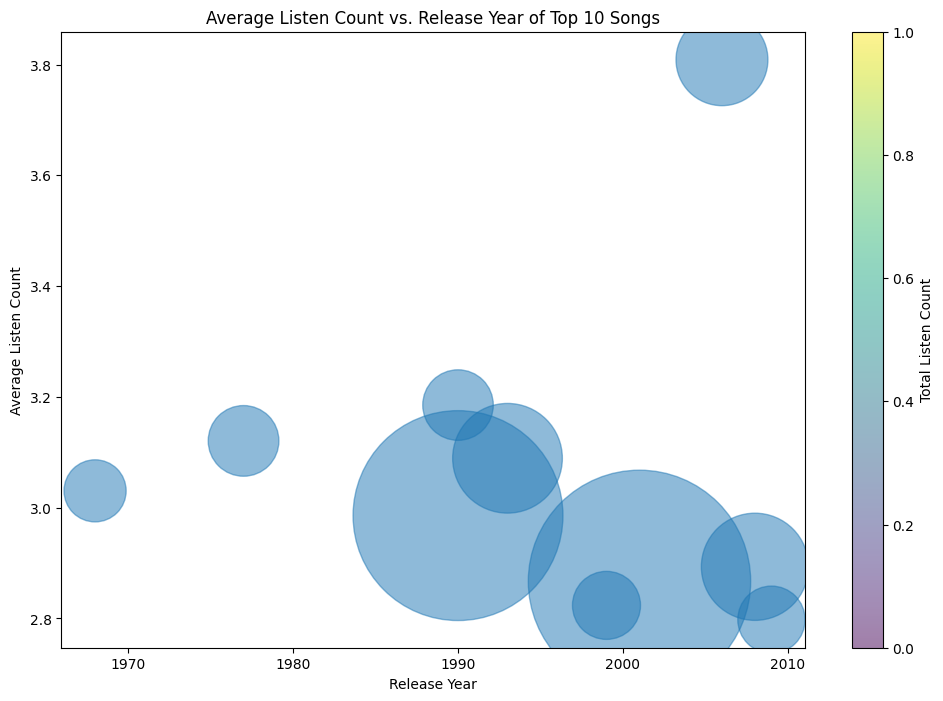

In [136]:
# Plotting the TOP 10 SONGS

# X-axis (Release Year): Each point on the x-axis represents the release year of a song.

# Y-axis (Average Listen Count): The y-axis shows the average listen count for each song.

# Point Size: The size of each point is determined by the total listen count of the song.
# Larger points indicate songs that have been listened to more frequently.

# Color: The color of each point also represents the total listen count,
# with darker colors indicating songs with higher total listen counts.

plt.figure(figsize=(12, 8))
plt.scatter(top_10_info['year'], top_10_info['avg_count'], s=top_10_info['sum_count']*10, alpha=0.5, cmap='viridis')
plt.title('Average Listen Count vs. Release Year of Top 10 Songs')
plt.xlabel('Release Year')
plt.ylabel('Average Listen Count')
plt.colorbar(label='Total Listen Count')
plt.show()


# Importing recommendation system package

* **Surprise** - Surprise is one of the “scikit-based Python” libraries to develop recommender systems using explicit rating data. This package allows building and evaluating recommender systems, offering a range of collaborative filtering algorithms and evaluation metrics. Surprise provides several algorithms to develop collaborative filtering recommender systems, starting from memory-based method (i.e. KNN) to model-based method (i.e. Singular Value Decomposition or SVD).
* Here is its documentation: [surprise](https://surpriselib.com/)

TODO explain more

In [137]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162739 sha256=7267426e48e352360cb3d41e6bbc607ae29ba65c141c317225bc9d8a490050ce
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [138]:
# Import the necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV, RandomizedSearchCV

# For splitting the data in train and test dataset TODO remove!
from surprise.model_selection import train_test_split as surprise_split

# The regular split TODO remove name if surprise was removed
from sklearn.model_selection import train_test_split as sk_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

# Preparing the data for modeling


Here we want to make sure that our data is arranged properly:
* In the following models we will use the surprise library which deals with explicit ranking data, for this reason we need to make sure that our data is divided by "rankings".

*   **Reader** - class in the Surprise package is used to parse raw data files or dataframes into a format suitable for collaborative filtering algorithms, specifying the expected rating scale of the data.
*    **Generate a rating scale** - In order to create a semblance of a rating system, we have restricted our data to users that have listened to a song at most 5 times. In this way, listen_count can be used as a rating system, with values between 1 and 5.
*    **data** - we will convert our dataset into a Dataset object from the Surprise library, and use the Reader object to be able to parse the DataFrame. The oder should be: user ID, item ID, and rating (This is also the  relevant dataset).
*    **Splitting the data** - class in the Surprise package that randomly dividing the interactions (in the data) while preserving the user-item relationships.

In [208]:
df_final = df_final.drop('index', axis=1) # TODO FIX ITTT

In [209]:
df_final

,user_id,song_id,listen_count,title,release,artist_name,year,text
0,54752,605,1,Stronger,Graduation,Kanye West,2007,Stronger Graduation Kanye West
1,54752,618,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations In Between Dreams Jack Johnson
2,54752,972,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly There Is Nothing Left To Lose Foo...
3,54752,1252,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008,Paper Gangsta The Fame Monster Lady GaGa
4,54752,3091,1,Love Shack,Original Hits - Rock,The B-52's,1989,Love Shack Original Hits - Rock The B-52's
...,...,...,...,...,...,...,...,...
279984,64343,2648,1,That Should Be Me,My Worlds,Justin Bieber,2010,That Should Be Me My Worlds Justin Bieber
279985,64343,2767,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003,Unwell (Album Version) More Than You Think You...
279986,64343,3051,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009,Two Is Better Than One Love Drunk Boys Like Gi...
279987,64343,3059,3,What I've Done (Album Version),What I've Done,Linkin Park,2007,What I've Done (Album Version) What I've Done ...


To split your dataframe into train and test sets such that every user_id and song_id appears in both sets, and 80% of the rows contain songs listened to by users in the train set while 20% contain songs listened to by users in the test set, you can follow these steps:

Group the dataframe by user_id and aggregate to create a list of unique song_ids listened to by each user.
For each user, randomly select 80% of the songs to include in the train set and the remaining 20% for the test set.
Create train and test dataframes based on the selected song_ids for each user.
Here's how you can implement this in Python using pandas:

In [210]:
#Step 1: Group by user_id and aggregate to create a list of unique song_ids listened to by each user
user_song_groups = df_final.groupby('user_id')['song_id'].agg(list)

In [218]:
user_song_groups

user_id
11       [509, 645, 2183, 2691, 3091, 3153, 3361, 3688,...
12       [324, 770, 1044, 2001, 2282, 2817, 3396, 4212,...
15       [1097, 1414, 1616, 1626, 4103, 6145, 6281, 655...
17       [551, 576, 859, 1017, 1089, 1092, 1200, 1415, ...
43       [152, 197, 1356, 1485, 2069, 2311, 2361, 2387,...
                               ...                        
76042    [48, 205, 1486, 1851, 2602, 3072, 3487, 3690, ...
76046    [48, 78, 112, 142, 458, 605, 690, 713, 1151, 1...
76050    [27, 73, 248, 524, 1688, 2701, 4174, 4319, 438...
76051    [611, 1257, 1614, 1623, 1835, 2368, 3352, 4315...
76052    [253, 502, 1041, 1177, 1747, 2742, 2920, 4042,...
Name: song_id, Length: 8845, dtype: object

In [228]:
def create_train_test_data(df_final, test_size=0.2, random_state=42):
  # Step 1: Group by user_id and aggregate to create a list of unique song_ids listened to by each user
  user_song_groups = df_final.groupby('user_id')['song_id'].agg(list)

  # Initialize lists to store train and test data
  train_data = []
  test_data = []

  # Step 2: For each user, split the song_ids into train and test sets
  for user_id, song_ids in user_song_groups.items():
      train_song_ids, test_song_ids = sk_split(song_ids, test_size=test_size, random_state=random_state)

      # Add tuples of (user_id, song_id) to train and test data
      train_data.extend([(user_id, song_id) for song_id in train_song_ids])
      test_data.extend([(user_id, song_id) for song_id in test_song_ids])

  # Step 3: Create train and test dataframes
  train_df = pd.DataFrame(train_data, columns=['user_id', 'song_id']).merge(df_final, on=['user_id', 'song_id'])
  test_df = pd.DataFrame(test_data, columns=['user_id', 'song_id']).merge(df_final, on=['user_id', 'song_id'])

  return train_df, test_df

In [235]:
trainset_df, testset_df = create_train_test_data(df_final)

In [236]:
print("Train DataFrame Shape:", trainset_df.shape)
print("Test DataFrame Shape:", testset_df.shape)

Train DataFrame Shape: (220478, 8)
Test DataFrame Shape: (59511, 8)


In [239]:
trainset_df.shape[0] + testset_df.shape[0] == df_final.shape[0]

True

In [244]:
trainset_df

,user_id,song_id,listen_count,title,release,artist_name,year,text
0,11,3748,2,Roll Over Beethoven,All The '50s Hits Vol. 1,Chuck Berry,1956,Roll Over Beethoven All The '50s Hits Vol. 1 C...
1,11,3153,1,Everybody Wants To Rule The World,Gold,Tears For Fears,1984,Everybody Wants To Rule The World Gold Tears F...
2,11,5208,1,Red Red Wine (Edit),Original Hits - Party,UB40,2008,Red Red Wine (Edit) Original Hits - Party UB40
3,11,2691,1,With Or Without You,U218 Singles,U2,1987,With Or Without You U218 Singles U2
4,11,7334,1,Every Little Thing She Does Is Magic,Every Breath You Take : The Classics,The Police,1981,Every Little Thing She Does Is Magic Every Bre...
...,...,...,...,...,...,...,...,...
220473,76052,4042,1,The Maestro,Check Your Head,Beastie Boys,1992,The Maestro Check Your Head Beastie Boys
220474,76052,4647,3,Wildcat,Classics,Ratatat,2006,Wildcat Classics Ratatat
220475,76052,5883,5,Aló,Tasty + B Sides,Plastilina Mosh,2003,Aló Tasty + B Sides Plastilina Mosh
220476,76052,6321,2,What They Found,Identification Parade,Octopus Project,2002,What They Found Identification Parade Octopus ...


In [245]:
testset_df

,user_id,song_id,listen_count,title,release,artist_name,year,text
0,11,509,1,Invitation To Understanding,Slowly Going The Way Of The Buffalo,MxPx,1998,Invitation To Understanding Slowly Going The W...
1,11,6829,1,Come On Eileen,Kids Sing Along Pac,Dexys Midnight Runners,1982,Come On Eileen Kids Sing Along Pac Dexys Midni...
2,11,5992,1,Electric Avenue,Lost & Found: Eddy Grant,Eddy Grant,1982,Electric Avenue Lost & Found: Eddy Grant Eddy...
3,11,645,1,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986,Don't Dream It's Over Recurring Dream_ Best Of...
4,12,324,3,All Along The Watchtower,South Saturn Delta,Jimi Hendrix,1970,All Along The Watchtower South Saturn Delta Ji...
...,...,...,...,...,...,...,...,...
59506,76052,5771,1,Promise Me,Beverly Craven,Beverley Craven,1990,Promise Me Beverly Craven Beverley Craven
59507,76052,4617,3,Transparency,Workout Holiday,White Denim,2008,Transparency Workout Holiday White Denim
59508,76052,6846,1,The Way Things Go,Identification Parade,Octopus Project,2002,The Way Things Go Identification Parade Octopu...
59509,76052,253,4,Undo,Vespertine Live,Björk,2001,Undo Vespertine Live Björk


In [240]:
#Condition to check if all users are in both test and train:
train_users = set(trainset_df['user_id'].unique())
test_users = set(testset_df['user_id'].unique())

if train_users == test_users:
    print("All users are present in both train and test sets.")
else:
    print("Not all users are present in both train and test sets.")


All users are present in both train and test sets.


In [241]:
#Condition to check that for every user, the songs listened to in the train are different from the ones listened to in the test:
train_user_song_pairs = set(zip(trainset_df['user_id'], trainset_df['song_id']))
test_user_song_pairs = set(zip(testset_df['user_id'], testset_df['song_id']))

if not any(pair in train_user_song_pairs for pair in test_user_song_pairs):
    print("For every user, the songs listened in the train set are different from the ones listened in the test set.")
else:
    print("There are users for whom some songs overlap between the train and test sets.")

For every user, the songs listened in the train set are different from the ones listened in the test set.


In [250]:
#Assuming final_df is your complete dataframe containing all data
final_user_song_pairs = set(zip(df_final['user_id'], df_final['song_id']))

#Check if all rows in train appear in final_df
if set(zip(trainset_df['user_id'], trainset_df['song_id'])).issubset(final_user_song_pairs):
    print("All rows in train appear in final_df.")
else:
    print("Not all rows in train appear in final_df.")

#Check if all rows in test appear in final_df
if set(zip(testset_df['user_id'], testset_df['song_id'])).issubset(final_user_song_pairs):
    print("All rows in test appear in final_df.")
else:
    print("Not all rows in test appear in final_df.")

All rows in train appear in final_df.
All rows in test appear in final_df.


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1,5))

# Loading the relevant trainset and making it a Surprise object
train_df_loaded = Dataset.load_from_df(trainset_df [["user_id", "song_id", "listen_count"]], reader)
trainset = train_df_loaded.build_full_trainset()

# convert testset to list (list of tuples: (user_id, song_id, listen_count))

In [257]:
testset_df

,user_id,song_id,listen_count,title,release,artist_name,year,text
0,11,509,1,Invitation To Understanding,Slowly Going The Way Of The Buffalo,MxPx,1998,Invitation To Understanding Slowly Going The W...
1,11,6829,1,Come On Eileen,Kids Sing Along Pac,Dexys Midnight Runners,1982,Come On Eileen Kids Sing Along Pac Dexys Midni...
2,11,5992,1,Electric Avenue,Lost & Found: Eddy Grant,Eddy Grant,1982,Electric Avenue Lost & Found: Eddy Grant Eddy...
3,11,645,1,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986,Don't Dream It's Over Recurring Dream_ Best Of...
4,12,324,3,All Along The Watchtower,South Saturn Delta,Jimi Hendrix,1970,All Along The Watchtower South Saturn Delta Ji...
...,...,...,...,...,...,...,...,...
59506,76052,5771,1,Promise Me,Beverly Craven,Beverley Craven,1990,Promise Me Beverly Craven Beverley Craven
59507,76052,4617,3,Transparency,Workout Holiday,White Denim,2008,Transparency Workout Holiday White Denim
59508,76052,6846,1,The Way Things Go,Identification Parade,Octopus Project,2002,The Way Things Go Identification Parade Octopu...
59509,76052,253,4,Undo,Vespertine Live,Björk,2001,Undo Vespertine Live Björk


In [253]:
# # Instantiating Reader scale with expected rating scale
# reader_ex = Reader(rating_scale = (1,5))

# # Loading the relevant dataset
# data = Dataset.load_from_df(df_final[["user_id", "song_id", "listen_count"]], reader_ex)

# # Splitting the data into train and test dataset
# # Take test_size = 0.2, random_state = 42
# trainset_ex, testset_ex = surprise_split(data, test_size = 0.2, random_state = 42)

In [264]:
# Convert the DataFrame to a list of tuples with specified columns
testset = [(row['user_id'], row['song_id'], row['listen_count']) for index, row in testset_df.iterrows()]

In [265]:
testset

[(11, 509, 1),
 (11, 6829, 1),
 (11, 5992, 1),
 (11, 645, 1),
 (12, 324, 3),
 (12, 770, 2),
 (12, 2817, 1),
 (12, 8023, 2),
 (15, 6145, 1),
 (15, 1097, 3),
 (15, 7424, 1),
 (17, 6218, 1),
 (17, 6972, 1),
 (17, 551, 1),
 (17, 7187, 1),
 (17, 1092, 1),
 (17, 5982, 1),
 (17, 2548, 1),
 (17, 2067, 1),
 (17, 3916, 1),
 (17, 7673, 1),
 (17, 4162, 1),
 (17, 1496, 1),
 (17, 5956, 1),
 (43, 7329, 1),
 (43, 3860, 1),
 (43, 6300, 1),
 (43, 5310, 1),
 (43, 2728, 3),
 (43, 3019, 1),
 (43, 7434, 1),
 (49, 80, 3),
 (49, 6034, 1),
 (49, 4099, 1),
 (49, 116, 1),
 (49, 6246, 1),
 (51, 5327, 1),
 (51, 5788, 4),
 (51, 2378, 3),
 (62, 4661, 1),
 (62, 5996, 1),
 (62, 4864, 5),
 (62, 7420, 1),
 (62, 612, 3),
 (62, 5297, 2),
 (65, 6928, 2),
 (65, 4060, 3),
 (65, 6085, 1),
 (65, 4382, 1),
 (65, 1999, 1),
 (65, 2334, 1),
 (67, 329, 1),
 (67, 359, 2),
 (67, 2741, 1),
 (67, 1856, 1),
 (73, 7490, 1),
 (73, 4891, 1),
 (73, 6988, 1),
 (73, 5021, 1),
 (73, 3271, 1),
 (73, 3520, 1),
 (78, 6168, 3),
 (78, 6850, 4),
 (7

# Useful functions

TODO - FIX FUNCTIONS & EXPLAIN

1. **precision_recall_at_k**: This is a common metrics that help evaluate the performance of recommender and ranking systems by RMSE, precision@k, recall@k, and F_1 score.
* k - represents the number of top recommended songs to consider when evaluating the precision and recall metrics. It determines how many of the top-ranked songs are assessed for their relevance to the user's preferences. (we will choose default of top 10).
* threshold - represents the minimum rating (user's listen count) that qualifies it as relevant. It helps distinguish between songs that meet the user's preferences and those that do not. (we will choose default of 1).
* RMSE - Root Mean Squared Error measures the average difference between predicted and actual ratings.
* precision@k - Precision at k measures the proportion of relevant items among the top k recommendations.<br>
  * Precision@k = Number of relevant items recommended in top k / k
* recall@k - Recall at k measures the proportion of relevant items captured within the top k recommendations. <br>
  * Recall@k = Number of relevant items recommended in top k / Total number of relevant items
* F_1 score - The harmonic mean of precision and recall, providing a balanced measure of the system's performance. <br>
  * F1 = (2×Precision×Recall) / (Precision+Recall)
* Output - The function provides a comprehensive evaluation of the system's effectiveness through these metrics.<br><br>
* "Relevant items" refer to items that are considered valuable or appropriate for a particular user. Here, it could be songs that the user has rated highly or listened to frequently.

In [140]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(testset, model, k = 10, threshold = 1):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Calculate RMSE
    rmse = accuracy.rmse(predictions, verbose=False)

    # Calculate F1 score
    f1_score = round((2 * precision * recall) / (precision + recall), 3)

    # Return metrics as a dictionary
    metrics = {
        'RMSE': rmse,
        'Precision': precision,
        'Recall': recall,
        'F_1 score': f1_score
    }

    return metrics

2. **listen_count_predict:**
* This function uses the model to predict the rating (listen_count) for a song, by user.
* r_ui stands for "rating user-item" and is used to evaluate the performance of recommendation algorithms by comparing predicted ratings to actual ratings (it will be the listen_count, if exists)
* This function returns a formatted display of the results of the prediction method.

In [141]:
def listen_count_predict(model, user_id, song_id, r_ui=None):
    #r_ui = model.predict(user_id, song_id, r_ui=r_ui).r_ui
    est = round(model.predict(user_id, song_id).est, 2)
    return print(clr.S+'The predictions for user {} and song {} is:\n\n- Real prediction: {},\n- Estimated prediction: {}.'
                 .format(user_id, song_id, r_ui, est)+clr.E)

3.  **get_songs_played_by_user**:
* This function returns all the songs played by or not played by a user.
* played is boolean indicating whether to return songs played by the user (True) or not played (False).
*  This function returns an array with all the song_ids of the songs user_id listened to or did not listen to.

In [142]:
def get_songs_played_by_user(user_id, data, played=True):
  played_songs = data[data['user_id'] == user_id]['song_id'].unique()
  if played:
    print(clr.S+"Songs played by user {}:".format(user_id)+clr.E)
    return played_songs
  else:
    print(clr.S+"Songs not played by user {}:".format(user_id)+clr.E)
    return data[~data['song_id'].isin(played_songs)]['song_id'].unique()

4. **get_users_who_played_or_not_song**:
* This function returns all the users who played or did not play a song.
* played is boolean indicating whether to return users who played the song (True) or did not play (False).
*  This function returns an array with all the user_ids of the users who listened to or did not listen to the song.

In [143]:
def get_users_who_played_or_not_song(song_id, data, played=True):
  users_played = data[data['song_id'] == song_id]['user_id'].unique()
  if played:
      print(clr.S + "Users who played song {}:".format(song_id) + clr.E)
      return users_played
  else:
      print(clr.S + "Users who did not play song {}:".format(song_id) + clr.E)
      return data[~data['user_id'].isin(users_played)]['user_id'].unique()

5. **get_recommendations**:
* This function generates recommendations for a given user based on their interactions with songs and returns a list of the top_n items recommended to the user (the default is top 10).
* This function generates recommendations for a given user by first identifying the songs the user has not listened to yet, then predicting the play counts for those songs using a provided model, and finally returning the top n recommendations based on the predicted play counts.

In [145]:
def get_recommendations(data, user_id, model, n=10):
    # Creating an empty list to store the recommended song IDs.
    recommendations = []

    # Creating an user-item interactions matrix.
    user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='listen_count')

    # Extracting those song IDs that the user_id has not listened to yet.
    non_listened_songs = get_songs_played_by_user(user_id, data, False)
    print(clr.S+"(and according to the model, he should listen to them)"+clr.E)

    # Looping through each of the song IDs that user_id has not listened to yet.
    for item_id in non_listened_songs:

        # Predicting the listen_count for those songs not listened to by this user.
        est = round(model.predict(user_id, item_id).est, 2)

        # Appending the predicted listen_count.
        recommendations.append((item_id, est))

    # Sorting the predicted listen_count in descending order.
    recommendations.sort(key = lambda x: x[1], reverse=True)

    # TODO make sure that the recommended songs are based on a threshold or ....

    # Returing top n highest predicted listen_count for this user.
    return recommendations[:n]


5. **display_best_params**:
* This function displays the best RMSE and values of the hyper-parameters, following a Grid-search

In [146]:
def display_best_params(model):
    print(clr.S+'RMSE of the best option: {}'.format(round(model.best_score['rmse'], 3))+clr.E)
    print(clr.S+'The hyperparameters of the best option: {}'.format(model.best_params['rmse'])+clr.E)

TODO - need to check this!

6. **ranking_songs**:
* In this function we will  correct the predicted listen_count a quantity $\frac{1}{\sqrt{n}}$ is subtracted, Because:
  - When recommending a new song and aiming to boost its likelihood of recommendation, we would add the adjustment $\frac{1}{\sqrt{n}}$.

  - In this scenario, given the maximum listen_count limit of 5 for the songs, we opt to subtract $\frac{1}{\sqrt{n}}$. This adjustment ensures more realistic predictions,  while avoiding a listen_count for a song with a value higher than 5.

* Also:
  - Normalization: The function normalizes predicted play counts by subtracting a term inversely related to the square root of total play frequency. This ensures fair comparison across recommendations.

  - Avoiding Overestimation: Subtracting the correction term prevents overestimation of play counts, especially for highly played songs, maintaining realistic recommendations.

  - Enhanced Accuracy: The adjustment improves ranking accuracy by considering relative song popularity, leading to more reliable recommendations.

  - Balanced Recommendations: It balances promotion of new songs while keeping predictions realistic, offering a diverse set of recommendations without inflating play counts.

  - Algorithm Robustness: This correction accounts for play count distribution, ensuring recommendations aren't solely driven by popularity but also by user preferences.




In [147]:
def ranking_songs(recommendations, final_rating):
    # Convert recommendations to DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=['song_id', 'predicted_listen_count'])

    # Merge recommendations with final_rating on song_id
    merged_df = final_rating.merge(recommendations_df, on='song_id', how='inner')

    # Sort the merged DataFrame based on sum_count in descending order
    ranked_songs = merged_df.sort_values('avg_count', ascending=False)

    # Calculate corrected listen counts and sort based on corrected listen counts
    ranked_songs['corrected_listen_count'] = round(ranked_songs['predicted_listen_count'] - 1 / (ranked_songs['sum_count'] ** 0.5), 2)
    ranked_songs = ranked_songs.sort_values('corrected_listen_count', ascending=False)

    return ranked_songs

7. **get_recommendations_dict**:
* This function will take corrected_recommendations and user_id as input arguments and return a dictionary with the user id and his top final recommendation songs ids (and their predicted listen_count)

In [148]:
def generate_recommendations_dict(corrected_recommendations, user_id):
    # Initialize the recommendations dictionary
    recommendations_dict = {'user_id': user_id}

    # Iterate over each row in corrected_recommendations DataFrame
    for index, row in corrected_recommendations.iterrows():
        song_id = row['song_id']
        corrected_listen_count = row['corrected_listen_count']
        recommendations_dict[song_id] = corrected_listen_count

    return recommendations_dict

# Collaborative-filtering

Here we will deal with **Collaborative Filtering** models.<br>
**Collaborative Filtering** is a family of algorithms with different ways to find similarities (between users or items) in order to recommend songs to users based on the preferences of other users.<br>
In this approach, the similarity is not calculated using factors like the age of users, genre of the song, or any other data about users or songs. It is calculated only on the basis of the number of times user listened to a song. For example, two users can be considered similar if they listend to the same songs despite there being a big difference in their age.

## Similarity/Neighborhood-based

Memory-based collaborative relies on the premise that users with similar past preferences will continue to exhibit similar preferences in the future, computing item ratings by considering the ratings of nearby users or items.<br><br>
Advantages:<br>
* Simplicity: Memory-based approaches are intuitive and easy to implement, making them suitable for handling moderately large datasets quickly
* Transparency: Recommendations from Memory-Based systems are straightforward to interpret as they rely on direct interactions between users and items.
* Serendipity: Memory-based filtering can offer unexpected recommendations, allowing users to discover potentially fascinating content through shared relationships with others.
<br>

Disadvantages:<br>
* Sparsity and Scalability: As datasets grow, finding reliable neighbors becomes challenging due to decreasing user-item interactions, potentially leading to scalability issues.
* Cold Start: Memory-Based systems face difficulties making reliable suggestions when there are insufficient interactions with new users or items.
* Limited Representation: Memory-based approaches may yield subpar results as they may not fully capture complex data patterns.

<br><br>
In collaborative filtering (CF) for music recommendation, the "user-user" and "item-item" approaches are two common strategies used to find similarities between users or items based on their interactions with the system. Those are the models we will use.
<br><br>
We'll use KNNBasic for music recommendation because it's simple, transparent, and effective. KNN is a neighborhood-based collaborative filtering algorithm used for recommendation systems. It identifies similar users or items based on past preferences and generates recommendations by considering the ratings of nearby users or items. KNNBasic is particularly suitable for our system as it offers clear recommendations based on raw ratings, making it easy to interpret and implement.

### User-User Similarity-Based CF Model

* In the user-user approach, similarities between users are calculated based on their past interactions with items, in this case, the songs they have listened to.
* To recommend music to a user, we first identify users who are similar to that user based on the songs they listen to and the number of times they have listened to those songs.
* Then, we will recommend music that those similar users have interacted with but the target user has not.

TODO decide if we want GridSearchCV or RandomizedSearchCV

Using **grid search** to tune the user-user similarity model for optimal performance:

- We will use grid search cross-validation from the Surprise package in order to determine the optimal values for the hyperparameters.
- As a result, the model will be fine-tuned using the obtained parameters to enhance its performance.

(user_based is True because it is a user-user model)


The KNNBasic hyperparameters:
* k (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
* min_k (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
* sim_options (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
  - cosine
  - msd (default)
  - Pearson
  - Pearson baseline

In [ ]:
# param_grid = {'k': [10, 20, 30, 40, 50, 60], 'min_k': [9, 12, 15, 18, 21],
#               'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
#                               'user_based': [True]}
#               }

# # Performing 3-fold cross-validation to tune the hyperparameters
# #gs_user_user = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# gs_user_user = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# # Fitting the data
# gs_user_user.fit(data)
# # Display the best parameters
# display_best_params(gs_user_user)

- The `GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **40**,
  - `min_k`: **15**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': True}**.


In [149]:
# Train the best model found in the above grid search
# Using the optimal similarity measure for user-user based collaborative filtering.
sim_options = {'name': 'pearson_baseline',
               'k': 40,
               'min_k': 15,
               'user_based': [True]}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

In [150]:
# Evaluate the model on the test set
evaluation_user_user = precision_recall_at_k(testset, sim_user_user_optimized)
evaluation_user_user

{'RMSE': 1.4277553168158792,
 'Precision': 1.0,
 'Recall': 0.957,
 'F_1 score': 0.978}

**Observations :**

TODO

Get random user from the data that in both tarinset and testset:

In [151]:
df_final

,index,user_id,song_id,listen_count,title,release,artist_name,year
0,2,54752,605,1,Stronger,Graduation,Kanye West,2007
1,3,54752,618,1,Constellations,In Between Dreams,Jack Johnson,2005
2,4,54752,972,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
3,6,54752,1252,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
4,12,54752,3091,1,Love Shack,Original Hits - Rock,The B-52's,1989
...,...,...,...,...,...,...,...,...
279984,1999992,64343,2648,1,That Should Be Me,My Worlds,Justin Bieber,2010
279985,1999994,64343,2767,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
279986,1999996,64343,3051,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
279987,1999997,64343,3059,3,What I've Done (Album Version),What I've Done,Linkin Park,2007


TODO if every user and song are in the trainset and testset, so we dont need to check the randomness

In [153]:
# Extract user IDs from the test set & train set
user_test_ids = set([user_id for user_id, _, _ in testset])
user_train_ids = set(trainset.all_users())

# Extract user IDs from the test set & train set
user_data_ids = set(user_test_ids.union(user_train_ids))
# Remove duplicates from user_data_ids
user_data_ids = list(set(user_data_ids))

# Set a fixed seed for the random number generator
# Now, any subsequent calls to random functions will produce the same results
random.seed(42)

# Initialize a flag to check if the random_user_id is in both train and test sets
in_both = False

# Loop until we find a random_user_id that is in both train and test sets
while not in_both:
    # Choose a random user ID
    random_user_id = random.choice(list(user_data_ids))

    # Check if the random_user_id is in both train and test sets
    if random_user_id in user_test_ids and random_user_id in user_train_ids:
        in_both = True

# Print the selected random_user_id that is in both train and test sets
print(clr.S + "Random user ID in both train and test sets:" + clr.E)
print(str(random_user_id))

Random user ID in both train and test sets:
4572


In [154]:
# Displaying the corresponding songs, that user listened to.
songs_played_by_user = get_songs_played_by_user(random_user_id, df_final, True)
songs_played_by_user

Songs played by user 4572:


array([ 438,  632,  914, 1000, 1092, 1528, 1966, 2334, 2763, 3086, 3120,
       3152, 3236, 3614, 3705, 3797, 3940, 3969, 4218, 4234, 4451, 4661,
       4951, 5313, 5414, 5427, 5447, 5688, 5844, 5946, 5955, 6522, 7105,
       7194, 7210, 7334, 7442, 7755, 7886, 8007])

In [155]:
# Displaying the corresponding songs, that user listened to.
played = False
songs_not_played_by_user = get_songs_played_by_user(random_user_id, df_final, False)
songs_not_played_by_user

Songs not played by user 4572:


array([ 605,  618,  972, ..., 1999, 4032, 4171])

Get random songs from the songs user listen and have not listen:

In [156]:
# Get a random song ID from songs_not_played_by_user
not_listen_song_id = np.random.choice(songs_not_played_by_user)

# Get a random song from songs_played_by_user
listen_song_id = np.random.choice(songs_played_by_user)

print("Random song not played by the user:", not_listen_song_id)
print("Random song played by the user:", listen_song_id)

Random song not played by the user: 458
Random song played by the user: 3152


Get users rating (listen_count) of the song he listen (listen_song_id):

In [157]:
desired_row = df_final[(df_final['user_id'] == random_user_id) & (df_final['song_id'] == listen_song_id)]
desired_row

,index,user_id,song_id,listen_count,title,release,artist_name,year
133590,944383,4572,3152,1,Breakdown,In Between Dreams,Jack Johnson,2005


In [158]:
rating_user = desired_row['listen_count'].values[0]
rating_user

1

We will test the performance of our model on the random user we sampled from our test data:

* random_user_id

* not_listen_song_id - It's a song the user hasn't listen, let's see what rating the model predicts for it

* listen_song_id - It's a song that the user listen (with rating rating_user), we'll see what rating the model predicts for him and how wrong he was in relation to the given rating

* Getting his top 10 songs recommendations

In [159]:
# Predicting listen_count for the sample user with a not listened song.
listen_count_predict(sim_user_user_optimized, random_user_id, not_listen_song_id)

The predictions for user 4572 and song 458 is:

- Real prediction: None,
- Estimated prediction: 1.37.


In [160]:
# Predicting play_count for a sample user with a listened song.
listen_count_predict(sim_user_user_optimized, random_user_id, listen_song_id, rating_user)

The predictions for user 4572 and song 3152 is:

- Real prediction: 1,
- Estimated prediction: 1.15.


In [161]:
# Make top 10 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, random_user_id, sim_user_user_optimized)
recommendations

Songs not played by user 4572:
(and according to the model, he should listen to them)


[(6120, 5),
 (4857, 5),
 (1241, 5),
 (5788, 5),
 (5130, 5),
 (74, 5),
 (638, 5),
 (6841, 5),
 (1478, 5),
 (2577, 5)]

In [162]:
pd.DataFrame(recommendations, columns=['song_id', 'predicted_listen_count'])

,song_id,predicted_listen_count
0,6120,5
1,4857,5
2,1241,5
3,5788,5
4,5130,5
5,74,5
6,638,5
7,6841,5
8,1478,5
9,2577,5


TODO: add an explanation about this part & why we used this function

In [163]:
# Filter rows in df_final where the 'song_id' matches the value stored in listen_song_id
filtered_rows = df_final[df_final['song_id'] == listen_song_id]
# Sort the filtered rows based on the 'listen_count' column in descending order
sorted_rows = filtered_rows.sort_values(by='listen_count', ascending=False)
sorted_rows

,index,user_id,song_id,listen_count,title,release,artist_name,year
214257,1520875,47845,3152,9,Breakdown,In Between Dreams,Jack Johnson,2005
54835,385988,45492,3152,9,Breakdown,In Between Dreams,Jack Johnson,2005
84476,607590,3316,3152,8,Breakdown,In Between Dreams,Jack Johnson,2005
137460,974550,1362,3152,7,Breakdown,In Between Dreams,Jack Johnson,2005
270244,1933557,58236,3152,6,Breakdown,In Between Dreams,Jack Johnson,2005
...,...,...,...,...,...,...,...,...
53454,373577,2245,3152,1,Breakdown,In Between Dreams,Jack Johnson,2005
160432,1137219,35543,3152,1,Breakdown,In Between Dreams,Jack Johnson,2005
163932,1161809,21686,3152,1,Breakdown,In Between Dreams,Jack Johnson,2005
52424,366817,41786,3152,1,Breakdown,In Between Dreams,Jack Johnson,2005


In [164]:
rb_popular[rb_popular['song_id'] == listen_song_id]

,song_id,avg_count,sum_count
1278,3152,1.606607,535


In [165]:
# Applying the ranking_songs function
corrected_recommendations = ranking_songs(recommendations, rb_popular)
corrected_recommendations

,song_id,avg_count,sum_count,predicted_listen_count,corrected_listen_count
5,6120,2.016667,242,5,4.94
0,6841,3.782609,174,5,4.92
1,2577,2.448276,142,5,4.92
2,5130,2.358209,158,5,4.92
3,1478,2.236111,161,5,4.92
4,5788,2.038462,159,5,4.92
6,74,2.000000,152,5,4.92
8,1241,1.564103,122,5,4.91
9,4857,1.561644,114,5,4.91
7,638,1.714286,108,5,4.90


Final recommendations for random_user_id by user-user CF model:

In [166]:
recommendations_user_user = generate_recommendations_dict(corrected_recommendations, random_user_id)
recommendations_user_user

{'user_id': 4572,
 6120.0: 4.94,
 6841.0: 4.92,
 2577.0: 4.92,
 5130.0: 4.92,
 1478.0: 4.92,
 5788.0: 4.92,
 74.0: 4.92,
 1241.0: 4.91,
 4857.0: 4.91,
 638.0: 4.9}

TODO: to add conclusions

### Item-item Similarity-Based CF Model

* In the item-item approach, similarities between items are calculated based on the users' interactions with those items, in this case, the songs they have listened to.
* To recommend music to a user, we first identify items (songs) that are similar to the items the user has interacted with based on the users' past interactions (Similarity between songs will be reflected by how much users liked them according to their rating).
* Then, we will recommend similar items (songs) to the ones the user has interacted with, leveraging the similarity between items rather than between users. This approach is effective when users' tastes are diverse and item similarities are meaningful.

Also here, we will use grid search cross-validation from the Surprise package, and then use the parameters obtained and tune the model, in order to improve the model's performance.

(user_based is False because it is a user-user model)

TODO remove the RandomizedSearchCV

In [ ]:
# param_grid = {'k': [10, 20, 30, 40, 50, 60],
#               'min_k': [9, 12, 15, 18, 21],
#               'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
#                               'user_based': [False]}
#               }

# # Performing 3-fold cross-validation to tune the hyperparameters
# #gs_item_item = RandomizedSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# gs_item_item = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# # Fitting the data
# gs_item_item.fit(data)
# # Display the best parameters
# display_best_params(gs_item_item)

- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **30**,
  - `min_k`: **9**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': False}**.

In [167]:
# Train the best model found in the above grid search
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'k': 30,
               'min_k': 9,
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

In [168]:
# Evaluate the model on the test set
evaluation_item_item = precision_recall_at_k(testset, sim_item_item_optimized)
evaluation_item_item

{'RMSE': 1.3691379976089535,
 'Precision': 1.0,
 'Recall': 0.957,
 'F_1 score': 0.978}

**Observations :**

TODO

We will use the random_user_id, random_user_song_id and rating_user we found before, and so we can see the differences between the models:

We will check that the random_user_id did not listen to not_listen_song_id:

In [169]:
users_not_listen = get_users_who_played_or_not_song(not_listen_song_id, df_final, False)
users_not_listen

Users who did not play song 458:


array([54752, 54290,  6932, ..., 53641, 55142, 64343])

In [170]:
random_user_id in users_not_listen

True

We will check that the random_user_id listen to listen_song_id:

In [171]:
users_listen = get_users_who_played_or_not_song(listen_song_id, df_final, True)
users_listen

Users who played song 3152:


array([43773,  5459, 11025, 12555, 19571,  8979, 60607, 54623, 31721,
       53820, 37958,   154, 19491, 73484, 12841, 12501, 50816, 42152,
       48300, 57178, 18156, 30775, 49639, 15954, 66156, 69311, 61380,
       29046, 25475, 62061, 29098, 55681, 69167, 68843, 35423, 33490,
        1959, 22071, 24348, 29439, 28781, 54688, 29950, 37511, 61846,
       35417, 56153, 10090, 35250, 74592,   464, 15712, 21536, 46433,
       68298, 41786,  2245, 45492, 51639, 75721, 59166, 49117,  8712,
       44951, 62776, 73821, 70826, 49706, 68989, 58430, 56542, 50927,
       61515, 34388, 13687, 10787, 42172,  7865, 56292, 22927, 66114,
       18819, 67652, 16180, 18519,  3133, 48251, 44990, 43618, 52481,
       60940, 68088, 56652,  7798, 73612, 68482, 51531, 73322,  4105,
       18670,  3316, 10881, 46705, 11513, 54219,  3044, 54725,  9467,
        8956, 73226, 11876, 18691,  3582, 23878, 45480, 29052, 72165,
       60418, 24270, 60550,  4735, 18159, 71455, 34492, 69662, 45170,
       61609, 42772,

In [172]:
random_user_id in users_listen

True

The predictions for our user & songs examples:

In [173]:
# Predicting play_count for a sample user with a not listened song.
listen_count_predict(sim_item_item_optimized, random_user_id, listen_song_id, rating_user)

The predictions for user 4572 and song 3152 is:

- Real prediction: 1,
- Estimated prediction: 1.03.


In [174]:
# Predicting listen_count for the sample user with a listened song.
listen_count_predict(sim_item_item_optimized, random_user_id, not_listen_song_id)

The predictions for user 4572 and song 458 is:

- Real prediction: None,
- Estimated prediction: 1.06.


We will check who are the top 10 closest neighbors to the most played song of random_user_id:

In [175]:
# Get the inner ID for the random_user_id
inner_user_id = trainset.to_inner_uid(random_user_id)

# Get the ratings of all items (songs) for the specified user
user_ratings = trainset.ur[inner_user_id]

# Find the item with the highest rating
most_rated_song = max(user_ratings, key=lambda x: x[1])

# Get the inner ID of the most rated song
most_rated_song_inner_id = most_rated_song[0]

# Get the inner IDs of the 10 most similar items to the user's most rated song
similar_item_inner_ids = sim_item_item_optimized.get_neighbors(most_rated_song_inner_id, 10)

# Map the inner IDs to their corresponding song IDs
similar_song_ids = [trainset.to_raw_iid(inner_id) for inner_id in similar_item_inner_ids]

# Show information about the top 10 closest songs
get_song_info(similar_song_ids, df_final)

,song_id,title,release,artist_name,year
7569,2709,Supposed To Be,Sing-A-Longs & Lullabies For The Film Curious ...,Jack Johnson,2006
18,8109,Holes To Heaven,Thicker Than Water,Jack Johnson,2003
2961,3705,Wrong Turn,Sing-A-Longs & Lullabies For The Film Curious ...,Jack Johnson,2006
4384,4878,Questions,Sing-A-Longs & Lullabies For The Film Curious ...,Jack Johnson,2006
4379,3330,People Watching,Sing-A-Longs & Lullabies For The Film Curious ...,Jack Johnson,2006
7557,300,All At Once,Sleep Through The Static,Jack Johnson,2008
7560,632,We're Going To Be Friends,Sing-A-Longs & Lullabies For The Film Curious ...,Jack Johnson,2006
355,1747,Tive Sim,Nova Bis-Cartola,Cartola,1974
1121,7422,Staple It Together,In Between Dreams,Jack Johnson,2005
161,1046,Somebody To Love,My Worlds,Justin Bieber,2010


In [176]:
# Making top 10 recommendations for any user_id  with item_item_similarity-based recommendation engine
recommendations = get_recommendations(df_final, random_user_id, sim_item_item_optimized)
recommendations

Songs not played by user 4572:
(and according to the model, he should listen to them)


[(2171, 5),
 (1611, 5),
 (3636, 5),
 (4494, 4.72),
 (1097, 4.63),
 (4391, 4.54),
 (981, 4.44),
 (5429, 4.33),
 (3095, 4.08),
 (6589, 4.0)]

In [177]:
pd.DataFrame(recommendations, columns=['song_id', 'predicted_listen_count'])

,song_id,predicted_listen_count
0,2171,5.00
1,1611,5.00
2,3636,5.00
3,4494,4.72
4,1097,4.63
5,4391,4.54
6,981,4.44
7,5429,4.33
8,3095,4.08
9,6589,4.00


TODO: add an explanation about this part & why we used this function

In [178]:
# Applying the ranking_songs function
corrected_recommendations = ranking_songs(recommendations, rb_popular)
corrected_recommendations

,song_id,avg_count,sum_count,predicted_listen_count,corrected_listen_count
0,3636,2.719298,155,5.00,4.92
2,2171,2.352941,120,5.00,4.91
8,1611,1.628205,127,5.00,4.91
1,4494,2.692308,385,4.72,4.67
5,1097,1.739130,120,4.63,4.54
4,4391,1.834951,189,4.54,4.47
3,981,2.178218,220,4.44,4.37
6,5429,1.717647,146,4.33,4.25
9,3095,1.341463,110,4.08,3.98
7,6589,1.701754,97,4.00,3.90


Final recommendations for random_user_id by item-item CF model:

In [179]:
recommendations_item_item = generate_recommendations_dict(corrected_recommendations, random_user_id)
recommendations_item_item

{'user_id': 4572,
 3636.0: 4.92,
 2171.0: 4.91,
 1611.0: 4.91,
 4494.0: 4.67,
 1097.0: 4.54,
 4391.0: 4.47,
 981.0: 4.37,
 5429.0: 4.25,
 3095.0: 3.98,
 6589.0: 3.9}

TODO: to add conclusions

## Model-Based Collaborative Filtering - Matrix Factorization

**Matrix Factorization (MF)** is a Collaborative Filtering model-based recommendation system that uses similarities between users' song preferences to recommend new songs.
The idea is to represent users and items as low-dimensional latent factors, or embeddings, which capture characteristics such as genre preference. It decomposes the user-song interaction matrix using SVD.<br>


**SVD - Singular Value Decomposition**, a technique used for matrix factorization, that decomposes the user-item matrix into three matrices: <BR> U (users), S (singular values), also resprents as Σ (Sigma) , and V (items). These matrices capture latent features or characteristics of users and items.

Why do we use SVD ? <BR>
Using SVD aloows us to minimizes the Root Mean Square Error (RMSE) to predict ratings for unseen items. This approach helps in making personalized recommendations by mapping users and items into a latent space with lower dimensions.
The decomposition allows the model to predict how much a user likes a song by taking the dot product of their respective latent factor vectors.
<br>

**Latent features** are underlying characteristics that are not directly observed but can be inferred from user-item interactions.
SVD maps each user and item into a latent space, where relationships between users and items are represented. This enables the system to make recommendations by finding similar users or items based on their latent representations or predicting how a user would rate an unseen item.
<br>


**The structure of the model :** <br>

- Start with a user-item interaction matrix A, where rows represent users, columns represent items (songs in our case), and the values in each cell represent the interactions, in our case, the rating a user has given to that song.

- Using SVD, decomposes the user-item matrix into three matrices:

   - U matrix: Represents the relationship between users and latent factors. (how much use like each feature)
   - Σ (Sigma) matrix: A diagonal matrix representing the strengths of the latent factors.
   - V^T (V transpose) matrix: Represents the relationship between items and latent factors. (how relevant each feature to each song)


- Then we keep only the top k most significant latent factors by truncating the U, Σ, and V^T matrices. This reduces the dimensionality of the matrices and captures the most important patterns in the data.

- Reconstruct the user-item matrix by multiplying the truncated matrices back together. The reconstructed matrix approximates the original user-item matrix and can be used to make predictions or recommendations.

Using the SVD model <br>
we will first perform a Grid Search in order to find the best paramenteres of the model.

We will then use the parameters obtained, and run the model with the best parameters.


In [ ]:
# # Set the parameter space to tune
# param_grid = {'n_epochs': [10, 20, 30, 40, 50, 60],
#               'lr_all': [0.001, 0.005, 0.01],
#               'reg_all': [0.2, 0.4, 0.6, 0.8]}

# # Perform a 3-fold grid search cross-validation
# gs_svd = RandomizedSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# # Fitting data
# gs_svd.fit(data)

# display_best_params(gs_svd)

RMSE of the best option: 0.997
The hyperparameters of the best option: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


- The `GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_epochs`: **60**,
  - `lr_all`: **0.01**,
  - `reg_all`: **0.2**.

In [180]:
# Building the optimized SVD model using optimal hyperparameters found in the grid search

svd_optimized = SVD(n_epochs=60, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

In [182]:
# Evaluate the model on the test set
evaluation_mf_svd = precision_recall_at_k(testset, svd_optimized)
evaluation_mf_svd

{'RMSE': 1.3181265810737692,
 'Precision': 1.0,
 'Recall': 0.957,
 'F_1 score': 0.978}

In [181]:
#TODO
#from surprise.model_selection import cross_validate
# Run 5-fold cross-validation and print results
#cross_validate(svd_optimized, trainset, measures=["RMSE", "MAE"], cv=5, verbose=True)

We will check that the random_user_id did not listen to not_listen_song_id:

In [183]:
users_not_listen = get_users_who_played_or_not_song(not_listen_song_id, df_final, False)
users_not_listen

Users who did not play song 458:


array([54752, 54290,  6932, ..., 53641, 55142, 64343])

In [184]:
random_user_id in users_not_listen

True

We will check that the random_user_id listen to listen_song_id:

In [185]:
users_listen = get_users_who_played_or_not_song(listen_song_id, df_final, True)
users_listen

Users who played song 3152:


array([43773,  5459, 11025, 12555, 19571,  8979, 60607, 54623, 31721,
       53820, 37958,   154, 19491, 73484, 12841, 12501, 50816, 42152,
       48300, 57178, 18156, 30775, 49639, 15954, 66156, 69311, 61380,
       29046, 25475, 62061, 29098, 55681, 69167, 68843, 35423, 33490,
        1959, 22071, 24348, 29439, 28781, 54688, 29950, 37511, 61846,
       35417, 56153, 10090, 35250, 74592,   464, 15712, 21536, 46433,
       68298, 41786,  2245, 45492, 51639, 75721, 59166, 49117,  8712,
       44951, 62776, 73821, 70826, 49706, 68989, 58430, 56542, 50927,
       61515, 34388, 13687, 10787, 42172,  7865, 56292, 22927, 66114,
       18819, 67652, 16180, 18519,  3133, 48251, 44990, 43618, 52481,
       60940, 68088, 56652,  7798, 73612, 68482, 51531, 73322,  4105,
       18670,  3316, 10881, 46705, 11513, 54219,  3044, 54725,  9467,
        8956, 73226, 11876, 18691,  3582, 23878, 45480, 29052, 72165,
       60418, 24270, 60550,  4735, 18159, 71455, 34492, 69662, 45170,
       61609, 42772,

In [186]:
random_user_id in users_listen

True

The predictions for our user & songs examples:

In [187]:
# Predicting listen_count for a sample user with a listened song.
listen_count_predict(svd_optimized, random_user_id, listen_song_id, rating_user)

The predictions for user 4572 and song 3152 is:

- Real prediction: 1,
- Estimated prediction: 1.29.


In [188]:
# Predicting listen_count for the sample user with a non listened song.
listen_count_predict(svd_optimized, random_user_id, not_listen_song_id)

The predictions for user 4572 and song 458 is:

- Real prediction: None,
- Estimated prediction: 1.15.


We will check who are the top 10 closest neighbors to the most played song of random_user_id:

TODO relevant for ech model or only ?

In [194]:
# # Get the inner ID for the random_user_id
# inner_user_id = trainset.to_inner_uid(random_user_id)

# # Get the ratings of all items (songs) for the specified user
# user_ratings = trainset.ur[inner_user_id]

# # Find the item with the highest rating
# most_rated_song = max(user_ratings, key=lambda x: x[1])

# # Get the inner ID of the most rated song
# most_rated_song_inner_id = most_rated_song[0]

# # Get the inner IDs of the 10 most similar items to the user's most rated song
# similar_item_inner_ids = sim_item_item_optimized.get_neighbors(most_rated_song_inner_id, 10)

# # Map the inner IDs to their corresponding song IDs
# similar_song_ids = [trainset.to_raw_iid(inner_id) for inner_id in similar_item_inner_ids]

# # Show information about the top 10 closest songs
# get_song_info(similar_song_ids, df_final)

In [190]:
# Making top 10 recommendations for any user_id  with MF Model-based using SVD recommendation engine
recommendations = get_recommendations(df_final, random_user_id, svd_optimized)
recommendations

Songs not played by user 4572:
(and according to the model, he should listen to them)


[(6841, 3.06),
 (7385, 2.94),
 (5948, 2.79),
 (4364, 2.7),
 (6205, 2.64),
 (315, 2.63),
 (5072, 2.58),
 (4494, 2.58),
 (2292, 2.57),
 (4869, 2.53)]

In [191]:
pd.DataFrame(recommendations, columns=['song_id', 'predicted_listen_count'])

,song_id,predicted_listen_count
0,6841,3.06
1,7385,2.94
2,5948,2.79
3,4364,2.70
4,6205,2.64
5,315,2.63
6,5072,2.58
7,4494,2.58
8,2292,2.57
9,4869,2.53


TODO: add an explanation about this part & why we used this function

In [192]:
# Applying the ranking_songs function
corrected_recommendations = ranking_songs(recommendations, rb_popular)
corrected_recommendations

,song_id,avg_count,sum_count,predicted_listen_count,corrected_listen_count
1,6841,3.782609,174,3.06,2.98
3,7385,3.120482,259,2.94,2.88
0,5948,3.808696,438,2.79,2.74
4,4364,3.105263,177,2.70,2.62
5,315,2.782178,281,2.63,2.57
8,6205,2.416667,145,2.64,2.56
6,4494,2.692308,385,2.58,2.53
9,2292,2.407895,366,2.57,2.52
7,5072,2.471429,173,2.58,2.50
2,4869,3.489362,164,2.53,2.45


Final recommendations for random_user_id by SVD MF model:

In [193]:
recommendations_svd = generate_recommendations_dict(corrected_recommendations, random_user_id)
recommendations_svd

{'user_id': 4572,
 6841.0: 2.98,
 7385.0: 2.88,
 5948.0: 2.74,
 4364.0: 2.62,
 315.0: 2.57,
 6205.0: 2.56,
 4494.0: 2.53,
 2292.0: 2.52,
 5072.0: 2.5,
 4869.0: 2.45}

TODO: to add conclusions

TODO view results

# Cluster-based

### Build a baseline Cluster-Based model

In [197]:
# Make baseline clustering model
coCluster = CoClustering(random_state=1)
# Training the algorithm on the train set
coCluster.fit(trainset)

# # Compute and display the metrics
precision_recall_at_k(testset, coCluster, 10, 1)
precision_recall_at_k(testset, coCluster, 20, 1)
precision_recall_at_k(testset, coCluster, 30, 1)
precision_recall_at_k(testset, coCluster, 40, 1)

{'RMSE': 1.3823574501118063, 'Precision': 1.0, 'Recall': 1.0, 'F_1 score': 1.0}

#### **Tune the baseline Cluster-Based model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [ ]:
# # Set the parameter space to tune
# param_grid = {'n_cltr_u': [4, 5, 6, 7, 8, 9],
#               'n_cltr_i': [4, 5, 6, 7, 8, 9],
#               'n_epochs': [10, 20, 30, 40, 50]}
# # Perform a 3-fold grid search cross-validation
# gs_cocluster = RandomizedSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# # Fitting the data
# gs_cocluster.fit(data)
# display_best_params(gs_cocluster)
# # Find the best RMSE score
# #print(round(gs.best_score['rmse'], 3))
# # Extract the combination of parameters that gave the best RMSE score
# #print(gs.best_params['rmse'])

- The `Grid Search Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_cltr_u`: **4**,
  - `n_cltr_i`: **5**, and  
  - `n_epochs`: **10**.


In [ ]:
# # Train the tuned Coclustering algorithm
# coCluster_optimized = CoClustering(n_cltr_u=4, n_cltr_i=5, n_epochs=10, random_state=1)
# coCluster_optimized.fit(trainset)
# # Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
# precision_recall_at_k(coCluster_optimized, 10, 1)
# precision_recall_at_k(coCluster_optimized, 20, 1)
# precision_recall_at_k(coCluster_optimized, 30, 1)
# precision_recall_at_k(coCluster_optimized, 40, 1)

# Content-based

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [198]:
# Make a copy of the df_final, on which we will perform further analysis and transformations.
df_content = df_final

In [199]:
# Concatenate the title, release and artist_name columns to create a new column, text.
df_content['text'] = df_content[['title', 'release', 'artist_name']].agg(' '.join, axis=1)


In [200]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_content = df_content[['user_id', 'song_id', 'listen_count', 'title', 'text']].reset_index(drop=True)
# Drop the duplicates from the title column
df_content = df_content.drop_duplicates('title')
# Set the title column as the index
df_content = df_content.set_index('title')
df_content.head()


,user_id,song_id,listen_count,text
title,,,,
Stronger,54752,605,1,Stronger Graduation Kanye West
Constellations,54752,618,1,Constellations In Between Dreams Jack Johnson
Learn To Fly,54752,972,1,Learn To Fly There Is Nothing Left To Lose Foo...
Paper Gangsta,54752,1252,1,Paper Gangsta The Fame Monster Lady GaGa
Love Shack,54752,3091,1,Love Shack Original Hits - Rock The B-52's


In [201]:
# Importing the necessary libraries for working with text data
import nltk

# Download punkt library
nltk.download('punkt')

# Download stopwords library
nltk.download('stopwords')

# Download wordnet
nltk.download('wordnet')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [202]:
# Function for tokenizing the text
def tokenize(text):
    '''
    A function that tokenizes a given text.
    A token is a word that is not a stop word.
    Params:
        text: text to be tokenized
    Returns:
        A list of the tokens obtained from the text.
    '''
    # Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    # Extracting each word in the text
    tokens = word_tokenize(text)

    # Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [203]:
# Create the tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Fit_transfrom the vectorizer on the text column, convert the output into an array
song_tfidf = tfidf.fit_transform(df_content['text'].values).toarray()

In [204]:
pd.DataFrame(song_tfidf).head()

,0,1,2,3,4,5,6,7,8,9,...,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
# Compute the cosine similarity for the tfidf
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Display the similar_songs array
similar_songs

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.10184668,
        0.09934971],
       [0.        , 0.        , 0.        , ..., 0.10184668, 1.        ,
        0.12389616],
       [0.        , 0.        , 0.        , ..., 0.09934971, 0.12389616,
        1.        ]])

#### **Making recommendations based on the title of a song**

In [206]:
# Function that makes n recommendations to a given title of a song.
def recommendations(df, title, similarity_matrix, n=10):
    '''
    A function that returns a list of songs (titles) similar to a given one.
    Params:
        df: dataframe with the data
        title: the title of the song for which we are computing similar songs
        similarity_matrix: the cosine similarity matrix for all song-song
        n: the upper limit number of similar songs
    Returns:
        A list of songs ids, when the title exists in the database.
        A message, otherwise.
    '''
    recommended_songs = []

    # Get the index of the song that matches the title
    df_idx = pd.Series(df.index)
    if title not in df.index:
        return print(clr.S+'We appologize, we cannot find {} in our database, and we are unable to make recommendations!'.format(title)+clr.E)
    idx = df_idx[df_idx == title].index[0]

    # Create a Series with the similarity scores in descending order
    sim_scores = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # Filter the scores that are equal to 0.0.
    # We do not want to recommend a song that has a simmilarity score of 0.0.
    # An improvement would be to set a threshold of what constitues a recommendable song.
    sim_scores = sim_scores[sim_scores !=0]
    # Getting the indexes of the 10 most similar songs
    top_n_index = list(sim_scores.iloc[1:n+1].index)

    # Populating the list of recommendations with the titles of the best 10 matching songs
    for i in top_n_index:
        recommended_songs.append(list(df.index)[i])

    return recommended_songs

# Evaluation metrics

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

# Showing predictions

# Comparing the models

# Final thoughts